Ноутбук по проекту chicago_spark.  
Агрегация данных по гео-ключам (районы, округа) и временным промежуткам

## Импорты

In [1]:
import os
import sys

In [2]:
import pandas as pd
from scipy import stats
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [3]:
from importlib import reload
import time
from tqdm import tqdm
from functools import reduce
from itertools import islice

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

In [5]:
from enviserv.dictan import DictAnalyzer # анализ словарей
import pandserv as pds # форматирование небольших пандас ДФ

In [6]:
from sparkserv import SparkApp, Cols
# в SparkApp упакованы функции создания спарк приложения 
# с определением IP мастер-ноды и с подключением к кластеру

# Col - класс для формирования коротких псевдонимов имен столбцов
# при этом исходные имена полей не меняются

In [7]:
import pyspark.sql.functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, LongType
from pyspark.sql.window import Window
from pyspark.sql import Row

In [8]:
# гео библиотеки
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

## Создание сессии, загрузка данных

In [9]:
spark_app = SparkApp(my_logger_create_level = 'INFO')

INFO:spark_app:spark_master_ip: 172.18.0.2
INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7f5338b89310>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


In [10]:
spark_master_ip = spark_app.get_spark_master_ip()
# print(spark_master_ip)

INFO:spark_app:spark_master_ip: 172.18.0.2


In [11]:
# spark = spark_app.build_spark_app(spark_master_ip=spark_master_ip)
# spark = spark_app.spark

Для корректного завершения спарк-сессии (например, для переключения между ноутбуками) следует останавливать сессию полностью. Для этого использую метод .stop_spark_app() класса SparkApp

In [12]:
# spark_app.stop_spark_app()

In [13]:
print(spark_app.spark)

In [14]:
spark_app.build_spark_app()

INFO:spark_app:pyspark version: 3.4.1
INFO:spark_app:starting building spark app object: pyspark-taxi-forecasting
INFO:spark_app:Spark app object built as: <pyspark.sql.session.SparkSession object at 0x7f5338b89310>
INFO:spark_app:==================================================================
INFO:spark_app:Spark object can be accessed as the SparkApp_object.spark property
INFO:spark_app:==================================================================


Получим стандартный объект `spark` из созданного выше объекта `spark_app`

In [15]:
spark = spark_app.spark

Проверка работы спарк-объекта на кластере. Если все в порядке, то тест должен выполниться достаточно быстро и отобразить тестовый ДФ.  
```txt
+------------+-----------+
|student_name|student_age|
+------------+-----------+
|       Alice|         10|
|         Bob|         20|
+------------+-----------+
```

Если исходные образы кластера собраны с ошибкой, возможно "зависание" работы теста.

In [16]:
spark_app.test_spark_functionality()

Spark session created successfully.
DataFrame created successfully.
Alias DataFrame created successfully.
DataFrame data matches expected result.
+------------+-----------+
|student_name|student_age|
+------------+-----------+
|       Alice|         10|
|         Bob|         20|
+------------+-----------+

DataFrame show output matches expected output.

=======use======================
*      ____              __    *
*     / __/__  ___ _____/ /__  *
*    _\ \/ _ \/ _ `/ __/  '_/  *
*   /__ / .__/\_,_/_/ /_/\_\   *
*      /_/                     * 
        


## Загрузка и описание данных

Первичное исследование датасета проведено в ноутбуке eda_... 

Загрузим очищенные данные. В интерфейсе Докера должно отображаться увеличение загрузки по всем воркерам (почти до 100%). Также можно увидеть рост загрузки на ядрах-потоках процессора, выделенных под кластер.  
Если необходимо провести манипуляции с данными- следует раскомментировать ячейку ниже и загрузить полный исходный ДФ. Если этого не требуется - необходимо загрузить ДФ-выборку, для формирования списка полей и просмотра примера содержимого.

In [17]:
# %%time
# # загрузка полного исходного ДФ 18М строк
# taxis = spark.read.load('/work/data/taxis_r.csv', 
#                        format='csv', header='true'
#                         , inferSchema='true'
#                        )

In [18]:
# Функция простой рандомизированной выборки
def random_sample_dataframe(dataframe, percentage):
    # Генерируем случайные числа от 0 до 1 и фильтруем строки
    df = dataframe.filter(f.rand() < percentage)
    
    return df

In [19]:
# taxis = random_sample_dataframe(taxis, 0.0001)

In [20]:
# %%time
# # сохранение выборки
# taxis.coalesce(1).write.csv("/work/data/taxis_sample.csv", header=True, mode="overwrite")

In [21]:
%%time
# загрузка выборки
taxis = spark.read.load('/work/data/taxis_sample.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 4.32 ms, sys: 550 µs, total: 4.87 ms
Wall time: 5.3 s


In [22]:
taxis.count()

1909

In [23]:
taxis.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Cen

In [24]:
# создадим объект для представления имен полей
ct = Cols(taxis)
ct.get_aliases()

{'trip_i': 'Trip ID',
 'taxi_i': 'Taxi ID',
 'trip_st': 'Trip Start Timestamp',
 'trip_et': 'Trip End Timestamp',
 'trip_s': 'Trip Seconds',
 'trip_m': 'Trip Miles',
 'pickup_ct': 'Pickup Census Tract',
 'dropoff_ct': 'Dropoff Census Tract',
 'pickup_ca': 'Pickup Community Area',
 'dropoff_ca': 'Dropoff Community Area',
 'fare': 'Fare',
 'tips': 'Tips',
 'tolls': 'Tolls',
 'extras': 'Extras',
 'trip_t': 'Trip Total',
 'payment_t': 'Payment Type',
 'company': 'Company',
 'pickup_cl': 'Pickup Centroid Latitude',
 'pickup_clon': 'Pickup Centroid Longitude',
 'pickup_cloc': 'Pickup Centroid Location',
 'dropoff_cl': 'Dropoff Centroid Latitude',
 'dropoff_clon': 'Dropoff Centroid Longitude',
 'dropoff_cloc': 'Dropoff Centroid  Location'}

In [25]:
# %%time
# # код ячейки закомментирован, т.к. описание данных
# # уже сохранено во внешнейм файле
# # но при необходимости пересчитать статистики
# # код надо раскомментировать
# # CPU times: user 438 ms, sys: 335 ms, total: 773 ms
# # Wall time: 13min 28s

# tdd_res = taxis.summary().toPandas()

In [26]:
# output_file_path = '/work/data/all_summary_result.csv'
# tdd_res.to_csv(output_file_path, index=False)

In [27]:
tdd_res = pd.read_csv('/work/data/all_summary_result.csv',sep=',',index_col='summary')

In [28]:
drf = tdd_res.copy()
#  отформатируем таблицу описания
pds.get_df_formated(drf, '`',2, 10)

In [29]:
drf.transpose()

summary,count,mean,stddev,min,25%,50%,75%,max
Trip ID,18`706`059,nan,nan,0000000c78,nan,nan,nan,ffffffdda8
Taxi ID,18`706`059,nan,nan,0041f8f0c9,nan,nan,nan,fff84aa08a
Trip Seconds,18`706`059,1`162.53,945.77,0,468,898,1`655,7`900
Trip Miles,18`706`059,6.19,6.88,0,0.89,2.70,11.15,53
Pickup Census Tract,18`706`059,15`529`758`274.25,2`383`702`696.58,10`000`000`000,12`000`000`036,17`031`081`403,17`031`320`100,17`031`980`100
Dropoff Census Tract,18`706`059,15`259`197`121.54,2`483`394`317.93,11`000`000`000,12`000`000`036,17`031`081`500,17`031`320`100,17`031`980`100
Pickup Community Area,18`706`059,35.42,27.04,1,8,32,56,91
Dropoff Community Area,18`706`059,30.61,26.28,1,8,28,35,92
Fare,18`706`059,21.22,16.48,0,8,14.25,32.75,315
Tips,18`706`059,2.68,4.01,0,0,0,3.90,260


Загрузим ранее сохраненный файл с описанием полей ДФ такси

In [30]:
pd.set_option('display.max_colwidth', None)

table_descr = pd.read_csv('/work/data/table_descr.csv',sep=';',index_col='Column Name')
display(table_descr)

pd.reset_option('display.max_colwidth')  # Сброс максимальной ширины столбцов к значению по умолчанию

,Description,Type,Описание,Тип
Column Name,,,,
Trip ID,A unique identifier for the trip.,Plain Text,Уникальный идентификатор поездки,Обычный текст
Taxi ID,A unique identifier for the taxi.,Plain Text,Уникальный идентификатор такси,Обычный текст
Trip Start Timestamp,When the trip started rounded to the nearest 15 minutes.,Date & Time,Время начала поездки округленное до ближайших 15 минут,Дата и время
Trip End Timestamp,When the trip ended rounded to the nearest 15 minutes.,Date & Time,Время окончания поездки округленное до ближайших 15 минут,Дата и время
Trip Seconds,Time of the trip in seconds.,Number,Продолжительность поездки в секундах,Число
Trip Miles,Distance of the trip in miles.,Number,Расстояние поездки в милях,Число
Pickup Census Tract,The Census Tract where the trip began. For privacy this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.,Plain Text,Код района по переписи населения где началась поездка. В целях конфиденциальности этот код не отображается для некоторых поездок. Это поле часто остается пустым для мест за пределами Чикаго.,Обычный текст
Dropoff Census Tract,The Census Tract where the trip ended. For privacy this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.,Plain Text,Код района по переписи населения где завершилась поездка. В целях конфиденциальности этот код не отображается для некоторых поездок. Это поле часто остается пустым для мест за пределами Чикаго.,Обычный текст
Pickup Community Area,The Community Area where the trip began. This column will be blank for locations outside Chicago.,Number,Номер коммунальной области где началась поездка. Это поле остается пустым для мест за пределами Чикаго.,Число


### Описание полей "Census Tract" и "Community Area"

Поля "Census Tract" и "Community Area" представляют собой два различных уровня административных единиц:

**Census Tract:**  
Это статистические единицы, используемые в переписи населения в США, проводимой каждые 10 лет.
Census Tract обычно представляют собой географические области, населенные от 1 200 до 8 000 человек.
Они предназначены для обеспечения стандартизированных данных для анализа населения, доходов, расового и этнического состава и других социально-экономических параметров.

Далее для краткости буду называть данную адм.единицу - **Район** (хотя правильней было бы "квартал", но этот термин будет путаться с временным окном)

**Community Area:**  
Это административные районы в городе Чикаго, разработанные городским правительством.
Community Areas используются для организации и управления городскими службами и ресурсами.
Обычно Community Areas выступают в качестве единиц анализа для изучения социальных и экономических показателей, таких как уровень преступности, доступность образования и здравоохранения и др.

Далее для краткости буду называть данную адм.единицу - **Округ**

Community Area представляют собой административные районы, охватывающие большие части города, в то время как Census Tract более мелкие географические области, которые могут быть распределены по всему Community Area. Таким образом, Community Area охватывает несколько Census Tract и представляет собой более крупную административную единицу.

В идеальной ситуации каждый Census Tract должен быть частью только одной Community Area, чтобы избежать перекрытий и дублирования данных. Однако в реальности могут быть исключения из-за изменений границ административных районов или других факторов.

### Ключи-агрегаторы

В качестве ключа-агрегатора будет использоваться район - для детальной агрегации и округ для крупной (как и требуется в рамках проекта)

## Инвентаризация объектов

In [31]:
# reload(pds)

Посмотрим список объектов в памяти области видимости программы

In [31]:
# Вызов функций
df_inventory = pds.inventory_objects()
pds.display_chunked(df_inventory, chunk_size=10)

Name,Type,Size (bytes)
HTML,type,1688
display,function,152
get_column_types,function,152
get_df_formated,function,152
gvf,function,152
inventory_objects,function,152
display_chunked,function,152
pd,module,72
sys,module,72
Name,Type,Size (bytes)


Displaying rows 0 to 8 of 9


Больших объектов по занимаемой памяти нет. Пока ничего удалять не будем.

## Частоты "Census Tract"

Посмотрим распределение трактов с координатами

In [21]:
ct_p =  taxis.select(
    f.col(ct.pickup_ct).alias("ct"),
    f.col(ct.pickup_cl).alias("lat"),
    f.col(ct.pickup_clon).alias("lon"),
).filter(
    (f.col("ct").isNotNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).groupBy("ct","lat","lon").count().orderBy(f.col("count").desc())

# ct_null_p.cache()

ct_d =  taxis.select(
    f.col(ct.dropoff_ct).alias("ct"),
    f.col(ct.dropoff_cl).alias("lat"),
    f.col(ct.dropoff_clon).alias("lon")
).filter(
    (f.col("ct").isNotNull()) &
    (f.col("lat").isNotNull()) &
    (f.col("lon").isNotNull())
).groupBy("ct","lat","lon").count().orderBy(f.col("count").desc())
# taxisd.cache()


In [22]:
print("Количество пунктов посадки с координатами:",ct_p.count())
ct_p.show(20)
ct_p.cache()
print("Количество пунктов высадки с координатами:",ct_d.count())
ct_d.show(20)
ct_d.cache()

Количество пунктов посадки с координатами: 748
+-----------+------------+-------------+-------+
|         ct|         lat|          lon|  count|
+-----------+------------+-------------+-------+
|12000000036|41.899602111|-87.633308037|2071762|
|17031010702|41.980264315|-87.913624596|1719391|
|17031980000| 41.97907082|-87.903039661|1679290|
|17031120200|41.878865584|-87.625192142| 958456|
|17031320100|41.884987192|-87.620992913| 870839|
|17031839100|41.880994471|-87.632746489| 839637|
|17031030500|41.874005383| -87.66351755| 814221|
|17031090200|41.944226601|-87.655998182| 636011|
|17031281900|41.879255084|-87.642648998| 600877|
|17031081500|41.892507781|-87.626214906| 493449|
|17031242200|41.922686284|-87.649488729| 392383|
|12000000016| 41.79259236|-87.769615453| 353893|
|17031081401| 41.89503345|-87.619710672| 326412|
|17031081403|41.890922026|-87.618868355| 304083|
|12000000010| 41.96581197|-87.655878786| 299841|
|17031330100|41.859349715|-87.617358006| 293857|
|17031980100|41.785998

DataFrame[ct: bigint, lat: double, lon: double, count: bigint]

Создадим функцию для вывода 3Д гистграмм

In [23]:
def plot_3d_hist(pdf):
    # Настройка размерности гистограммы
    x_bins = np.linspace(pdf['lon'].min(), pdf['lon'].max(), num=30)
    y_bins = np.linspace(pdf['lat'].min(), pdf['lat'].max(), num=30)
    
    # Создание гистограммы
    hist, x_edges, y_edges = np.histogram2d(pdf['lon'], pdf['lat'], bins=[x_bins, y_bins], weights=pdf['count'])
    
    # Создание 3D графика
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Создание координат для гистограммы
    x_pos, y_pos = np.meshgrid(x_edges[:-1] + 0.25, y_edges[:-1] + 0.25, indexing="ij")
    x_pos = x_pos.ravel()
    y_pos = y_pos.ravel()
    z_pos = 0
    
    # Размеры гистограммы
    dx = dy = 0.012 * np.ones_like(z_pos)  # Уменьшаем толщину столбцов
    dz = hist.ravel()
    
    # Построение гистограммы
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, zsort='average')
    
    # Настройка меток осей
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Number of Trips')
    
    # Отображение графика
    plt.show()

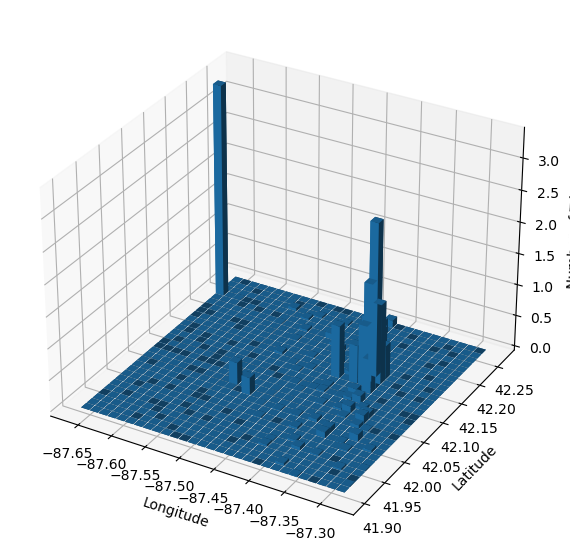

In [24]:
plot_3d_hist(ct_p.toPandas())

Видим, что самая плотная точка посадки находится на северо-западе (41.899602111|-87.633308037|673'556). Очевидно - это аэропорт О'Хара. 
Другие плотные точки находятся в центре города.  
Посмотрим график для точек с количеством поездок менее 200К

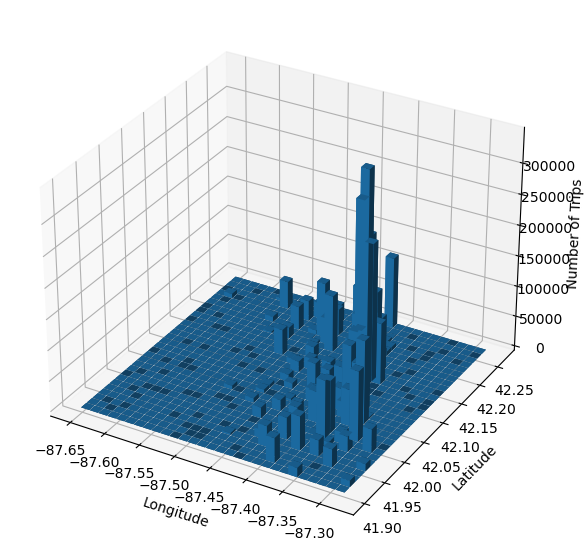

In [25]:
plot_3d_hist(ct_p.filter(f.col("count")<200000).toPandas())

Наиболее плотные области также в центре - вдоль озера.  
Посмотрим на точки высадки

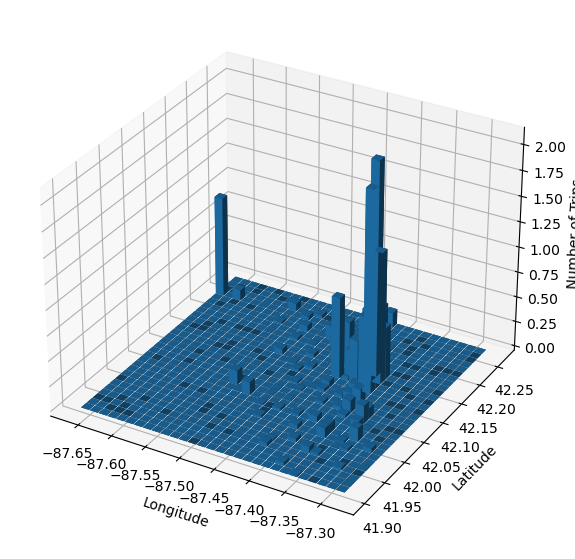

In [26]:
plot_3d_hist(ct_d.toPandas())

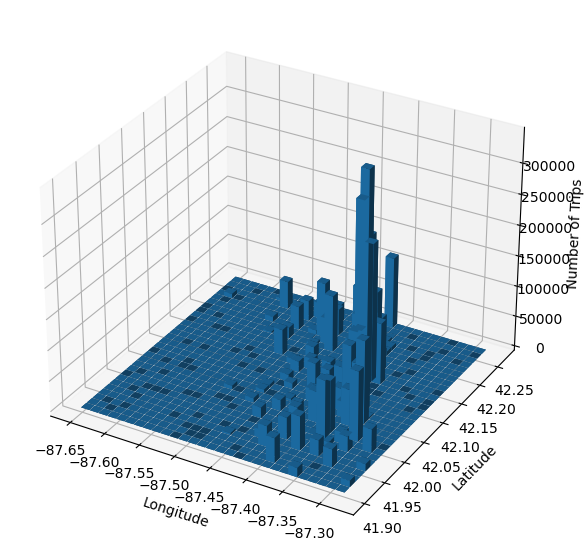

In [27]:
plot_3d_hist(ct_p.filter(f.col("count")<200000).toPandas())

Плотность точек высадки имеет схожую картину. Но аэропорт не лидирует.  

Основные выводы  
- следует отдельно анализировать поездки из аэропорта (и в аэропорт)
- основная часть поездок совершается по центральным районам

## Обзор полей 'Payment Type', 'Company'

Посмотрим типы платежей

Значения в поле "тип платежа" распределены следующим образом:  
```yaml
| Type        | Count      | Pt_Ratio |
|-------------|------------|----------|
| Credit Card | 7,122,369  | 38.08    |
| Cash        | 6,004,118  | 32.10    |
| Mobile      | 2,552,494  | 13.65    |
| Prcard      | 1,969,606  | 10.53    |
| Unknown     | 1,057,472  | 5.65     |


In [32]:
# payment_types = taxis.select(f.col(ct.payment_t))\
# .groupBy(f.col(ct.payment_t)).count().orderBy(f.col("count").desc()).toPandas()

In [33]:
# payment_types.set_index(['Payment Type'], inplace=True)

In [34]:
# pt = payment_types.copy()
# pt_total = pt['count'].sum()
# pt['pt_ratio']=(pt['count']/pt_total)*100
# # f"Доля таких записей в датасете: {(key_full_null_count/row_count)*100:.2f}%"

In [35]:
# #  отформатируем таблицу
# pds.get_df_formated(pt, '\'',2, 10)
# pt

Посмотрим компании

In [36]:
# companies = taxis.select(f.col(ct.company))\
# .groupBy(f.col(ct.company)).count().orderBy(f.col("count").desc()).toPandas()

In [37]:
# output_file_path = '/work/data/companies.csv'
# companies.to_csv(output_file_path, index=False)

In [38]:
companies = pd.read_csv('/work/data/companies.csv',sep=',')

companies.set_index([ct.company], inplace=True)

cmps = companies.copy()
cmps_total = cmps['count'].sum()
cmps['company_ratio']=(cmps['count']/cmps_total)*100

In [39]:
#  отформатируем таблицу
pds.get_df_formated(cmps, '\'',2, 10)
cmps['company_ratio'] = cmps['company_ratio'].astype(float)
print("Количество компаний:",cmps['count'].count())
cmps

Количество компаний: 24


,count,company_ratio
Company,,
Flash Cab,4'180'032,22.35
Taxi Affiliation Services,4'025'763,21.52
Sun Taxi,1'971'056,10.54
City Service,1'681'173,8.99
Taxicab Insurance Agency Llc,1'158'224,6.19
Chicago Independents,911'009,4.87
Medallion Leasin,776'334,4.15
Globe Taxi,661'826,3.54
"Taxicab Insurance Agency, LLC",617'510,3.30


In [40]:
# список топ команий с индивидуальной общей долей более 5%
top_companies = cmps[cmps['company_ratio'] >= 5.0].index.tolist()

## Агрегация описание

Сделаем агрегацию по четвертьчасовым периодам.  
Создадим 2 агрегированных ДФ:
- по районам (округам) посадки, без включения полей с гео-ключами высадки - suffix: `_p`
- по районам (округам) высадки, без включения полей с гео-ключами посадки - suffix: `_d`

Создадим такие поля:
- район (тракт): `ct`
- округ (ареа): `ca`
- начало интервала: `interbeg`
- конец интервала: `interend`
- количество поездок: `trips`
- общая длительность поездок: `time`
- общее расстояние поездок: `miles`
- средняя скорость поездок: `velocity` = `miles`/`time`
- суммы стоимостей: `fare`,`tips`,`tolls`,`extras`,`total`
- стоимости на расстояние: `farem`,`tipsm`,`tollsm`,`extrasm`,`totalm`
- стоимости на время: `fares`,`tipss`,`tollss`,`extrass`,`totals`
- тип платежа не включаю в рассмотрение
- кол-во заказов по каждой из 5 крупнейший компаний (с долей от 5% и выше): `comp1`,`comp2`,`comp3`,`comp4`,`comp5`
- общее кол-во заказов по компаниям с долей от 5% и ниже: `compless5`

## Агрегация - манипуляции

Если необходимо провести первичную агрегацию из исходных данных, выполняются действия в ранном разделе. Либо можно загрузить готовые первично агрегированные данные в соответствующем (последнем) разделе.

In [28]:
# ct.get_aliases()

In [39]:
# Ф-я для разбиения на четвертьчасовые интервалы
def truncate_to_quarter_hour(timestamp_col):
    return (f.floor(f.unix_timestamp(timestamp_col) / 900) * 900).cast("timestamp")

# def truncate_to_quarter_hour_upper(timestamp_col):
#     return (f.floor((f.unix_timestamp(timestamp_col) + 899) / 900) * 900).cast("timestamp")

In [30]:
# Добавим интервалы
taxis = taxis.withColumn("interbeg_p", truncate_to_quarter_hour("Trip Start Timestamp"))
taxis = taxis.withColumn(
    "interend_p",
    f.from_unixtime(f.unix_timestamp("interbeg_p") + 15 * 60)
)

Интервалы для высадки считаем по времени окончании поездки

In [31]:
taxis = taxis.withColumn("interbeg_d", truncate_to_quarter_hour("Trip End Timestamp"))
taxis = taxis.withColumn(
    "interend_d",
    f.from_unixtime(f.unix_timestamp("interbeg_d") + 15 * 60 * 60)
)

In [38]:
# interbegs_pick = taxis.select("interbeg_d").distinct()
# interbegs_drop = taxis.select("interbeg_d").distinct()

In [39]:
# print(interbegs_pick.count())
# interbegs_pick.cache()
# interbegs_pick.show(10)
# print(interbegs_drop.count())
# interbegs_drop.cache()
# interbegs_drop.show(10)

In [66]:
# создадим выражение для группировки: доля каждой топ-компании в агрегации
def comp_expr(top_companies=top_companies, suffix=''):
    comp_exprs = [
        f.expr(f"sum(case when Company = '{company}' then 1 else 0 end)")\
        .alias(f"comp{idx + 1}{suffix}")
        for idx, company in enumerate(top_companies)
    ]
    
    # общая доля компаний < 5% в агрегации
    comp_less5_expr = f.expr(
        "sum(case when Company NOT IN ({}) then 1 else 0 end)".format(
            ", ".join([f"'{company}'" for company in top_companies])
        )
    ).alias(f"compless5{suffix}")
    
    # List of all expressions
    all_comp_exprs = comp_exprs + [comp_less5_expr]
    return all_comp_exprs

In [34]:
# Ф-я агрегации
def agg_func(pickup_or_dropoff):
    if pickup_or_dropoff == 'pickup':
        tract_col, area_col, interbeg, interend = \
        ct.pickup_ct, ct.pickup_ca, 'interbeg_p', 'interend_p'
        suffix = '_p'
    else:
        tract_col, area_col, interbeg, interend = \
        ct.dropoff_ct, ct.dropoff_ca, 'interbeg_d', 'interend_d'
        suffix = '_d'


    all_comp_exprs = comp_expr(suffix)

    return (taxis.groupBy(
        f.col(tract_col).alias(f"ct{suffix}"),
        f.col(area_col).alias(f"ca{suffix}"),
        interbeg, interend)
                .agg(
                     f.count("*").alias(f"trips{suffix}"),
                     f.sum("Trip Seconds").alias(f"time{suffix}"),
                     f.sum("Trip Miles").alias(f"miles{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0, f.sum("Trip Miles") / f.sum("Trip Seconds")).otherwise(0).alias(f"velocity{suffix}"),
                     f.sum("Fare").alias(f"fare{suffix}"),
                     f.sum("Tips").alias(f"tips{suffix}"),
                     f.sum("Tolls").alias(f"tolls{suffix}"),
                     f.sum("Extras").alias(f"extras{suffix}"),
                     f.sum("Trip Total").alias(f"total{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Fare") / f.sum("Trip Miles")).otherwise(0).alias(f"farem{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Tips") / f.sum("Trip Miles")).otherwise(0).alias(f"tipsm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Tolls") / f.sum("Trip Miles")).otherwise(0).alias(f"tollsm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Extras") / f.sum("Trip Miles")).otherwise(0).alias(f"extrasm{suffix}"),
                     f.when(f.sum("Trip Miles") != 0,
                            f.sum("Trip Total") / f.sum("Trip Miles")).otherwise(0).alias(f"totalm{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Fare") / f.sum("Trip Seconds")).otherwise(0).alias(f"fares{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Tips") / f.sum("Trip Seconds")).otherwise(0).alias(f"tipss{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Tolls") / f.sum("Trip Seconds")).otherwise(0).alias(f"tollss{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Extras") / f.sum("Trip Seconds")).otherwise(0).alias(f"extrass{suffix}"),
                     f.when(f.sum("Trip Seconds") != 0,
                            f.sum("Trip Total") / f.sum("Trip Seconds")).otherwise(0).alias(f"totals{suffix}"),
                    *all_comp_exprs
                ))
    

In [35]:
# Aggregate by pickup census tract
agg_p_15m = agg_func('pickup')

In [36]:
# Aggregate by dropoff community area
agg_d_15m = agg_func('dropoff')

In [37]:
agg_p_15m.printSchema()

root
 |-- ct_p: long (nullable = true)
 |-- ca_p: integer (nullable = true)
 |-- interbeg_p: timestamp (nullable = true)
 |-- interend_p: string (nullable = true)
 |-- trips_p: long (nullable = false)
 |-- time_p: long (nullable = true)
 |-- miles_p: double (nullable = true)
 |-- velocity_p: double (nullable = true)
 |-- fare_p: double (nullable = true)
 |-- tips_p: double (nullable = true)
 |-- tolls_p: double (nullable = true)
 |-- extras_p: double (nullable = true)
 |-- total_p: double (nullable = true)
 |-- farem_p: double (nullable = true)
 |-- tipsm_p: double (nullable = true)
 |-- tollsm_p: double (nullable = true)
 |-- extrasm_p: double (nullable = true)
 |-- totalm_p: double (nullable = true)
 |-- fares_p: double (nullable = true)
 |-- tipss_p: double (nullable = true)
 |-- tollss_p: double (nullable = true)
 |-- extrass_p: double (nullable = true)
 |-- totals_p: double (nullable = true)
 |-- comp1_p: long (nullable = true)
 |-- comp2_p: long (nullable = true)
 |-- comp3_p: lo

In [50]:
agg_p_15m.printSchema()

root
 |-- ct_p: long (nullable = true)
 |-- ca_p: integer (nullable = true)
 |-- interbeg_p: timestamp (nullable = true)
 |-- interend_p: string (nullable = true)
 |-- trips_p: long (nullable = false)
 |-- time_p: long (nullable = true)
 |-- miles_p: double (nullable = true)
 |-- velocity_p: double (nullable = true)
 |-- fare_p: double (nullable = true)
 |-- tips_p: double (nullable = true)
 |-- tolls_p: double (nullable = true)
 |-- extras_p: double (nullable = true)
 |-- total_p: double (nullable = true)
 |-- farem_p: double (nullable = true)
 |-- tipsm_p: double (nullable = true)
 |-- tollsm_p: double (nullable = true)
 |-- extrasm_p: double (nullable = true)
 |-- totalm_p: double (nullable = true)
 |-- fares_p: double (nullable = true)
 |-- tipss_p: double (nullable = true)
 |-- tollss_p: double (nullable = true)
 |-- extrass_p: double (nullable = true)
 |-- totals_p: double (nullable = true)
 |-- comp1_p: double (nullable = true)
 |-- comp2_p: double (nullable = true)
 |-- comp3_p

## Агр 15 мин - сохранение и загрузка

In [42]:
# %%time
# agg_p_15m.coalesce(1).write.csv("/work/data/taxis_agg_p_15m.csv", header=True, mode="overwrite")

In [43]:
# %%time
# agg_d_15m.coalesce(1).write.csv("/work/data/taxis_agg_d_15m.csv", header=True, mode="overwrite")

In [36]:
%%time
agg_p_15m = spark.read.load('/work/data/taxis_agg_p_15m.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 8.77 ms, sys: 11.3 ms, total: 20.1 ms
Wall time: 34.8 s


In [38]:
%%time
agg_d_15m = spark.read.load('/work/data/taxis_agg_d_15m.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 18.6 ms, sys: 2.32 ms, total: 20.9 ms
Wall time: 26.6 s


## Районы-округи - выравнивание

Подготовим датафреймы с диапазоанми временных интервалов

In [39]:
intervals_p = agg_p_15m.groupBy("ct_p","ca_p").agg(
    f.min("interbeg_p").alias("interbeg_p_min"),
    f.max("interbeg_p").alias("interbeg_p_max"),
    f.min("interend_p").alias("interend_p_min"),
    f.max("interend_p").alias("interend_p_max"),
    f.count("ct_p").alias("cnt")
)

In [40]:
print(intervals_p.count())
intervals_p.cache()

749


DataFrame[ct_p: bigint, ca_p: int, interbeg_p_min: timestamp, interbeg_p_max: timestamp, interend_p_min: timestamp, interend_p_max: timestamp, cnt: bigint]

In [41]:
# intervals_p.show(5)

Посмотрим весь список районов

In [42]:
intervals_p.orderBy(f.col("ca_p"),f.col("cnt").desc()).show(750)

+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|       ct_p|ca_p|     interbeg_p_min|     interbeg_p_max|     interend_p_min|     interend_p_max|   cnt|
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|12000000046|   1|2021-01-01 00:30:00|2024-05-31 23:15:00|2021-01-01 00:45:00|2024-05-31 23:30:00| 65899|
|17031010503|   1|2021-01-21 17:45:00|2024-05-30 14:30:00|2021-01-21 18:00:00|2024-05-30 14:45:00|    79|
|17031010300|   1|2021-04-21 18:00:00|2024-05-11 18:00:00|2021-04-21 18:15:00|2024-05-11 18:15:00|    54|
|17031830600|   1|2021-05-05 11:30:00|2024-04-27 07:45:00|2021-05-05 11:45:00|2024-04-27 08:00:00|    50|
|17031010202|   1|2021-04-17 15:00:00|2024-05-30 14:30:00|2021-04-17 15:15:00|2024-05-30 14:45:00|    46|
|17031010501|   1|2021-01-11 19:30:00|2024-04-18 16:45:00|2021-01-11 19:45:00|2024-04-18 17:00:00|    33|
|17031010600|   1|2021-01-02 17:30:00|2024-05-

Видим, что в основном данные сосредоточены только в одном районе (ct_p) для каждого округа (ct_a). Хотя есть округи с равноценными районами по количеству поездок.  Найдем районы округов с максимальными количествами и заменим значения районов внутри округов, в которых количество поездок менее 10% от этого максимального значения на значения максимального района. После этого еще раз сагрегируем данные agg_p_15m по обновленным парам ct_p, cta.

Посмотрим дублирующиеся районы

In [43]:
ct_p_dbl =intervals_p.groupBy("ct_p").count().filter(f.col("count")>1)

In [44]:
ct_p_dbl.count()

25

In [45]:
intervals_p.join(ct_p_dbl, on=["ct_p"]).orderBy("ct_p").show(25)

+-----------+----+-------------------+-------------------+-------------------+-------------------+------+-----+
|       ct_p|ca_p|     interbeg_p_min|     interbeg_p_max|     interend_p_min|     interend_p_max|   cnt|count|
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+-----+
|17031010702|   1|2021-06-27 15:30:00|2024-03-30 02:00:00|2021-06-27 15:45:00|2024-03-30 02:15:00|    15|    2|
|17031010702|  76|2021-01-01 00:00:00|2024-06-01 00:00:00|2021-01-01 00:15:00|2024-06-01 00:15:00|113345|    2|
|17031020602|  18|2021-01-01 03:30:00|2024-05-31 15:30:00|2021-01-01 03:45:00|2024-05-31 15:45:00|  2484|    2|
|17031020602|   2|2021-02-11 15:00:00|2024-05-31 14:15:00|2021-02-11 15:15:00|2024-05-31 14:30:00|   198|    2|
|17031030500|  28|2021-01-01 00:00:00|2024-06-01 00:00:00|2021-01-01 00:15:00|2024-06-01 00:15:00|109519|    2|
|17031030500|  77|2021-04-12 14:30:00|2024-04-13 09:45:00|2021-04-12 14:45:00|2024-04-13 10:00:00|    90

Посмотрим дубли для районов высадки

In [46]:
intervals_d = agg_d_15m.groupBy("ct_d","ca_d").agg(
    f.min("interbeg_d").alias("interbeg_d_min"),
    f.max("interbeg_d").alias("interbeg_d_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max"),
    f.count("ct_d").alias("cnt")
)

In [47]:
print(intervals_d.count())
intervals_d.cache()

775


DataFrame[ct_d: bigint, ca_d: int, interbeg_d_min: timestamp, interbeg_d_max: timestamp, interend_d_min: timestamp, interend_d_max: timestamp, cnt: bigint]

In [48]:
intervals_d.orderBy(f.col("ca_d"),f.col("cnt").desc()).show(775)

+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|       ct_d|ca_d|     interbeg_d_min|     interbeg_d_max|     interend_d_min|     interend_d_max|   cnt|
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|12000000046|   1|2021-01-01 00:30:00|2024-06-01 00:30:00|2021-01-01 15:30:00|2024-06-01 15:30:00| 75390|
|17031010400|   1|2021-02-04 12:45:00|2024-05-16 17:15:00|2021-02-05 03:45:00|2024-05-17 08:15:00|   123|
|17031010300|   1|2021-01-13 20:00:00|2024-05-23 11:30:00|2021-01-14 11:00:00|2024-05-24 02:30:00|   103|
|17031010503|   1|2021-03-15 19:45:00|2024-05-14 13:00:00|2021-03-16 10:45:00|2024-05-15 04:00:00|   101|
|17031010600|   1|2021-01-02 12:00:00|2024-05-23 01:15:00|2021-01-03 03:00:00|2024-05-23 16:15:00|    83|
|17031830600|   1|2021-01-26 18:30:00|2024-05-01 13:00:00|2021-01-27 09:30:00|2024-05-02 04:00:00|    77|
|17031010202|   1|2021-04-16 16:00:00|2024-05-

In [49]:
ct_d_dbl =intervals_d.groupBy("ct_d").count().filter(f.col("count")>1)
ct_d_dbl_count =ct_d_dbl.count()
print(ct_d_dbl_count)
ct_d_dbl.cache()
intervals_d.join(ct_d_dbl, on=["ct_d"]).orderBy("ct_d").show(ct_d_dbl_count)

26
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+-----+
|       ct_d|ca_d|     interbeg_d_min|     interbeg_d_max|     interend_d_min|     interend_d_max|   cnt|count|
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+-----+
|17031010702|   1|2021-02-01 12:00:00|2024-05-17 11:30:00|2021-02-02 03:00:00|2024-05-18 02:30:00|    26|    2|
|17031010702|  76|2021-01-01 00:00:00|2024-06-01 00:45:00|2021-01-01 15:00:00|2024-06-01 15:45:00|103878|    2|
|17031020602|  18|2021-01-01 03:00:00|2024-05-31 23:15:00|2021-01-01 18:00:00|2024-06-01 14:15:00|  5020|    2|
|17031020602|   2|2021-02-05 15:45:00|2024-05-31 14:15:00|2021-02-06 06:45:00|2024-06-01 05:15:00|   240|    2|
|17031030500|  77|2021-01-11 18:30:00|2024-05-30 01:00:00|2021-01-12 09:30:00|2024-05-30 16:00:00|   381|    2|
|17031030500|  28|2021-01-01 00:00:00|2024-06-01 00:30:00|2021-01-01 15:00:00|2024-06-01 15:30:00|111

Видим, что такие районы повторяются не более чем в двух округах и имеют почти 100%-ную концентрацию в одном из районов округа. Такая принадлежность одного района к двум округам может быть ошибкой в данных, либо переотнесением районов между округами. Поменяем округ у таких районов на тот в котором было больше поездок.

In [50]:
ct_p_mx =intervals_p.join(ct_p_dbl, on=["ct_p"])\
    .groupBy("ct_p").agg(f.max("cnt").alias("mx")).orderBy("ct_p")
upd_ca_p = intervals_p.join(ct_p_mx,on=["ct_p"],how='left')\
    .filter(f.col('cnt')==f.col('mx'))\
    .select(f.col("ct_p").alias("joined_ct_p"),
            f.col("ca_p").alias("upd_ca_p"))
agg_p_15m = agg_p_15m\
    .join(upd_ca_p, f.col("ct_p")==f.col("joined_ct_p"), how = 'left')
agg_p_15m = agg_p_15m.withColumn(
    "ca_p", f.when(f.col("upd_ca_p").isNotNull(),
                    f.col("upd_ca_p")).otherwise(f.col("ca_p"))
).drop('joined_ct_p','upd_ca_p')

In [51]:
intervals_p = agg_p_15m.groupBy("ct_p","ca_p").agg(
    f.min("interbeg_p").alias("interbeg_p_min"),
    f.max("interbeg_p").alias("interbeg_p_max"),
    f.min("interend_p").alias("interend_p_min"),
    f.max("interend_p").alias("interend_p_max"),
    f.count("ct_p").alias("cnt")
)

In [52]:
ct_p_dbl =intervals_p.groupBy("ct_p").count().filter(f.col("count")>1)
ct_p_dbl.count()

0

In [53]:
ct_d_mx =intervals_d.join(ct_d_dbl, on=["ct_d"])\
    .groupBy("ct_d").agg(f.max("cnt").alias("mx")).orderBy("ct_d")
upd_ca_d = intervals_d.join(ct_d_mx,on=["ct_d"],how='left')\
    .filter(f.col('cnt')==f.col('mx'))\
    .select(f.col("ct_d").alias("joined_ct_d"),
            f.col("ca_d").alias("upd_ca_d"))
agg_d_15m = agg_d_15m\
    .join(upd_ca_d, f.col("ct_d")==f.col("joined_ct_d"), how = 'left')
agg_d_15m = agg_d_15m.withColumn(
    "ca_d", f.when(f.col("upd_ca_d").isNotNull(),
                    f.col("upd_ca_d")).otherwise(f.col("ca_d"))
).drop('joined_ct_d','upd_ca_d')

In [54]:
intervals_d = agg_d_15m.groupBy("ct_d","ca_d").agg(
    f.min("interbeg_d").alias("interbeg_d_min"),
    f.max("interbeg_d").alias("interbeg_d_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max"),
    f.count("ct_d").alias("cnt")
)

In [55]:
ct_d_dbl =intervals_d.groupBy("ct_d").count().filter(f.col("count")>1)
ct_d_dbl.count()

0

Дублирующихся районов не осталось. Сгруппируем небольшие районы с большими.

In [56]:
intervals_p.cache()
intervals_d.cache()

DataFrame[ct_d: bigint, ca_d: int, interbeg_d_min: timestamp, interbeg_d_max: timestamp, interend_d_min: timestamp, interend_d_max: timestamp, cnt: bigint]

In [57]:
# максимальное количество поездок для каждого округа
max_trips_per_ca = intervals_p.groupBy("ca_p").agg(f.max("cnt").alias("max_cnt"))
# Объединим с исходной таблицей, чтобы получить максимальное значение для каждого ct_p
intervals_p_with_max = intervals_p.join(max_trips_per_ca, on="ca_p")
# Вычислим 10% от максимального значения для каждого округа
intervals_p_with_max = intervals_p_with_max.withColumn(
    "threshold", f.col("max_cnt") * 0.1
)
# Определим ct_p для замены
replace_ct_p = intervals_p_with_max.filter(f.col("cnt") < f.col("threshold")).select("ct_p", "ca_p")
# ct_p с максимальным количеством поездок для каждого округа
max_ct_p_per_ca = intervals_p_with_max.filter(f.col("cnt") == f.col("max_cnt")).select("ct_p", "ca_p")
updated_ct_p = replace_ct_p.alias("a").join(max_ct_p_per_ca.alias("b"), on=["ca_p"]).select(
    f.col("a.ca_p"),f.col("a.ct_p"),f.col("b.ct_p").alias("ct_p_upd")
)
# Заменим значения ct_p
updated_intervals_p = intervals_p.join(
    updated_ct_p, on=["ct_p", "ca_p"], how="left"
).withColumn(
    "updated_ct_p", f.when(f.col("ct_p_upd").isNotNull(), f.col("ct_p_upd")).otherwise(f.col("ct_p"))
).select(
    "updated_ct_p", "ct_p", "ca_p", "interbeg_p_min", "interbeg_p_max", "interend_p_min", "interend_p_max", "cnt"
)
# print(updated_intervals_p.count())
# updated_intervals_p.cache()
# updated_intervals_p.orderBy(f.col("ca_p"),f.col("cnt").desc()).show(20)
ctp_upd = updated_intervals_p.select(
    "updated_ct_p",
    f.col("ca_p").alias("joined_ca_p"),
    f.col("ct_p").alias("joined_ct_p"),'cnt'
)
agg_p_15m_upd = agg_p_15m.alias("a").join(ctp_upd.alias("b"),
            f.col("a.ct_p") == f.col("b.joined_ct_p")
).drop("ct_p",'joined_ct_p','joined_ca_p','cnt')\
.withColumnRenamed("updated_ct_p", "ct_p")

In [58]:
agg_p_15m_upd.printSchema()

root
 |-- ca_p: integer (nullable = true)
 |-- interbeg_p: timestamp (nullable = true)
 |-- interend_p: timestamp (nullable = true)
 |-- trips_p: integer (nullable = true)
 |-- time_p: integer (nullable = true)
 |-- miles_p: double (nullable = true)
 |-- velocity_p: double (nullable = true)
 |-- fare_p: double (nullable = true)
 |-- tips_p: double (nullable = true)
 |-- tolls_p: double (nullable = true)
 |-- extras_p: double (nullable = true)
 |-- total_p: double (nullable = true)
 |-- farem_p: double (nullable = true)
 |-- tipsm_p: double (nullable = true)
 |-- tollsm_p: double (nullable = true)
 |-- extrasm_p: double (nullable = true)
 |-- totalm_p: double (nullable = true)
 |-- fares_p: double (nullable = true)
 |-- tipss_p: double (nullable = true)
 |-- tollss_p: double (nullable = true)
 |-- extrass_p: double (nullable = true)
 |-- totals_p: double (nullable = true)
 |-- comp1_p: integer (nullable = true)
 |-- comp2_p: integer (nullable = true)
 |-- comp3_p: integer (nullable = tr

In [59]:
# Максимальное количество поездок для каждого округа
max_trips_per_ca_d = intervals_d.groupBy("ca_d").agg(f.max("cnt").alias("max_cnt"))

# Объединим с исходной таблицей, чтобы получить максимальное значение для каждого ct_d
intervals_d_with_max = intervals_d.join(max_trips_per_ca_d, on="ca_d")

# Вычислим 10% от максимального значения для каждого округа
intervals_d_with_max = intervals_d_with_max.withColumn(
    "threshold", f.col("max_cnt") * 0.1
)

# Определим ct_d для замены
replace_ct_d = intervals_d_with_max.filter(f.col("cnt") < f.col("threshold")).select("ct_d", "ca_d")

# ct_d с максимальным количеством поездок для каждого округа
max_ct_d_per_ca = intervals_d_with_max.filter(f.col("cnt") == f.col("max_cnt")).select("ct_d", "ca_d")

updated_ct_d = replace_ct_d.alias("a").join(max_ct_d_per_ca.alias("b"), on=["ca_d"]).select(
    f.col("a.ca_d"), f.col("a.ct_d"), f.col("b.ct_d").alias("ct_d_upd")
)

# Заменим значения ct_d
updated_intervals_d = intervals_d.join(
    updated_ct_d, on=["ct_d", "ca_d"], how="left"
).withColumn(
    "updated_ct_d", f.when(f.col("ct_d_upd").isNotNull(), f.col("ct_d_upd")).otherwise(f.col("ct_d"))
).select(
    "updated_ct_d", "ct_d", "ca_d", "interbeg_d_min", "interbeg_d_max", "interend_d_min", "interend_d_max", "cnt"
)

# print(updated_intervals_d.count())
# updated_intervals_d.cache()
# updated_intervals_d.orderBy(f.col("ca_d"), f.col("cnt").desc()).show(20)

ctd_upd = updated_intervals_d.select(
    "updated_ct_d",
    f.col("ca_d").alias("joined_ca_d"),
    f.col("ct_d").alias("joined_ct_d"), 'cnt'
)

agg_d_15m_upd = agg_d_15m.alias("a").join(ctd_upd.alias("b"),
            f.col("a.ct_d") == f.col("b.joined_ct_d")
).drop("ct_d", 'joined_ct_d', 'joined_ca_d', 'cnt')\
.withColumnRenamed("updated_ct_d", "ct_d")

In [60]:
agg_d_15m_upd.printSchema()

root
 |-- ca_d: integer (nullable = true)
 |-- interbeg_d: timestamp (nullable = true)
 |-- interend_d: timestamp (nullable = true)
 |-- trips_d: integer (nullable = true)
 |-- time_d: integer (nullable = true)
 |-- miles_d: double (nullable = true)
 |-- velocity_d: double (nullable = true)
 |-- fare_d: double (nullable = true)
 |-- tips_d: double (nullable = true)
 |-- tolls_d: double (nullable = true)
 |-- extras_d: double (nullable = true)
 |-- total_d: double (nullable = true)
 |-- farem_d: double (nullable = true)
 |-- tipsm_d: double (nullable = true)
 |-- tollsm_d: double (nullable = true)
 |-- extrasm_d: double (nullable = true)
 |-- totalm_d: double (nullable = true)
 |-- fares_d: double (nullable = true)
 |-- tipss_d: double (nullable = true)
 |-- tollss_d: double (nullable = true)
 |-- extrass_d: double (nullable = true)
 |-- totals_d: double (nullable = true)
 |-- comp1_d: integer (nullable = true)
 |-- comp2_d: integer (nullable = true)
 |-- comp3_d: integer (nullable = tr

In [61]:
# agg_p_15m_upd.select("ca_p","updated_ct_p","ct_p").distinct().orderBy("ca_p","ct_p").show(20)

In [62]:
# agg_p_15m_upd.printSchema()

In [63]:
def agg_agg(suffix, df, top_companies):
    # Список имен полей компаний
    comp_fields = [f"comp{idx + 1}{suffix}" for idx in range(len(top_companies))] + [f"compless5{suffix}"]
    
    # Выражения для агрегаций компаний
    comp_agg_exprs = [f.sum(field).alias(field) for field in comp_fields]
    
    # Агрегируем DataFrame
    agg_df = df.groupBy(
        f"ct{suffix}", f"ca{suffix}", f"interbeg{suffix}", f"interend{suffix}"
    ).agg(
        f.sum(f"trips{suffix}").alias(f"trips{suffix}"),
        f.sum(f"time{suffix}").alias(f"time{suffix}"),
        f.sum(f"miles{suffix}").alias(f"miles{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, f.sum(f"miles{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"velocity{suffix}"),
        f.sum(f"fare{suffix}").alias(f"fare{suffix}"),
        f.sum(f"tips{suffix}").alias(f"tips{suffix}"),
        f.sum(f"tolls{suffix}").alias(f"tolls{suffix}"),
        f.sum(f"extras{suffix}").alias(f"extras{suffix}"),
        f.sum(f"total{suffix}").alias(f"total{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"fare{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"farem{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"tips{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"tipsm{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"tolls{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"tollsm{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"extras{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"extrasm{suffix}"),
        f.when(f.sum(f"miles{suffix}") != 0, 
               f.sum(f"total{suffix}") / f.sum(f"miles{suffix}")).otherwise(0).alias(f"totalm{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"fare{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"fares{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"tips{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"tipss{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"tolls{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"tollss{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"extras{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"extrass{suffix}"),
        f.when(f.sum(f"time{suffix}") != 0, 
               f.sum(f"total{suffix}") / f.sum(f"time{suffix}")).otherwise(0).alias(f"totals{suffix}"),
        *comp_agg_exprs  # добавление суммированных полей компаний
    )
    return agg_df

In [64]:
suffix = "_p"
agg_p_15m_agg = agg_agg(suffix, agg_p_15m_upd, top_companies)

In [65]:
suffix = "_d"
agg_d_15m_agg = agg_agg(suffix, agg_d_15m_upd, top_companies)

In [66]:
agg_p_15m_agg.printSchema()

root
 |-- ct_p: long (nullable = true)
 |-- ca_p: integer (nullable = true)
 |-- interbeg_p: timestamp (nullable = true)
 |-- interend_p: timestamp (nullable = true)
 |-- trips_p: long (nullable = true)
 |-- time_p: long (nullable = true)
 |-- miles_p: double (nullable = true)
 |-- velocity_p: double (nullable = true)
 |-- fare_p: double (nullable = true)
 |-- tips_p: double (nullable = true)
 |-- tolls_p: double (nullable = true)
 |-- extras_p: double (nullable = true)
 |-- total_p: double (nullable = true)
 |-- farem_p: double (nullable = true)
 |-- tipsm_p: double (nullable = true)
 |-- tollsm_p: double (nullable = true)
 |-- extrasm_p: double (nullable = true)
 |-- totalm_p: double (nullable = true)
 |-- fares_p: double (nullable = true)
 |-- tipss_p: double (nullable = true)
 |-- tollss_p: double (nullable = true)
 |-- extrass_p: double (nullable = true)
 |-- totals_p: double (nullable = true)
 |-- comp1_p: long (nullable = true)
 |-- comp2_p: long (nullable = true)
 |-- comp3_p: 

In [67]:
agg_d_15m_agg.printSchema()

root
 |-- ct_d: long (nullable = true)
 |-- ca_d: integer (nullable = true)
 |-- interbeg_d: timestamp (nullable = true)
 |-- interend_d: timestamp (nullable = true)
 |-- trips_d: long (nullable = true)
 |-- time_d: long (nullable = true)
 |-- miles_d: double (nullable = true)
 |-- velocity_d: double (nullable = true)
 |-- fare_d: double (nullable = true)
 |-- tips_d: double (nullable = true)
 |-- tolls_d: double (nullable = true)
 |-- extras_d: double (nullable = true)
 |-- total_d: double (nullable = true)
 |-- farem_d: double (nullable = true)
 |-- tipsm_d: double (nullable = true)
 |-- tollsm_d: double (nullable = true)
 |-- extrasm_d: double (nullable = true)
 |-- totalm_d: double (nullable = true)
 |-- fares_d: double (nullable = true)
 |-- tipss_d: double (nullable = true)
 |-- tollss_d: double (nullable = true)
 |-- extrass_d: double (nullable = true)
 |-- totals_d: double (nullable = true)
 |-- comp1_d: long (nullable = true)
 |-- comp2_d: long (nullable = true)
 |-- comp3_d: 

In [68]:
intervals_p_agg = agg_p_15m_agg.groupBy("ct_p","ca_p").agg(
    f.min("interbeg_p").alias("interbeg_p_min"),
    f.max("interbeg_p").alias("interbeg_p_max"),
    f.min("interend_p").alias("interend_p_min"),
    f.max("interend_p").alias("interend_p_max"),
    f.count("ct_p").alias("cnt")
)

In [69]:
print(intervals_p_agg.count())
intervals_p_agg.cache()

103


DataFrame[ct_p: bigint, ca_p: int, interbeg_p_min: timestamp, interbeg_p_max: timestamp, interend_p_min: timestamp, interend_p_max: timestamp, cnt: bigint]

In [70]:
intervals_p_agg.orderBy(f.col("ca_p"),f.col("cnt").desc()).show(105)

+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|       ct_p|ca_p|     interbeg_p_min|     interbeg_p_max|     interend_p_min|     interend_p_max|   cnt|
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|12000000046|   1|2021-01-01 00:30:00|2024-05-31 23:15:00|2021-01-01 00:45:00|2024-05-31 23:30:00| 65920|
|12000000025|   2|2021-01-01 00:15:00|2024-05-31 23:30:00|2021-01-01 00:30:00|2024-05-31 23:45:00| 73148|
|12000000010|   3|2021-01-01 01:00:00|2024-05-31 23:45:00|2021-01-01 01:15:00|2024-06-01 00:00:00| 92377|
|17031671200|   4|2021-01-01 01:00:00|2024-05-31 23:45:00|2021-01-01 01:15:00|2024-06-01 00:00:00| 52768|
|12000000043|   5|2021-01-01 03:00:00|2024-05-31 23:45:00|2021-01-01 03:15:00|2024-06-01 00:00:00| 40017|
|17031090200|   6|2021-01-01 00:00:00|2024-06-01 00:00:00|2021-01-01 00:15:00|2024-06-01 00:15:00|108528|
|17031242200|   7|2021-01-01 00:15:00|2024-06-

In [71]:
intervals_d_agg = agg_d_15m_agg.groupBy("ct_d","ca_d").agg(
    f.min("interbeg_d").alias("interbeg_d_min"),
    f.max("interbeg_d").alias("interbeg_d_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max"),
    f.count("ct_d").alias("cnt")
)

In [72]:
print(intervals_d_agg.count())
intervals_d_agg.cache()

106


DataFrame[ct_d: bigint, ca_d: int, interbeg_d_min: timestamp, interbeg_d_max: timestamp, interend_d_min: timestamp, interend_d_max: timestamp, cnt: bigint]

In [73]:
intervals_d_agg.orderBy(f.col("ca_d"),f.col("cnt").desc()).show(106)

+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|       ct_d|ca_d|     interbeg_d_min|     interbeg_d_max|     interend_d_min|     interend_d_max|   cnt|
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|12000000046|   1|2021-01-01 00:30:00|2024-06-01 00:30:00|2021-01-01 15:30:00|2024-06-01 15:30:00| 75411|
|12000000025|   2|2021-01-01 01:15:00|2024-06-01 00:15:00|2021-01-01 16:15:00|2024-06-01 15:15:00| 78286|
|12000000010|   3|2021-01-01 00:30:00|2024-06-01 00:30:00|2021-01-01 15:30:00|2024-06-01 15:30:00| 99734|
|17031671200|   4|2021-01-01 00:15:00|2024-06-01 00:00:00|2021-01-01 15:15:00|2024-06-01 15:00:00| 70971|
|12000000043|   5|2021-01-01 01:45:00|2024-06-01 00:15:00|2021-01-01 16:45:00|2024-06-01 15:15:00| 68908|
|17031090200|   6|2021-01-01 00:30:00|2024-06-01 00:15:00|2021-01-01 15:30:00|2024-06-01 15:15:00|108059|
|17031242200|   7|2021-01-01 00:15:00|2024-06-

Получили ровный датафрейм интервалов.

Посмотрим различия ключей-геоточек в итоговых множествах посадки и высадки

In [74]:
def pickup_dropoff_diff():
    # Найдем уникальные пары (ct_d, ca_d) в intervals_d_agg
    unique_pairs_d = intervals_d_agg.select("ct_d", "ca_d", "cnt").distinct()
    
    # Найдем уникальные пары (ct_p, ca_p) в intervals_p_agg
    unique_pairs_p = intervals_p_agg.select(f.col("ct_p").alias("ct_d"), f.col("ca_p").alias("ca_d"), "cnt").distinct()
    
    # Найдем выбивающиеся пары в intervals_d_agg, которых нет в intervals_p_agg
    missing_in_p = unique_pairs_d.join(unique_pairs_p, on=["ct_d", "ca_d"], how="left_anti")
    missing_in_p = missing_in_p
    
    # Найдем выбивающиеся пары в intervals_p_agg, которых нет в intervals_d_agg
    missing_in_d = unique_pairs_p.join(unique_pairs_d, on=["ct_d", "ca_d"], how="left_anti")\
    .withColumnRenamed("ct_d", "ct_p").withColumnRenamed("ca_d", "ca_p")
    
    # Показать результаты
    print("tracts, areas in dropoff missing in pickup")
    missing_in_p.show()
    print("tracts, areas in pickup missing in dropoff")
    missing_in_d.show()

Видим, ожидаемые тракты 11000000000 и 10000000000 - заглушки для поездок, в которых есть данные по пункту посадки (или наоборот высадки) и отсутствуют по высадке (и наоборот - по посадке).  

Посмотрим районы посадки для округов 7 и 28

In [75]:
intervals_p_agg.filter(f.col("ca_p").isin([7,28])).show()

+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|       ct_p|ca_p|     interbeg_p_min|     interbeg_p_max|     interend_p_min|     interend_p_max|   cnt|
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|17031030500|  28|2021-01-01 00:00:00|2024-06-01 00:00:00|2021-01-01 00:15:00|2024-06-01 00:15:00|109526|
|17031242200|   7|2021-01-01 00:15:00|2024-06-01 00:00:00|2021-01-01 00:30:00|2024-06-01 00:15:00| 97659|
|17031281900|  28|2021-01-01 12:15:00|2024-05-31 23:45:00|2021-01-01 12:30:00|2024-06-01 00:00:00| 68737|
|17031833000|  28|2021-01-19 12:30:00|2024-06-01 00:00:00|2021-01-19 12:45:00|2024-06-01 00:15:00| 20860|
|17031838200|  28|2021-01-04 10:45:00|2024-05-31 17:00:00|2021-01-04 11:00:00|2024-05-31 17:15:00| 11601|
|17031280100|  28|2021-01-02 17:45:00|2024-05-31 23:45:00|2021-01-02 18:00:00|2024-06-01 00:00:00| 41055|
+-----------+----+-------------------+--------

In [76]:
intervals_d_agg.filter(f.col("ca_d").isin([7,28])).show()

+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|       ct_d|ca_d|     interbeg_d_min|     interbeg_d_max|     interend_d_min|     interend_d_max|   cnt|
+-----------+----+-------------------+-------------------+-------------------+-------------------+------+
|17031071500|   7|2021-01-04 13:45:00|2024-05-31 23:45:00|2021-01-05 04:45:00|2024-06-01 14:45:00| 17300|
|17031030500|  28|2021-01-01 00:00:00|2024-06-01 00:30:00|2021-01-01 15:00:00|2024-06-01 15:30:00|111685|
|17031242200|   7|2021-01-01 00:15:00|2024-06-01 00:30:00|2021-01-01 15:15:00|2024-06-01 15:30:00|102453|
|17031841900|  28|2021-01-02 10:45:00|2024-05-31 22:45:00|2021-01-03 01:45:00|2024-06-01 13:45:00| 16835|
|17031833100|  28|2021-01-04 11:45:00|2024-05-31 22:15:00|2021-01-05 02:45:00|2024-06-01 13:15:00| 15032|
|17031281900|  28|2021-01-01 12:45:00|2024-06-01 00:00:00|2021-01-02 03:45:00|2024-06-01 15:00:00| 59990|
|17031833000|  28|2021-01-03 19:00:00|2024-05-

Заменим в ДФ высадки agg_d_15m_agg коды районов (ct_d)
- 17031071500 на 17031242200,
- 17031841900 и 17031833100 на 17031030500

In [77]:
# Заменяем коды районов
agg_d_15m_agg = agg_d_15m_agg.withColumn(
    "ct_d_updated",
    f.when(f.col("ct_d") == "17031071500", "17031242200")
    .when(f.col("ct_d").isin("17031841900", "17031833100"), "17031030500")
    .otherwise(f.col("ct_d"))
).drop("ct_d").withColumnRenamed("ct_d_updated", "ct_d")

In [78]:
suffix = "_d"
agg_d_15m_agg = agg_agg(suffix, agg_d_15m_agg, top_companies)

In [79]:
# agg_d_15m_agg.printSchema()

In [80]:
intervals_d_agg = agg_d_15m_agg.groupBy("ct_d","ca_d").agg(
    f.min("interbeg_d").alias("interbeg_d_min"),
    f.max("interbeg_d").alias("interbeg_d_max"),
    f.min("interend_d").alias("interend_d_min"),
    f.max("interend_d").alias("interend_d_max"),
    f.count("ct_d").alias("cnt")
)

In [81]:
print(intervals_d_agg.count())
intervals_d_agg.cache()

103


DataFrame[ct_d: string, ca_d: int, interbeg_d_min: timestamp, interbeg_d_max: timestamp, interend_d_min: timestamp, interend_d_max: timestamp, cnt: bigint]

In [82]:
pickup_dropoff_diff()

tracts, areas in dropoff missing in pickup
+-----------+----+------+
|       ct_d|ca_d|   cnt|
+-----------+----+------+
|11000000000|  92|113463|
+-----------+----+------+

tracts, areas in pickup missing in dropoff
+-----------+----+-----+
|       ct_p|ca_p|  cnt|
+-----------+----+-----+
|10000000000|  91|95627|
+-----------+----+-----+



Получили два сопоставимых по гео-ключам датафрейма. Подготовим сетку интервалов

## Сетка интервалов

Очевидно в датафреймах есть пробелы в интервалах.
Создадим дф с ровным рядом интервалов. Потом к нему лефт джойном присоединим _df_agg для каждого _Census Tract.

Исходный ДФ имеет следующие диапазоны временных интервалов  
```yaml
| Time Type       | Min                    | Max                    |
|-----------------|------------------------|------------------------|
| Start time      | 2021-01-01 00:00:00    | 2024-06-01 00:00:00    |
| End time        | 2021-01-01 00:00:00    | 2024-06-01 00:45:00    |
| Interbeg_p time | 2021-01-01 00:00:00    | 2024-06-01 00:00:00    |
| Interend_d      | 2021-01-01 15:00:00    | 2024-06-01 15:45:00    |


In [83]:
# agg_results = taxis.agg(
#     f.min("Trip Start Timestamp").alias("start_time_min"),
#     f.max("Trip Start Timestamp").alias("start_time_max"),
#     f.min("Trip End Timestamp").alias("end_time_min"),
#     f.max("Trip End Timestamp").alias("end_time_max"),
#     f.min("interbeg_p").alias("interbeg_p_min"),
#     f.max("interbeg_p").alias("interbeg_p_max"),
#     f.min("interend_d").alias("interend_d_min"),
#     f.max("interend_d").alias("interend_d_max")
# ).first()

# # Извлечение результатов
# start_time_min = agg_results['start_time_min']
# start_time_max = agg_results['start_time_max']
# end_time_min = agg_results['end_time_min']
# end_time_max = agg_results['end_time_max']
# interbeg_p_min = agg_results['interbeg_p_min']
# interbeg_p_max = agg_results['interbeg_p_max']
# interend_d_min = agg_results['interend_d_min']
# interend_d_max = agg_results['interend_d_max']

# print(f"Start time range: {start_time_min} to {start_time_max}")
# print(f"End time range: {end_time_min} to {end_time_max}")
# print(f"Interbeg_p time range: {interbeg_p_min} to {interbeg_p_max}")
# print(f"Interend_d range: {interend_d_min} to {interend_d_max}")

In [84]:
intervals_count_p = intervals_p_agg.agg(f.sum("cnt")).take(1)[0]["sum(cnt)"]
print(pds.gvf(intervals_count_p))

4'093'202


In [85]:
print("максимальное количество 15-мин интервалов на 103 округах",pds.gvf(103*4*24*365*3.5))

максимальное количество 15-мин интервалов на 103 округах 12'631'920


Общее количество 15-минутных интервалов для 103 районов за период 3.5 года - около 4.1М штук. Это меньше максимального расчетного количества. Создадим сетку интервалов.

In [86]:
intervals_p_list = intervals_p_agg.collect()

In [87]:
# Создаем пустой DataFrame для хранения всех интервалов
full_intervals = None

# Создаем интервалы для каждой пары ct_p и ca_p
for row in tqdm(intervals_p_list):
    ct_p = row['ct_p']
    ca_p = row['ca_p']
    interbeg_p_min = row['interbeg_p_min']
    interbeg_p_max = row['interbeg_p_max']
    
    # Создаем диапазон дат с использованием Spark SQL функций
    date_range = spark.sql(f"""
        SELECT explode(sequence(
            to_timestamp('{interbeg_p_min}'),
            to_timestamp('{interbeg_p_max}'),
            interval 15 minutes
        )) as interbeg
    """)
    
    df_intervals = date_range.withColumn("interend", f.col("interbeg") + f.expr("INTERVAL 15 MINUTES"))
    
    # Добавляем ct_p и ca_p к интервалам
    df_intervals = df_intervals.withColumn("ct", f.lit(ct_p)).withColumn("ca", f.lit(ca_p))
    
    # Объединяем интервалы для всех пар
    if full_intervals is None:
        full_intervals = df_intervals
    else:
        full_intervals = full_intervals.union(df_intervals)

100%|██████████| 103/103 [00:06<00:00, 15.87it/s]


In [89]:
print("размер сетки:",pds.gvf(full_intervals.count()))
full_intervals.cache()

размер сетки: 12'318'007


DataFrame[interbeg: timestamp, interend: timestamp, ct: bigint, ca: int]

In [90]:
full_intervals.show(5)

+-------------------+-------------------+-----------+---+
|           interbeg|           interend|         ct| ca|
+-------------------+-------------------+-----------+---+
|2021-01-01 18:15:00|2021-01-01 18:30:00|17031081500|  8|
|2021-01-01 18:30:00|2021-01-01 18:45:00|17031081500|  8|
|2021-01-01 18:45:00|2021-01-01 19:00:00|17031081500|  8|
|2021-01-01 19:00:00|2021-01-01 19:15:00|17031081500|  8|
|2021-01-01 19:15:00|2021-01-01 19:30:00|17031081500|  8|
+-------------------+-------------------+-----------+---+
only showing top 5 rows



Делать сетку для интервалов по районам высадки не будем. Т.к. прогнозы строятся для районов посадки. И те интервалы высадки, которые выходят за пределы созданной сетки для посадки, очевидно могут только "убегать" в будущее относительно посадки, соответственно не могут использоваться нами для прогнозов.

Присоеденим ДФ с данными по посадке к созданной сетке

In [ ]:
# agg_p_15m_agg.columns

In [91]:
agg_15m_full = full_intervals.alias("a").join(agg_p_15m_agg.alias("b"),
    (f.col("a.ct")==f.col("b.ct_p")) &
    (f.col("a.interbeg")==f.col("b.interbeg_p")),
    how = 'left'
)

In [92]:
# agg_15m_full.count()

Присоеденим ДФ с данными по высадке.

In [93]:
agg_15m_full.printSchema()

root
 |-- interbeg: timestamp (nullable = false)
 |-- interend: timestamp (nullable = false)
 |-- ct: long (nullable = false)
 |-- ca: integer (nullable = false)
 |-- ct_p: long (nullable = true)
 |-- ca_p: integer (nullable = true)
 |-- interbeg_p: timestamp (nullable = true)
 |-- interend_p: timestamp (nullable = true)
 |-- trips_p: long (nullable = true)
 |-- time_p: long (nullable = true)
 |-- miles_p: double (nullable = true)
 |-- velocity_p: double (nullable = true)
 |-- fare_p: double (nullable = true)
 |-- tips_p: double (nullable = true)
 |-- tolls_p: double (nullable = true)
 |-- extras_p: double (nullable = true)
 |-- total_p: double (nullable = true)
 |-- farem_p: double (nullable = true)
 |-- tipsm_p: double (nullable = true)
 |-- tollsm_p: double (nullable = true)
 |-- extrasm_p: double (nullable = true)
 |-- totalm_p: double (nullable = true)
 |-- fares_p: double (nullable = true)
 |-- tipss_p: double (nullable = true)
 |-- tollss_p: double (nullable = true)
 |-- extrass

In [94]:
agg_15m_full = agg_15m_full.alias("a").join(agg_d_15m_agg.alias("b"),
    (f.col("a.ct")==f.col("b.ct_d")) &
    (f.col("a.interbeg")==f.col("b.interbeg_d")),
    how = 'left'
)

In [95]:
agg_15m_full = agg_15m_full.fillna(0)

## Агр 15 мин фулл - Сохраним и загрузим полученный ДФ в файл

In [44]:
# %%time
# agg_15m_full.coalesce(1).write.csv("/work/data/taxis_agg_15m_full.csv", header=True, mode="overwrite")

In [45]:
%%time
agg_15m_full = spark.read.load('/work/data/taxis_agg_15m_full.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 37.8 ms, sys: 11.8 ms, total: 49.7 ms
Wall time: 2min 1s


In [46]:
agg_15m_full.printSchema()

root
 |-- interbeg: timestamp (nullable = true)
 |-- interend: timestamp (nullable = true)
 |-- ct: long (nullable = true)
 |-- ca: integer (nullable = true)
 |-- ct_p: long (nullable = true)
 |-- ca_p: integer (nullable = true)
 |-- interbeg_p: timestamp (nullable = true)
 |-- interend_p: timestamp (nullable = true)
 |-- trips_p: integer (nullable = true)
 |-- time_p: integer (nullable = true)
 |-- miles_p: double (nullable = true)
 |-- velocity_p: double (nullable = true)
 |-- fare_p: double (nullable = true)
 |-- tips_p: double (nullable = true)
 |-- tolls_p: double (nullable = true)
 |-- extras_p: double (nullable = true)
 |-- total_p: double (nullable = true)
 |-- farem_p: double (nullable = true)
 |-- tipsm_p: double (nullable = true)
 |-- tollsm_p: double (nullable = true)
 |-- extrasm_p: double (nullable = true)
 |-- totalm_p: double (nullable = true)
 |-- fares_p: double (nullable = true)
 |-- tipss_p: double (nullable = true)
 |-- tollss_p: double (nullable = true)
 |-- extra

## Расчет состояний

Расчитаем
- баланс поездок (balance) для временного интервала как количество высадок (trips_d) минус количество посадок (trips_p). Состояние - это кумулятивное значение баланса по району.  
- балансы количества компаний на линии (comp{i}_bal, compless5_bal) - как: comp{i}_d минус comp{i}_p, ompless5_d минус ompless5_p

Поскольку значения полей time_p - totals_p фактически образуются только в конце поездки, их нельзя помещать в исходный временной интервал, т.к. таким образом мы получим утечку. Значения этих полей должны быть сдвинуты. В описании данных  видно, что 75% квантиль времени поездок находится на значении 27 минут. Другие верхние квантили:
```yaml
| Quantile | TripSeconds |
|----------|-------------|
| 80%      | 1860.0      |
| 90%      | 2460.0      |
| 95%      | 3006.0      |
| 98%      | 3660.0      |
```
Таким образом, учитывая то, что мы оперируем агрегированными данными, сдвиг этих полей на 45 минут на исправит ситуацию практически полностью.

При этом попадание значений полей высадки (суффикс "_d") в интервалы - правильный.

In [47]:
# agg_15m_full.columns

In [48]:
# Добавим расчет баланса поездок и компаний
agg_15m_full = agg_15m_full.withColumn(
    "balance", f.col("trips_d") - f.col("trips_p")
)\
# # пока не будем считать балансы по компаниям на линиии
# .withColumn(
#     "comp1_bal", f.col("comp1_d") - f.col("comp1_p")
# ).withColumn(
#     "comp2_bal", f.col("comp2_d") - f.col("comp2_p")
# ).withColumn(
#     "comp3_bal", f.col("comp3_d") - f.col("comp3_p")
# ).withColumn(
#     "comp4_bal", f.col("comp4_d") - f.col("comp4_p")
# ).withColumn(
#     "comp5_bal", f.col("comp5_d") - f.col("comp5_p")
# ).withColumn(
#     "compless5_bal", f.col("compless5_d") - f.col("compless5_p")
# )

In [49]:
# Добавим расчет состояния (кумулятивного значения баланса по району)
window_spec = Window.partitionBy("ct").orderBy("interbeg")
agg_15m_full = agg_15m_full.withColumn(
    "cumulative_balance", f.sum("balance").over(window_spec)
)

In [50]:
c

In [51]:
# agg_15m_full.columns

In [52]:
selected_columns = [
    'interbeg',
    'trips_p','trips_d',
    'interend',
    'ct',
    'ca',
    'balance',
    'time_p',
    'miles_p',
    'cumulative_balance',
    'time_p_shifted',
    'miles_p_shifted'
]

agg_15m_full.select(*selected_columns).show(30)

+-------------------+-------+-------+-------------------+-----------+---+-------+------+-------+------------------+--------------+---------------+
|           interbeg|trips_p|trips_d|           interend|         ct| ca|balance|time_p|miles_p|cumulative_balance|time_p_shifted|miles_p_shifted|
+-------------------+-------+-------+-------------------+-----------+---+-------+------+-------+------------------+--------------+---------------+
|2021-01-01 07:15:00|      2|      0|2021-01-01 07:30:00|12000000001| 53|     -2|  2814|  25.75|                -2|          null|           null|
|2021-01-01 07:30:00|      0|      0|2021-01-01 07:45:00|12000000001| 53|      0|     0|    0.0|                -2|          null|           null|
|2021-01-01 07:45:00|      0|      0|2021-01-01 08:00:00|12000000001| 53|      0|     0|    0.0|                -2|          null|           null|
|2021-01-01 08:00:00|      0|      0|2021-01-01 08:15:00|12000000001| 53|      0|     0|    0.0|                -2|   

In [53]:
shifted_fields = [f"{field}_shifted" for field in fields_to_shift]
# shifted_fields

In [54]:
# Удалим исходные поля для сдвига
agg_15m_full = agg_15m_full.drop(*fields_to_shift)

In [55]:
# Переименуем сдвинутые поля в исходные названия
for orig, shifted in zip(fields_to_shift, shifted_fields):
    agg_15m_full = agg_15m_full.withColumnRenamed(shifted, orig)

In [56]:
# agg_15m_full.columns

In [57]:
# удалим лишние поля и поля компаний
fields_to_drop = [
    'ct_p',
 'ca_p',
 'interbeg_p',
 'interend_p',
 'ct_d',
 'ca_d',
 'interbeg_d',
 'interend_d',
]

In [58]:
# Удалим поля
agg_15m_full = agg_15m_full.drop(*fields_to_drop)

In [59]:
# agg_15m_full.columns

Удалим поля расходов. Также - поля нормализованных по времени расходов, поскольку они будут коллинеарны скорости

In [60]:
fields_to_drop = [
    'fare_d',
 'tips_d',
 'tolls_d',
 'extras_d',
 'total_d',
    'fares_d',
 'tipss_d',
 'tollss_d',
 'extrass_d',
 'totals_d',
    'fare_p',
 'tips_p',
 'tolls_p',
 'extras_p',
 'total_p',
    'fares_p',
 'tipss_p',
 'tollss_p',
 'extrass_p',
 'totals_p'
]

In [61]:
# Удалим поля
agg_15m_full = agg_15m_full.drop(*fields_to_drop)

In [63]:
# agg_15m_full.columns

In [64]:
agg_15m_full = agg_15m_full.dropna()

## Агр 15 мин итог - Сохраним и загрузим полученный ДФ в файл

In [65]:
# %%time
# agg_15m_full.coalesce(1).write.csv("/work/data/taxis_agg_15m_full_shifted.csv", header=True, mode="overwrite")

In [102]:
%%time
agg_15m_full = spark.read.load('/work/data/taxis_agg_15m_full_shifted.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 16.7 ms, sys: 11.1 ms, total: 27.8 ms
Wall time: 1min 12s


In [103]:
agg_15m_full.printSchema()

root
 |-- interbeg: timestamp (nullable = true)
 |-- interend: timestamp (nullable = true)
 |-- ct: long (nullable = true)
 |-- ca: integer (nullable = true)
 |-- trips_p: integer (nullable = true)
 |-- comp1_p: integer (nullable = true)
 |-- comp2_p: integer (nullable = true)
 |-- comp3_p: integer (nullable = true)
 |-- comp4_p: integer (nullable = true)
 |-- comp5_p: integer (nullable = true)
 |-- compless5_p: integer (nullable = true)
 |-- trips_d: integer (nullable = true)
 |-- time_d: integer (nullable = true)
 |-- miles_d: double (nullable = true)
 |-- velocity_d: double (nullable = true)
 |-- farem_d: double (nullable = true)
 |-- tipsm_d: double (nullable = true)
 |-- tollsm_d: double (nullable = true)
 |-- extrasm_d: double (nullable = true)
 |-- totalm_d: double (nullable = true)
 |-- comp1_d: integer (nullable = true)
 |-- comp2_d: integer (nullable = true)
 |-- comp3_d: integer (nullable = true)
 |-- comp4_d: integer (nullable = true)
 |-- comp5_d: integer (nullable = true)

## Агрегируем по часам и геоключам (ct ca)

Агрегируем по часам и геоключам (ct ca) следующим образом

- trips_p - суммируем, а также добавляем 4 поля по каждому четвертьчасу получаемого часа: прирост trips_p к предыдущему четверьтчасу 1-тек/пред (если пред = 0 а текущ не = 0, то прирост 1, если и текущ = 0, то прирост 0)
- trips_d - аналогично - trips_p
- time_p time_d - суммируем
- miles_p miles_d - суммируем
- velocity_p velocity_d - считаем как отношение полученной суммы miles_p miles_d к полученной сумме time_p time_d. Также добавляем по четыре поля прироста скорости по аналогии с trips_p
- farem_ tipsm_ tollsm_ extrasm_ totalm_ (p и d) - суммируем
- cumulative_balance - берем значение последнего четвертьчаса в часе

In [104]:
agg_15m_full = agg_15m_full.withColumn("hour_start", f.date_trunc("hour", "interbeg"))

### Проведем манипуляции на выборке из ДФ

In [80]:
# agg_15m_full.printSchema()

In [144]:
f_to_sel = [
    'interbeg',
    'interend',
    'hour_start',
    'ct','ca',
    'trips_p',
]

In [145]:
agg_sample = agg_15m_full.filter(f.col("ct")==10000000000).select(*f_to_sel)

In [146]:
print(pds.gvf(agg_sample.count()))
agg_sample.cache()
agg_sample.show(10)

119'710
+-------------------+-------------------+-------------------+-----------+---+-------+
|           interbeg|           interend|         hour_start|         ct| ca|trips_p|
+-------------------+-------------------+-------------------+-----------+---+-------+
|2021-01-01 00:45:00|2021-01-01 01:00:00|2021-01-01 00:00:00|10000000000| 91|      0|
|2021-01-01 01:00:00|2021-01-01 01:15:00|2021-01-01 01:00:00|10000000000| 91|      0|
|2021-01-01 01:15:00|2021-01-01 01:30:00|2021-01-01 01:00:00|10000000000| 91|      1|
|2021-01-01 01:30:00|2021-01-01 01:45:00|2021-01-01 01:00:00|10000000000| 91|      0|
|2021-01-01 01:45:00|2021-01-01 02:00:00|2021-01-01 01:00:00|10000000000| 91|      0|
|2021-01-01 02:00:00|2021-01-01 02:15:00|2021-01-01 02:00:00|10000000000| 91|      1|
|2021-01-01 02:15:00|2021-01-01 02:30:00|2021-01-01 02:00:00|10000000000| 91|      0|
|2021-01-01 02:30:00|2021-01-01 02:45:00|2021-01-01 02:00:00|10000000000| 91|      0|
|2021-01-01 02:45:00|2021-01-01 03:00:00|2021-

In [147]:
window_ct_ca = Window.partitionBy("ct", "ca").orderBy("interbeg")

In [148]:
# Сдвинем значения полей interend trips_p на 1 интервал вперед
fields_to_shift = [
    'trips_p', 'interend'
]

for field in fields_to_shift:
    agg_sample = agg_sample.withColumn(
        f"{field}_shifted", f.lag(f.col(field), 1).over(window_ct_ca)
    )

In [150]:
agg_sample = agg_sample.dropna()

In [151]:
agg_sample.show(10)
agg_sample.cache()

+-------------------+-------------------+-------------------+-----------+---+-------+---------------+-------------------+
|           interbeg|           interend|         hour_start|         ct| ca|trips_p|trips_p_shifted|   interend_shifted|
+-------------------+-------------------+-------------------+-----------+---+-------+---------------+-------------------+
|2021-01-01 01:00:00|2021-01-01 01:15:00|2021-01-01 01:00:00|10000000000| 91|      0|              0|2021-01-01 01:00:00|
|2021-01-01 01:15:00|2021-01-01 01:30:00|2021-01-01 01:00:00|10000000000| 91|      1|              0|2021-01-01 01:15:00|
|2021-01-01 01:30:00|2021-01-01 01:45:00|2021-01-01 01:00:00|10000000000| 91|      0|              1|2021-01-01 01:30:00|
|2021-01-01 01:45:00|2021-01-01 02:00:00|2021-01-01 01:00:00|10000000000| 91|      0|              0|2021-01-01 01:45:00|
|2021-01-01 02:00:00|2021-01-01 02:15:00|2021-01-01 02:00:00|10000000000| 91|      1|              0|2021-01-01 02:00:00|
|2021-01-01 02:15:00|202

DataFrame[interbeg: timestamp, interend: timestamp, hour_start: timestamp, ct: bigint, ca: int, trips_p: int, trips_p_shifted: int, interend_shifted: timestamp]

In [152]:
agg_sample = agg_sample.withColumn("hour_end", f.date_trunc("hour", "interend_shifted"))

In [153]:
# Создание окна для каждого часа окончания поездки, учитывая "ct" и "ca"
window_hour_end = Window.partitionBy("ct", "ca", "hour_end").orderBy("interend_shifted")

In [154]:
# Добавление столбца каоличества поездок за послений интервал перед часом начала
agg_sample = agg_sample \
    .withColumn("trips_p_0", f.first("trips_p_shifted").over(window_hour_end))

In [167]:
# agg_sample.show(10)
# agg_sample.cache()

In [156]:
# Создание окна для каждого часа начала, учитывая "ct" и "ca"
window_hour_beg = Window.partitionBy("ct", "ca", "hour_start").orderBy("interbeg")

In [ ]:
# # Сборка всех значений trips_p в список для каждого часа
# agg_sample = agg_sample.withColumn("trips_p_list", f.collect_list("trips_p").over(window_hour_beg))

# # Извлечение значений для каждого интервала
# agg_sample = agg_sample \
# .withColumn("trips_p_1", f.col("trips_p_list")[0]) \
# .withColumn("trips_p_2", f.col("trips_p_list")[1]) \
# .withColumn("trips_p_3", f.col("trips_p_list")[2]) \
# .withColumn("trips_p_4", f.col("trips_p_list")[3])

In [157]:
# Добавление номера строки внутри окна
agg_sample = agg_sample.withColumn("row_num", f.row_number().over(window_hour_beg))

# Определение значений для каждого интервала на основе номера строки
agg_sample = agg_sample.withColumn("trips_p_1", f.when(f.col("row_num") == 1, f.col("trips_p")).otherwise(None)) \
                       .withColumn("trips_p_2", f.when(f.col("row_num") == 2, f.col("trips_p")).otherwise(None)) \
                       .withColumn("trips_p_3", f.when(f.col("row_num") == 3, f.col("trips_p")).otherwise(None)) \
                       .withColumn("trips_p_4", f.when(f.col("row_num") == 4, f.col("trips_p")).otherwise(None))

# Заполнение значений для всех строк внутри окна
agg_sample = agg_sample.withColumn("trips_p_1", f.first("trips_p_1", ignorenulls=True).over(window_hour_beg)) \
                       .withColumn("trips_p_2", f.first("trips_p_2", ignorenulls=True).over(window_hour_beg)) \
                       .withColumn("trips_p_3", f.first("trips_p_3", ignorenulls=True).over(window_hour_beg)) \
                       .withColumn("trips_p_4", f.first("trips_p_4", ignorenulls=True).over(window_hour_beg))

# Удаление временной колонки
agg_sample = agg_sample.drop("row_num")

In [139]:
# agg_sample.columns

In [159]:
f_to_sel = [
    'interbeg',
     'interend',
     'hour_start',
     'trips_p',
     'trips_p_0',
     'trips_p_1',
     'trips_p_2',
     'trips_p_3',
     'trips_p_4',
     # 'trips_p_list'
]

agg_sample.select(*f_to_sel).show(10)
agg_sample.cache()

+-------------------+-------------------+-------------------+-------+---------+---------+---------+---------+---------+
|           interbeg|           interend|         hour_start|trips_p|trips_p_0|trips_p_1|trips_p_2|trips_p_3|trips_p_4|
+-------------------+-------------------+-------------------+-------+---------+---------+---------+---------+---------+
|2021-01-01 01:00:00|2021-01-01 01:15:00|2021-01-01 01:00:00|      0|        0|        0|     null|     null|     null|
|2021-01-01 01:15:00|2021-01-01 01:30:00|2021-01-01 01:00:00|      1|        0|        0|        1|     null|     null|
|2021-01-01 01:30:00|2021-01-01 01:45:00|2021-01-01 01:00:00|      0|        0|        0|        1|        0|     null|
|2021-01-01 01:45:00|2021-01-01 02:00:00|2021-01-01 01:00:00|      0|        0|        0|        1|        0|        0|
|2021-01-01 02:00:00|2021-01-01 02:15:00|2021-01-01 02:00:00|      1|        0|        1|     null|     null|     null|
|2021-01-01 02:15:00|2021-01-01 02:30:00

DataFrame[interbeg: timestamp, interend: timestamp, hour_start: timestamp, ct: bigint, ca: int, trips_p: int, trips_p_shifted: int, interend_shifted: timestamp, hour_end: timestamp, trips_p_0: int, trips_p_1: int, trips_p_2: int, trips_p_3: int, trips_p_4: int]

In [160]:
agg_sample.printSchema()

root
 |-- interbeg: timestamp (nullable = true)
 |-- interend: timestamp (nullable = true)
 |-- hour_start: timestamp (nullable = true)
 |-- ct: long (nullable = true)
 |-- ca: integer (nullable = true)
 |-- trips_p: integer (nullable = true)
 |-- trips_p_shifted: integer (nullable = true)
 |-- interend_shifted: timestamp (nullable = true)
 |-- hour_end: timestamp (nullable = true)
 |-- trips_p_0: integer (nullable = true)
 |-- trips_p_1: integer (nullable = true)
 |-- trips_p_2: integer (nullable = true)
 |-- trips_p_3: integer (nullable = true)
 |-- trips_p_4: integer (nullable = true)



In [171]:
f_to_sel = [
    'ct',
    'ca',
    # 'interbeg',
    #  'interend',
     'hour_start',
     'trips_p',
     'trips_p_0',
     'trips_p_1',
     'trips_p_2',
     'trips_p_3',
     'trips_p_4',
     # 'trips_p_list'
]

window_hour_start = Window.partitionBy("ct", "ca", "hour_start").orderBy("hour_start")

agg_sample_agg = agg_sample.select(*f_to_sel) \
    .groupBy("ct", "ca", "hour_start") \
    .agg(f.sum("trips_p").alias("trips_p_sum"),
         f.last("trips_p_0").alias("trips_p_0"),
         f.last("trips_p_1").alias("trips_p_1"),
         f.last("trips_p_2").alias("trips_p_2"),
         f.last("trips_p_3").alias("trips_p_3"),
         f.last("trips_p_4").alias("trips_p_4"))

# Показать полученный DataFrame
agg_sample_agg.show()

+-----------+---+-------------------+-----------+---------+---------+---------+---------+---------+
|         ct| ca|         hour_start|trips_p_sum|trips_p_0|trips_p_1|trips_p_2|trips_p_3|trips_p_4|
+-----------+---+-------------------+-----------+---------+---------+---------+---------+---------+
|10000000000| 91|2021-01-01 01:00:00|          1|        0|        0|        1|        0|        0|
|10000000000| 91|2021-01-01 02:00:00|          1|        0|        1|        0|        0|        0|
|10000000000| 91|2021-01-01 03:00:00|          2|        0|        1|        0|        1|        0|
|10000000000| 91|2021-01-01 04:00:00|          1|        0|        1|        0|        0|        0|
|10000000000| 91|2021-01-01 05:00:00|          1|        0|        1|        0|        0|        0|
|10000000000| 91|2021-01-01 06:00:00|          2|        0|        0|        0|        2|        0|
|10000000000| 91|2021-01-01 07:00:00|          3|        0|        0|        2|        0|        1|


### Обработаем весь ДФ

In [181]:
", ".join(agg_15m_full.columns)

'interbeg, interend, ct, ca, trips_p, comp1_p, comp2_p, comp3_p, comp4_p, comp5_p, compless5_p, trips_d, time_d, miles_d, velocity_d, farem_d, tipsm_d, tollsm_d, extrasm_d, totalm_d, comp1_d, comp2_d, comp3_d, comp4_d, comp5_d, compless5_d, balance, cumulative_balance, time_p, miles_p, velocity_p, farem_p, tipsm_p, tollsm_p, extrasm_p, totalm_p, hour_start'

In [182]:
window_ct_ca = Window.partitionBy("ct", "ca").orderBy("interbeg")

In [189]:
# Сдвинем значения полей interend на 1 интервал вперед
fields_to_shift = [
    'trips_p', 'trips_d',
    'velocity_p', 'velocity_d',
    'interend'
]

for field in fields_to_shift:
    agg_15m_full = agg_15m_full.withColumn(
        f"{field}_shifted", f.lag(f.col(field), 1).over(window_ct_ca)
    )

In [190]:
agg_15m_full = agg_15m_full.dropna()

In [191]:
# добавим час окончания для окна, в котором будет браться последний четвертьчас перед текущим часом
agg_15m_full = agg_15m_full.withColumn("hour_end", f.date_trunc("hour", "interend_shifted"))

In [192]:
# Создание окна для каждого часа окончания поездки, учитывая "ct" и "ca"
window_hour_end = Window.partitionBy("ct", "ca", "hour_end").orderBy("interend_shifted")

In [193]:
# Добавление столбцов значений за послений интервал перед часом начала
agg_15m_full = agg_15m_full \
    .withColumn("trips_p_0", f.first("trips_p_shifted").over(window_hour_end))\
    .withColumn("trips_d_0", f.first("trips_d_shifted").over(window_hour_end))\
    .withColumn("velocity_p_0", f.first("velocity_p_shifted").over(window_hour_end))\
    .withColumn("velocity_d_0", f.first("velocity_d_shifted").over(window_hour_end))

In [194]:
# Создание окна для каждого часа начала, учитывая "ct" и "ca"
window_hour_beg = Window.partitionBy("ct", "ca", "hour_start").orderBy("interbeg")

In [198]:
# Сборка всех значений в список для каждого часа
agg_15m_full = agg_15m_full\
.withColumn("trips_p_list", f.collect_list("trips_p").over(window_hour_beg))\
.withColumn("trips_d_list", f.collect_list("trips_d").over(window_hour_beg))\
.withColumn("velocity_p_list", f.collect_list("velocity_p").over(window_hour_beg))\
.withColumn("velocity_d_list", f.collect_list("velocity_d").over(window_hour_beg))

# Извлечение значений для каждого интервала
agg_15m_full = agg_15m_full \
.withColumn("trips_p_1", f.col("trips_p_list")[0]) \
.withColumn("trips_p_2", f.col("trips_p_list")[1]) \
.withColumn("trips_p_3", f.col("trips_p_list")[2]) \
.withColumn("trips_p_4", f.col("trips_p_list")[3])\
\
.withColumn("trips_d_1", f.col("trips_d_list")[0]) \
.withColumn("trips_d_2", f.col("trips_d_list")[1]) \
.withColumn("trips_d_3", f.col("trips_d_list")[2]) \
.withColumn("trips_d_4", f.col("trips_d_list")[3])\
\
.withColumn("velocity_p_1", f.col("velocity_p_list")[0]) \
.withColumn("velocity_p_2", f.col("velocity_p_list")[1]) \
.withColumn("velocity_p_3", f.col("velocity_p_list")[2]) \
.withColumn("velocity_p_4", f.col("velocity_p_list")[3])\
\
.withColumn("velocity_d_1", f.col("velocity_d_list")[0]) \
.withColumn("velocity_d_2", f.col("velocity_d_list")[1]) \
.withColumn("velocity_d_3", f.col("velocity_d_list")[2]) \
.withColumn("velocity_d_4", f.col("velocity_d_list")[3])

In [200]:
", ".join(agg_15m_full.columns)

'interbeg, interend, ct, ca, trips_p, comp1_p, comp2_p, comp3_p, comp4_p, comp5_p, compless5_p, trips_d, time_d, miles_d, velocity_d, farem_d, tipsm_d, tollsm_d, extrasm_d, totalm_d, comp1_d, comp2_d, comp3_d, comp4_d, comp5_d, compless5_d, balance, cumulative_balance, time_p, miles_p, velocity_p, farem_p, tipsm_p, tollsm_p, extrasm_p, totalm_p, hour_start, trips_p_shifted, trips_d_shifted, velocity_p_shifted, interend_shifted, hour_end, velocity_d_shifted, trips_p_0, trips_d_0, velocity_p_0, velocity_d_0, row_num, trips_p_list, trips_d_list, velocity_p_list, velocity_d_list, trips_p_1, trips_p_2, trips_p_3, trips_p_4, trips_d_1, trips_d_2, trips_d_3, trips_d_4, velocity_p_1, velocity_p_2, velocity_p_3, velocity_p_4, velocity_d_1, velocity_d_2, velocity_d_3, velocity_d_4'

In [201]:
f_to_sel = [
    'ct',
    'ca',
    'hour_start',
     'trips_p', 'trips_p_0', 'trips_p_1', 'trips_p_2','trips_p_3','trips_p_4',
     'time_p', 'miles_p',
     'velocity_p', 'velocity_p_0', 'velocity_p_1', 'velocity_p_2', 'velocity_p_3', 'velocity_p_4',
     'farem_p', 'tipsm_p', 'tollsm_p', 'extrasm_p', 'totalm_p',
     'comp1_p', 'comp2_p', 'comp3_p', 'comp4_p', 'comp5_p', 'compless5_p',
    'trips_d', 'trips_d_0', 'trips_d_1', 'trips_d_2','trips_d_3','trips_d_4',
     'time_d', 'miles_d',
     'velocity_d', 'velocity_d_0', 'velocity_d_1', 'velocity_d_2', 'velocity_d_3', 'velocity_d_4',
     'farem_d', 'tipsm_d', 'tollsm_d', 'extrasm_d', 'totalm_d',
     'comp1_d', 'comp2_d', 'comp3_d', 'comp4_d', 'comp5_d', 'compless5_d',
    'cumulative_balance'
    
]

In [202]:
window_hour_start = Window.partitionBy("ct", "ca", "hour_start").orderBy("hour_start")

In [204]:
agg_hour = agg_15m_full.select(*f_to_sel) \
    .groupBy("ct", "ca", "hour_start") \
    .agg(f.sum("trips_p").alias("trips_p"),
         f.last("trips_p_0").alias("trips_p_0"),
         f.last("trips_p_1").alias("trips_p_1"),
         f.last("trips_p_2").alias("trips_p_2"),
         f.last("trips_p_3").alias("trips_p_3"),
         f.last("trips_p_4").alias("trips_p_4"),
         f.sum("time_p").alias("time_p"),
         f.sum("miles_p").alias("miles_p"),
         f.when(f.sum("time_p") != 0, f.sum("miles_p") / f.sum("time_p")).otherwise(0).alias("velocity_p"),
         f.last("velocity_p_0").alias("velocity_p_0"),
         f.last("velocity_p_1").alias("velocity_p_1"),
         f.last("velocity_p_2").alias("velocity_p_2"),
         f.last("velocity_p_3").alias("velocity_p_3"),
         f.last("velocity_p_4").alias("velocity_p_4"),
         f.sum("farem_p").alias("farem_p"),
         f.sum("tipsm_p").alias("tipsm_p"),
         f.sum("tollsm_p").alias("tollsm_p"),
         f.sum("extrasm_p").alias("extrasm_p"),
         f.sum("totalm_p").alias("totalm_p"),
         f.sum("comp1_p").alias("comp1_p"),
         f.sum("comp2_p").alias("comp2_p"),
         f.sum("comp3_p").alias("comp3_p"),
         f.sum("comp4_p").alias("comp4_p"),
         f.sum("comp5_p").alias("comp5_p"),
         f.sum("compless5_p").alias("compless5_p"),
         f.sum("trips_d").alias("trips_d"),
         f.last("trips_d_0").alias("trips_d_0"),
         f.last("trips_d_1").alias("trips_d_1"),
         f.last("trips_d_2").alias("trips_d_2"),
         f.last("trips_d_3").alias("trips_d_3"),
         f.last("trips_d_4").alias("trips_d_4"),
         f.sum("time_d").alias("time_d"),
         f.sum("miles_d").alias("miles_d"),
         f.when(f.sum("time_d") != 0, f.sum("miles_d") / f.sum("time_d")).otherwise(0).alias("velocity_d"),
         f.last("velocity_d_0").alias("velocity_d_0"),
         f.last("velocity_d_1").alias("velocity_d_1"),
         f.last("velocity_d_2").alias("velocity_d_2"),
         f.last("velocity_d_3").alias("velocity_d_3"),
         f.last("velocity_d_4").alias("velocity_d_4"),
         f.sum("farem_d").alias("farem_d"),
         f.sum("tipsm_d").alias("tipsm_d"),
         f.sum("tollsm_d").alias("tollsm_d"),
         f.sum("extrasm_d").alias("extrasm_d"),
         f.sum("totalm_d").alias("totalm_d"),
         f.sum("comp1_d").alias("comp1_d"),
         f.sum("comp2_d").alias("comp2_d"),
         f.sum("comp3_d").alias("comp3_d"),
         f.sum("comp4_d").alias("comp4_d"),
         f.sum("comp5_d").alias("comp5_d"),
         f.sum("compless5_d").alias("compless5_d"),
         f.last("cumulative_balance").alias("cumulative_balance")
        )

In [205]:
agg_hour.count()

3079450

## Агр 1ч - Сохранение и загрузка

In [206]:
%%time
agg_hour.coalesce(1).write.csv("/work/data/taxis_agg_hour.csv", header=True, mode="overwrite")

CPU times: user 71.3 ms, sys: 30.7 ms, total: 102 ms
Wall time: 5min 13s


In [ ]:
%%time
agg_hour = spark.read.load('/work/data/taxis_agg_hour.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

In [210]:
agg_null = agg_hour.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in agg_hour.columns]).toPandas()

In [216]:
agg_null = agg_null.transpose()

In [223]:
agg_null[agg_null.iloc[:, 0] > 0]

,0
trips_p_2,49
trips_p_3,102
trips_p_4,157
velocity_p_2,49
velocity_p_3,102
velocity_p_4,157
trips_d_2,49
trips_d_3,102
trips_d_4,157
velocity_d_2,49


Видим, что пропуски возникли во внутричасовых полях, очевидно из-за того, что некоторые окна (начальные или конечные) содержали менее 4 перодов. Заполним эти пропуски нулями.

In [225]:
agg_hour = agg_hour.fillna(0)

In [226]:
%%time
agg_hour.coalesce(1).write.csv("/work/data/taxis_agg_hour.csv", header=True, mode="overwrite")

CPU times: user 17.2 ms, sys: 90.7 ms, total: 108 ms
Wall time: 5min 9s


In [227]:
%%time
agg_hour = spark.read.load('/work/data/taxis_agg_hour.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 17.6 ms, sys: 3.45 ms, total: 21.1 ms
Wall time: 30.9 s


## Расчет внутричасовой динамики

In [255]:
def calculate_growth_columns(df, base_column_prefix):
    for i in range(4):

        current_col = f"{base_column_prefix}_{i}"
        next_col = f"{base_column_prefix}_{i+1}"
        new_col = f"{base_column_prefix}_growth_{i+1}_to_{i}"

        df = df.withColumn(new_col,
                           f.when((f.col(current_col) != 0) & (f.col(next_col) != 0),
                                  1 - (f.col(next_col) / f.col(current_col)))
                           .when((f.col(current_col) == 0) & (f.col(next_col) != 0), 1)
                           .otherwise(0))
    
    return df

In [257]:
drop_cols = []
for field in ['trips_p', 'trips_d', 'velocity_p', 'velocity_d']:
    for i in range(5):
        drop_cols.append(f"{field}_{i}")
    agg_hour = calculate_growth_columns(agg_hour, field)

In [259]:
", ".join(drop_cols)

'trips_p_0, trips_p_1, trips_p_2, trips_p_3, trips_p_4, trips_d_0, trips_d_1, trips_d_2, trips_d_3, trips_d_4, velocity_p_0, velocity_p_1, velocity_p_2, velocity_p_3, velocity_p_4, velocity_d_0, velocity_d_1, velocity_d_2, velocity_d_3, velocity_d_4'

In [262]:
agg_hour = agg_hour.drop(*drop_cols)

agg_hour.printSchema()

root
 |-- ct: long (nullable = true)
 |-- ca: integer (nullable = true)
 |-- hour_start: timestamp (nullable = true)
 |-- trips_p: integer (nullable = true)
 |-- time_p: integer (nullable = true)
 |-- miles_p: double (nullable = true)
 |-- velocity_p: double (nullable = true)
 |-- farem_p: double (nullable = true)
 |-- tipsm_p: double (nullable = true)
 |-- tollsm_p: double (nullable = true)
 |-- extrasm_p: double (nullable = true)
 |-- totalm_p: double (nullable = true)
 |-- comp1_p: integer (nullable = true)
 |-- comp2_p: integer (nullable = true)
 |-- comp3_p: integer (nullable = true)
 |-- comp4_p: integer (nullable = true)
 |-- comp5_p: integer (nullable = true)
 |-- compless5_p: integer (nullable = true)
 |-- trips_d: integer (nullable = true)
 |-- time_d: integer (nullable = true)
 |-- miles_d: double (nullable = true)
 |-- velocity_d: double (nullable = true)
 |-- farem_d: double (nullable = true)
 |-- tipsm_d: double (nullable = true)
 |-- tollsm_d: double (nullable = true)
 |

## Агр 1ч growth - Загрузка

In [19]:
# %%time
# agg_hour.coalesce(1).write.csv("/work/data/taxis_agg_hour_growth.csv", header=True, mode="overwrite")

In [20]:
%%time
agg_hour = spark.read.load('/work/data/taxis_agg_hour_growth.csv', 
                       format='csv', header='true'
                        , inferSchema='true'
                       )

CPU times: user 12.3 ms, sys: 0 ns, total: 12.3 ms
Wall time: 33.6 s


In [21]:
agg_hour.count()

3079450

In [22]:
agg_hour.cache()

DataFrame[ct: bigint, ca: int, hour_start: timestamp, trips_p: int, time_p: int, miles_p: double, velocity_p: double, farem_p: double, tipsm_p: double, tollsm_p: double, extrasm_p: double, totalm_p: double, comp1_p: int, comp2_p: int, comp3_p: int, comp4_p: int, comp5_p: int, compless5_p: int, trips_d: int, time_d: int, miles_d: double, velocity_d: double, farem_d: double, tipsm_d: double, tollsm_d: double, extrasm_d: double, totalm_d: double, comp1_d: int, comp2_d: int, comp3_d: int, comp4_d: int, comp5_d: int, compless5_d: int, cumulative_balance: int, trips_p_growth_1_to_0: double, trips_p_growth_2_to_1: double, trips_p_growth_3_to_2: double, trips_p_growth_4_to_3: double, trips_d_growth_1_to_0: double, trips_d_growth_2_to_1: double, trips_d_growth_3_to_2: double, trips_d_growth_4_to_3: double, velocity_p_growth_1_to_0: double, velocity_p_growth_2_to_1: double, velocity_p_growth_3_to_2: double, velocity_p_growth_4_to_3: double, velocity_d_growth_1_to_0: double, velocity_d_growth_2_t

In [35]:
agg_null = agg_hour.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in agg_hour.columns]).toPandas()

In [36]:
agg_null = agg_null.transpose()

In [37]:
agg_null[agg_null.iloc[:, 0] > 0]

,0


## Посчитаем корреляции полей

In [23]:
# Список уникальных значений для пар (ct, ca)
ct_ca_pairs = agg_hour.select('ct', 'ca').distinct().collect()

# Порог корреляции
cutoff = 0.6

In [24]:
# Словарь для хранения результатов
correlation_results = {}

# Цикл по парам (ct, ca)
for pair in tqdm(ct_ca_pairs):
    ct_value = pair['ct']
    ca_value = pair['ca']
    print(pair)
    
    # Фильтрация данных для текущей пары (ct, ca)
    filtered_data = random_sample_dataframe(
        agg_hour.filter((agg_hour.ct == ct_value) & (agg_hour.ca == ca_value)),0.03)
    filtered_data.count()
    filtered_data.cache()
    
    # Вычисление матрицы корреляции для числовых столбцов
    correlation_matrix = {}
    
    # Перебираем все числовые столбцы
    numeric_cols = [col for col in filtered_data.columns \
                    if filtered_data.schema[col].dataType in {IntegerType(), DoubleType()}]
    
    # Перебор комбинаций столбцов с учетом порядка
    for i in tqdm(range(len(numeric_cols))):
        for j in range(i + 1, len(numeric_cols)):
            col1 = numeric_cols[i]
            col2 = numeric_cols[j]
            
            correlation = filtered_data.corr(col1, col2)
            if abs(correlation) > cutoff:
                correlation_matrix[f"{col1}_{col2}"] = correlation
                print(f"{col1}_{col2}",correlation)
    
    # Добавляем в словарь результатов для текущей пары (ct, ca)
    correlation_results[f"({ct_value}, {ca_value})"] = correlation_matrix
    
    # Добавляем в словарь результатов для текущей пары (ct, ca)
    correlation_results[f"({ct_value}, {ca_value})"] = correlation_matrix

  0%|          | 0/103 [00:00<?, ?it/s]

Row(ct=12000000013, ca=52)



  2%|▏         | 1/48 [00:28<22:18, 28.47s/it]

trips_p_comp1_p 0.7315769639958213



  4%|▍         | 2/48 [00:43<15:53, 20.74s/it]

time_p_miles_p 0.798730745856614



  6%|▋         | 3/48 [00:56<12:45, 17.02s/it]

miles_p_velocity_p 0.8460768280084159



 10%|█         | 5/48 [01:16<09:02, 12.61s/it]

farem_p_totalm_p 0.9999563533045152



 33%|███▎      | 16/48 [02:28<03:14,  6.07s/it]

trips_d_time_d 0.9112951206220373
trips_d_miles_d 0.846890801630955
trips_d_velocity_d 0.775119494379629
trips_d_comp1_d 0.7345447287816411



 35%|███▌      | 17/48 [02:33<02:56,  5.69s/it]

time_d_miles_d 0.8547197612786347
time_d_velocity_d 0.6786759567058422
time_d_comp1_d 0.7138517289759727



 38%|███▊      | 18/48 [02:39<02:48,  5.61s/it]

miles_d_velocity_d 0.8761164640731992
miles_d_comp1_d 0.6587472087727365



 42%|████▏     | 20/48 [02:48<02:23,  5.13s/it]

farem_d_totalm_d 0.9995116175417853



 75%|███████▌  | 36/48 [03:34<00:25,  2.14s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9719204032278402



 77%|███████▋  | 37/48 [03:36<00:22,  2.03s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.8704849914340163



 81%|████████▏ | 39/48 [03:39<00:15,  1.68s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9496519649715867



 83%|████████▎ | 40/48 [03:40<00:11,  1.49s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.9627051465299441



  1%|          | 1/103 [03:46<6:25:23, 226.70s/it]

Row(ct=17031260700, ca=64)



  2%|▏         | 1/48 [00:09<07:27,  9.51s/it]

trips_p_comp2_p 0.7404112028683358



  4%|▍         | 2/48 [00:21<08:27, 11.04s/it]

time_p_miles_p 0.8083253996534463



 10%|█         | 5/48 [00:40<05:22,  7.50s/it]

farem_p_tipsm_p 0.9799749719409421
farem_p_totalm_p 0.9949264993875535



 12%|█▎        | 6/48 [00:46<04:52,  6.96s/it]

tipsm_p_totalm_p 0.9828882847360129



 33%|███▎      | 16/48 [01:33<02:20,  4.39s/it]

trips_d_time_d 0.757393472634948
trips_d_miles_d 0.6835152983226075



 35%|███▌      | 17/48 [01:37<02:09,  4.18s/it]

time_d_miles_d 0.8500712048438



 42%|████▏     | 20/48 [01:49<01:51,  4.00s/it]

farem_d_tipsm_d 0.7648028162719752
farem_d_totalm_d 0.9818262985807517



 44%|████▍     | 21/48 [01:52<01:43,  3.85s/it]

tipsm_d_totalm_d 0.7943211210063544



 67%|██████▋   | 32/48 [02:21<00:38,  2.38s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.8884278775638267



 75%|███████▌  | 36/48 [02:27<00:21,  1.78s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.920913489955353



  2%|▏         | 2/103 [06:24<5:13:39, 186.34s/it]

Row(ct=17031839500, ca=71)



  2%|▏         | 1/48 [00:08<06:18,  8.04s/it]

trips_p_comp1_p 0.7713910007672214
trips_p_comp2_p 0.636952071570394



  4%|▍         | 2/48 [00:13<05:04,  6.63s/it]

time_p_miles_p 0.8708624202632125



  6%|▋         | 3/48 [00:19<04:33,  6.07s/it]

miles_p_velocity_p 0.647284924160116



 10%|█         | 5/48 [00:29<04:01,  5.62s/it]

farem_p_totalm_p 0.9983343339548473



 33%|███▎      | 16/48 [01:24<02:32,  4.78s/it]

trips_d_time_d 0.9196997445384619
trips_d_miles_d 0.8872110078172455
trips_d_comp1_d 0.776779097966737
trips_d_comp2_d 0.6621596635589336



 35%|███▌      | 17/48 [01:27<02:19,  4.49s/it]

time_d_miles_d 0.8822417077935512
time_d_comp1_d 0.7225476292022278



 38%|███▊      | 18/48 [01:31<02:06,  4.21s/it]

miles_d_comp1_d 0.715430166174465



 42%|████▏     | 20/48 [01:38<01:46,  3.80s/it]

farem_d_totalm_d 0.9993308605611938



  3%|▎         | 3/103 [08:49<4:39:11, 167.52s/it]

Row(ct=17031320100, ca=32)



  2%|▏         | 1/48 [00:06<04:55,  6.28s/it]

trips_p_time_p 0.8722777121330029
trips_p_miles_p 0.7659345582741232
trips_p_comp1_p 0.8436116851635407
trips_p_comp2_p 0.8842738986004722
trips_p_comp3_p 0.8822325960356564
trips_p_comp4_p 0.8516978205874767
trips_p_comp5_p 0.7448427623756857
trips_p_compless5_p 0.958299849011045
trips_p_trips_d 0.8849788963833443
trips_p_time_d 0.7618531091762096
trips_p_miles_d 0.6485587400379859
trips_p_comp1_d 0.7670325351216529
trips_p_comp2_d 0.753446194852746
trips_p_comp3_d 0.8038816482553115
trips_p_comp4_d 0.7494969132064331
trips_p_comp5_d 0.6514766585663011
trips_p_compless5_d 0.8504355365080976



  4%|▍         | 2/48 [00:11<04:23,  5.73s/it]

time_p_miles_p 0.8993456271526907
time_p_comp1_p 0.7295054403378632
time_p_comp2_p 0.8138934739145772
time_p_comp3_p 0.778824296988357
time_p_comp4_p 0.7517690632893187
time_p_comp5_p 0.6474477152440359
time_p_compless5_p 0.811804301757167
time_p_trips_d 0.7963454403864135
time_p_time_d 0.7398415038454977
time_p_miles_d 0.6348753031999538
time_p_comp1_d 0.6709354273063015
time_p_comp2_d 0.7093991591263302
time_p_comp3_d 0.7087380787405956
time_p_comp4_d 0.6828065012584076
time_p_compless5_d 0.756436830576544



  6%|▋         | 3/48 [00:17<04:14,  5.65s/it]

miles_p_comp1_p 0.6472360534423404
miles_p_comp2_p 0.6733577484245213
miles_p_comp3_p 0.6938715086797567
miles_p_comp4_p 0.6545893418289177
miles_p_comp5_p 0.6066853744766102
miles_p_compless5_p 0.7161834404238777
miles_p_trips_d 0.613559586847001



 10%|█         | 5/48 [00:27<03:49,  5.34s/it]

farem_p_tipsm_p 0.9972342881145718
farem_p_totalm_p 0.999843778863268



 12%|█▎        | 6/48 [00:32<03:36,  5.17s/it]

tipsm_p_totalm_p 0.9980794695739241



 21%|██        | 10/48 [00:51<03:03,  4.82s/it]

comp1_p_comp2_p 0.7353468650738508
comp1_p_comp3_p 0.6998472170843876
comp1_p_comp4_p 0.6925175432567617
comp1_p_compless5_p 0.7794728555907172
comp1_p_trips_d 0.7489536745291072
comp1_p_time_d 0.6290384113888438
comp1_p_comp1_d 0.782101223886046
comp1_p_comp2_d 0.6439106032426773
comp1_p_comp3_d 0.6619747613701165
comp1_p_comp4_d 0.6120828176891454
comp1_p_compless5_d 0.7124019870833044



 23%|██▎       | 11/48 [00:55<02:53,  4.69s/it]

comp2_p_comp3_p 0.7159297726918115
comp2_p_comp4_p 0.697296666529224
comp2_p_compless5_p 0.8220829786471986
comp2_p_trips_d 0.8087139213522166
comp2_p_time_d 0.7057354263677286
comp2_p_comp1_d 0.7105709336596859
comp2_p_comp2_d 0.7800954059923567
comp2_p_comp3_d 0.7016987033108854
comp2_p_comp4_d 0.6553674190923627
comp2_p_compless5_d 0.7714595248688865



 25%|██▌       | 12/48 [01:00<02:45,  4.60s/it]

comp3_p_comp4_p 0.7544209899906853
comp3_p_comp5_p 0.6905848718462162
comp3_p_compless5_p 0.792883015525793
comp3_p_trips_d 0.7686335419964475
comp3_p_time_d 0.6741041914542577
comp3_p_comp1_d 0.6345892348045893
comp3_p_comp2_d 0.6295132171672537
comp3_p_comp3_d 0.7866423209796138
comp3_p_comp4_d 0.6653899280602557
comp3_p_compless5_d 0.7172591994839417



 27%|██▋       | 13/48 [01:04<02:35,  4.44s/it]

comp4_p_comp5_p 0.6634943033837405
comp4_p_compless5_p 0.761908264986989
comp4_p_trips_d 0.7704307874855136
comp4_p_time_d 0.6681827428125663
comp4_p_comp1_d 0.6274228435621142
comp4_p_comp2_d 0.6534543512211712
comp4_p_comp3_d 0.7104801233566411
comp4_p_comp4_d 0.7388282277835001
comp4_p_comp5_d 0.6049352062404808
comp4_p_compless5_d 0.7128807777686649



 29%|██▉       | 14/48 [01:08<02:28,  4.36s/it]

comp5_p_compless5_p 0.6405160500846686
comp5_p_trips_d 0.6473018855155038
comp5_p_comp3_d 0.6147627799375905
comp5_p_comp5_d 0.7713299556420102



 31%|███▏      | 15/48 [01:12<02:22,  4.31s/it]

compless5_p_trips_d 0.8382889819969015
compless5_p_time_d 0.7143795101075198
compless5_p_miles_d 0.6059985682037143
compless5_p_comp1_d 0.731625732019729
compless5_p_comp2_d 0.7066478759782729
compless5_p_comp3_d 0.7372086855416611
compless5_p_comp4_d 0.6851594075254167
compless5_p_compless5_d 0.8400803780593875



 33%|███▎      | 16/48 [01:16<02:11,  4.12s/it]

trips_d_time_d 0.9318306246912724
trips_d_miles_d 0.8658980062591941
trips_d_comp1_d 0.8444024795344359
trips_d_comp2_d 0.8820522861985163
trips_d_comp3_d 0.8863169015774377
trips_d_comp4_d 0.85862058127413
trips_d_comp5_d 0.7382131733154095
trips_d_compless5_d 0.9575885636208453



 35%|███▌      | 17/48 [01:20<02:05,  4.06s/it]

time_d_miles_d 0.9418671769022458
time_d_comp1_d 0.7545186281257189
time_d_comp2_d 0.8315553502860117
time_d_comp3_d 0.8227199535189057
time_d_comp4_d 0.8249023558638762
time_d_comp5_d 0.7092067722076567
time_d_compless5_d 0.8858130279180454



 38%|███▊      | 18/48 [01:23<01:56,  3.87s/it]

miles_d_comp1_d 0.6861830855299301
miles_d_comp2_d 0.7743425536663525
miles_d_comp3_d 0.774260109135847
miles_d_comp4_d 0.7794385257654413
miles_d_comp5_d 0.6706216864021681
miles_d_compless5_d 0.8161586155900635



 42%|████▏     | 20/48 [01:30<01:42,  3.64s/it]

farem_d_tipsm_d 0.8325540076441857
farem_d_totalm_d 0.9876128020809378



 44%|████▍     | 21/48 [01:34<01:38,  3.65s/it]

tipsm_d_totalm_d 0.8789218989973049



 52%|█████▏    | 25/48 [01:46<01:11,  3.11s/it]

comp1_d_comp2_d 0.7256271272027088
comp1_d_comp3_d 0.7086285645299949
comp1_d_comp4_d 0.6873959855771656
comp1_d_compless5_d 0.7750594175815771



 54%|█████▍    | 26/48 [01:48<01:05,  3.00s/it]

comp2_d_comp3_d 0.72052566699433
comp2_d_comp4_d 0.6979341896920981
comp2_d_compless5_d 0.8134445342622068



 56%|█████▋    | 27/48 [01:51<01:01,  2.91s/it]

comp3_d_comp4_d 0.767387515637776
comp3_d_comp5_d 0.6645418629076649
comp3_d_compless5_d 0.8055497874376479



 58%|█████▊    | 28/48 [01:53<00:53,  2.68s/it]

comp4_d_comp5_d 0.6645050408972134
comp4_d_compless5_d 0.7717054935608902



 60%|██████    | 29/48 [01:55<00:46,  2.46s/it]

comp5_d_compless5_d 0.6423092361394156



  4%|▍         | 4/103 [11:05<4:15:46, 155.01s/it]

Row(ct=17031221300, ca=16)



  2%|▏         | 1/48 [00:06<05:09,  6.59s/it]

trips_p_comp2_p 0.8911673651957097
trips_p_trips_d 0.7321141490441239
trips_p_comp2_d 0.7733519252867223



  4%|▍         | 2/48 [00:11<04:29,  5.85s/it]

time_p_miles_p 0.8764614079253856



 10%|█         | 5/48 [00:26<03:39,  5.10s/it]

farem_p_totalm_p 0.8640302407361045



 17%|█▋        | 8/48 [00:40<03:08,  4.71s/it]

extrasm_p_totalm_p 0.9193517254668002



 23%|██▎       | 11/48 [00:54<02:50,  4.62s/it]

comp2_p_trips_d 0.6808156887364966
comp2_p_comp2_d 0.8582607840369638



 33%|███▎      | 16/48 [01:14<02:09,  4.03s/it]

trips_d_time_d 0.8290949654287858
trips_d_miles_d 0.7744631939945165
trips_d_comp2_d 0.772717028724295



 35%|███▌      | 17/48 [01:17<02:00,  3.90s/it]

time_d_miles_d 0.8451411097124417



 38%|███▊      | 18/48 [01:21<01:53,  3.77s/it]

miles_d_compless5_d 0.6249044945360164



 42%|████▏     | 20/48 [01:27<01:39,  3.57s/it]

farem_d_totalm_d 0.9622675491806485



 44%|████▍     | 21/48 [01:30<01:31,  3.39s/it]

farem_d_velocity_d_growth_3_to_2 -0.7937356372148232



 52%|█████▏    | 25/48 [01:43<01:13,  3.18s/it]

totalm_d_velocity_d_growth_3_to_2 -0.7245557813392458



  5%|▍         | 5/103 [13:18<4:00:12, 147.06s/it]

Row(ct=17031841000, ca=33)



  2%|▏         | 1/48 [00:05<04:41,  5.98s/it]

trips_p_time_p 0.8465723985943449
trips_p_miles_p 0.8354641899201429
trips_p_comp1_p 0.8023493131727994
trips_p_comp2_p 0.8966234160023533
trips_p_comp3_p 0.863323896305116
trips_p_comp4_p 0.8590099789837825
trips_p_comp5_p 0.8343073258195571
trips_p_compless5_p 0.9579852451113153



  4%|▍         | 2/48 [00:11<04:15,  5.56s/it]

time_p_miles_p 0.9455527989458418
time_p_comp1_p 0.636027469706908
time_p_comp2_p 0.7926130915059919
time_p_comp3_p 0.7042054842514631
time_p_comp4_p 0.7365889078425905
time_p_comp5_p 0.7457256038276292
time_p_compless5_p 0.7958138567720808



  6%|▋         | 3/48 [00:16<03:58,  5.30s/it]

miles_p_comp1_p 0.6237081828045011
miles_p_comp2_p 0.7409596418452388
miles_p_comp3_p 0.6888352366205391
miles_p_comp4_p 0.7307410429393776
miles_p_comp5_p 0.7416106604956558
miles_p_compless5_p 0.8146128640775797



 10%|█         | 5/48 [00:26<03:40,  5.13s/it]

farem_p_tipsm_p 0.9560406015493058
farem_p_totalm_p 0.9890479822633231



 12%|█▎        | 6/48 [00:31<03:33,  5.09s/it]

tipsm_p_totalm_p 0.9751507110816886



 21%|██        | 10/48 [00:49<02:53,  4.56s/it]

comp1_p_comp2_p 0.6951771590151318
comp1_p_comp3_p 0.6600926266136894
comp1_p_comp4_p 0.6254136333003157
comp1_p_compless5_p 0.7514819843715704



 23%|██▎       | 11/48 [00:54<02:57,  4.79s/it]

comp2_p_comp3_p 0.6993258182378809
comp2_p_comp4_p 0.6718255377392519
comp2_p_comp5_p 0.6660926958517877
comp2_p_compless5_p 0.8402271044997329



 25%|██▌       | 12/48 [00:58<02:44,  4.57s/it]

comp3_p_comp4_p 0.7179737754844353
comp3_p_comp5_p 0.7169832003999027
comp3_p_compless5_p 0.7798838120040182



 27%|██▋       | 13/48 [01:02<02:31,  4.33s/it]

comp4_p_comp5_p 0.7968033423253242
comp4_p_compless5_p 0.7764683999317661



 29%|██▉       | 14/48 [01:06<02:22,  4.18s/it]

comp5_p_compless5_p 0.7447092909209729



 33%|███▎      | 16/48 [01:13<02:05,  3.92s/it]

trips_d_time_d 0.9368515019556303
trips_d_miles_d 0.8512369269365541
trips_d_comp1_d 0.8379385766554918
trips_d_comp2_d 0.8466122381470379
trips_d_comp3_d 0.8934984439804672
trips_d_comp4_d 0.854685690609464
trips_d_comp5_d 0.8280496015892581
trips_d_compless5_d 0.9562459152015746



 35%|███▌      | 17/48 [01:16<01:55,  3.72s/it]

time_d_miles_d 0.9386075413157614
time_d_comp1_d 0.7658258847601043
time_d_comp2_d 0.8386810909007931
time_d_comp3_d 0.8579768345687285
time_d_comp4_d 0.7723615997886258
time_d_comp5_d 0.7660940141108596
time_d_compless5_d 0.8797705589474949



 38%|███▊      | 18/48 [01:20<01:49,  3.66s/it]

miles_d_comp1_d 0.7228836968119294
miles_d_comp2_d 0.7452513008581634
miles_d_comp3_d 0.7710792596604863
miles_d_comp4_d 0.7097364732622188
miles_d_comp5_d 0.6882097071329077
miles_d_compless5_d 0.8026343612932363



 42%|████▏     | 20/48 [01:27<01:37,  3.48s/it]

farem_d_tipsm_d 0.8338685018611507
farem_d_totalm_d 0.998403230881611



 44%|████▍     | 21/48 [01:30<01:33,  3.46s/it]

tipsm_d_totalm_d 0.8618390197809254



 52%|█████▏    | 25/48 [01:41<01:06,  2.88s/it]

comp1_d_comp2_d 0.6324517463140614
comp1_d_comp3_d 0.7179084884383391
comp1_d_comp4_d 0.7276381614543582
comp1_d_comp5_d 0.6613918888435641
comp1_d_compless5_d 0.7564979874472321



 54%|█████▍    | 26/48 [01:44<01:00,  2.77s/it]

comp2_d_comp3_d 0.6865861060131526
comp2_d_comp4_d 0.6065633650228485
comp2_d_comp5_d 0.6648609094135716
comp2_d_compless5_d 0.7552090519050981



 56%|█████▋    | 27/48 [01:46<00:56,  2.68s/it]

comp3_d_comp4_d 0.746913810030179
comp3_d_comp5_d 0.7376483092178642
comp3_d_compless5_d 0.8232558859799666



 58%|█████▊    | 28/48 [01:49<00:52,  2.62s/it]

comp4_d_comp5_d 0.7159214488118406
comp4_d_compless5_d 0.7988980086725866



 60%|██████    | 29/48 [01:51<00:48,  2.56s/it]

comp5_d_compless5_d 0.7281257768813455



 77%|███████▋  | 37/48 [02:05<00:17,  1.58s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.6409223126773117



 81%|████████▏ | 39/48 [02:07<00:11,  1.27s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.6700557023907331



  6%|▌         | 6/103 [15:30<3:49:29, 141.96s/it]

Row(ct=17031030500, ca=28)



  2%|▏         | 1/48 [00:05<04:38,  5.92s/it]

trips_p_time_p 0.841899174029504
trips_p_miles_p 0.8403040084533504
trips_p_comp1_p 0.831348728418592
trips_p_comp2_p 0.8075000419387734
trips_p_comp3_p 0.6248518922158562
trips_p_comp4_p 0.6149324310801854
trips_p_compless5_p 0.860518915748397
trips_p_trips_d 0.8390945731640417
trips_p_time_d 0.7913892470922048
trips_p_miles_d 0.6976102567235912
trips_p_comp1_d 0.6768453115654154
trips_p_comp2_d 0.7168600925682237
trips_p_compless5_d 0.71092704457253



  4%|▍         | 2/48 [00:11<04:32,  5.91s/it]

time_p_miles_p 0.9251490600921384
time_p_comp1_p 0.6689394883143771
time_p_comp2_p 0.7478578133195704
time_p_compless5_p 0.7015453178093716
time_p_trips_d 0.727960707296911
time_p_time_d 0.7217658497136062
time_p_comp2_d 0.6281344836653778
time_p_compless5_d 0.6349137210975957



  6%|▋         | 3/48 [00:16<04:05,  5.45s/it]

miles_p_comp1_p 0.720871238113821
miles_p_comp2_p 0.740395049014363
miles_p_compless5_p 0.6816265808806975
miles_p_trips_d 0.7306787652041997
miles_p_time_d 0.7044418644901363
miles_p_miles_d 0.6367096665017097
miles_p_comp2_d 0.659943792993283
miles_p_compless5_d 0.6029433553847322



 10%|█         | 5/48 [00:26<03:38,  5.09s/it]

farem_p_tipsm_p 0.9825438175414792
farem_p_totalm_p 0.994602119309478
farem_p_velocity_p_growth_2_to_1 -0.896812614849439



 12%|█▎        | 6/48 [00:31<03:31,  5.03s/it]

tipsm_p_totalm_p 0.9801697886167531
tipsm_p_velocity_p_growth_2_to_1 -0.8917350458494596



 19%|█▉        | 9/48 [00:44<02:58,  4.58s/it]

totalm_p_velocity_p_growth_2_to_1 -0.8905101794611809



 21%|██        | 10/48 [00:49<02:57,  4.67s/it]

comp1_p_comp2_p 0.673505695085456
comp1_p_compless5_p 0.6013202522999411
comp1_p_trips_d 0.694036839559169
comp1_p_time_d 0.6597619390535091
comp1_p_comp1_d 0.7384440855324764
comp1_p_comp2_d 0.6406489305192122



 23%|██▎       | 11/48 [00:53<02:45,  4.48s/it]

comp2_p_trips_d 0.6612134027581089
comp2_p_time_d 0.6168370137791871
comp2_p_comp2_d 0.7798086886934374



 25%|██▌       | 12/48 [00:57<02:36,  4.35s/it]

comp3_p_comp3_d 0.6014462361667133



 29%|██▉       | 14/48 [01:05<02:19,  4.12s/it]

comp5_p_comp5_d 0.7353372730212282



 31%|███▏      | 15/48 [01:09<02:13,  4.05s/it]

compless5_p_trips_d 0.728161157710229
compless5_p_time_d 0.6824947374450441
compless5_p_miles_d 0.60162604858634
compless5_p_compless5_d 0.6980938910109383



 33%|███▎      | 16/48 [01:13<02:04,  3.90s/it]

trips_d_time_d 0.958703971258239
trips_d_miles_d 0.8730420215446487
trips_d_comp1_d 0.7866849153570489
trips_d_comp2_d 0.7682100020689362
trips_d_comp3_d 0.7251000194795895
trips_d_comp4_d 0.7035805672248352
trips_d_compless5_d 0.8759760574473777



 35%|███▌      | 17/48 [01:16<01:57,  3.80s/it]

time_d_miles_d 0.8963300679343459
time_d_comp1_d 0.7574549235238394
time_d_comp2_d 0.7304864646941314
time_d_comp3_d 0.699018742792863
time_d_comp4_d 0.66561125354732
time_d_compless5_d 0.8334847580848199



 38%|███▊      | 18/48 [01:20<01:50,  3.69s/it]

miles_d_comp1_d 0.7360106395529675
miles_d_comp2_d 0.6486124007797405
miles_d_comp4_d 0.6038694844035956
miles_d_compless5_d 0.7453932882521144



 42%|████▏     | 20/48 [01:26<01:35,  3.41s/it]

farem_d_totalm_d 0.9956393869496787



 50%|█████     | 24/48 [01:38<01:12,  3.03s/it]

extrasm_d_velocity_d_growth_3_to_2 -0.6260809492074983



 52%|█████▏    | 25/48 [01:40<01:06,  2.87s/it]

comp1_d_comp2_d 0.603936236153252



 56%|█████▋    | 27/48 [01:45<00:55,  2.62s/it]

comp3_d_compless5_d 0.6280192592285168



  7%|▋         | 7/103 [17:40<3:40:59, 138.12s/it]

Row(ct=17031140301, ca=22)



  2%|▏         | 1/48 [00:05<04:27,  5.69s/it]

trips_p_comp1_p 0.6701198117758137
trips_p_compless5_p 0.6670389750376065



  4%|▍         | 2/48 [00:11<04:14,  5.53s/it]

time_p_miles_p 0.8040144920933935



 10%|█         | 5/48 [00:25<03:37,  5.06s/it]

farem_p_tipsm_p 0.9906046129819606
farem_p_totalm_p 0.9996771282422982



 12%|█▎        | 6/48 [00:30<03:30,  5.02s/it]

tipsm_p_totalm_p 0.9934102082925054



 15%|█▍        | 7/48 [00:35<03:20,  4.88s/it]

tollsm_p_tollsm_d 0.9866641599150897



 33%|███▎      | 16/48 [01:12<02:05,  3.93s/it]

trips_d_time_d 0.9171436000690134
trips_d_miles_d 0.8946675227706026
trips_d_comp1_d 0.6388235271845414
trips_d_comp2_d 0.6014712505741875
trips_d_comp3_d 0.7176340718971966
trips_d_comp4_d 0.6457488641659962
trips_d_compless5_d 0.8616240556587897



 35%|███▌      | 17/48 [01:15<01:56,  3.74s/it]

time_d_miles_d 0.8581006340519748
time_d_comp3_d 0.6650365086634938
time_d_comp4_d 0.611108616625845
time_d_compless5_d 0.7941061389498454



 38%|███▊      | 18/48 [01:19<01:51,  3.72s/it]

miles_d_comp3_d 0.6731143440716066
miles_d_compless5_d 0.7927307580535955



 42%|████▏     | 20/48 [01:25<01:36,  3.44s/it]

farem_d_totalm_d 0.9104207698102883



  8%|▊         | 8/103 [19:51<3:35:03, 135.82s/it]

Row(ct=17031081700, ca=8)



  2%|▏         | 1/48 [00:06<04:42,  6.00s/it]

trips_p_time_p 0.804840521451468
trips_p_miles_p 0.6367780494821046
trips_p_comp1_p 0.7895973471912394
trips_p_comp2_p 0.7105197509030245
trips_p_comp3_p 0.7911657519067385
trips_p_comp4_p 0.7200687329854405
trips_p_compless5_p 0.9019207497799789
trips_p_trips_d 0.770228774129852
trips_p_time_d 0.7156867939918916
trips_p_miles_d 0.6229260863565586
trips_p_comp1_d 0.651979139596694
trips_p_comp2_d 0.6611040947936696
trips_p_comp3_d 0.630441426414947
trips_p_comp4_d 0.6343012311642074
trips_p_compless5_d 0.7147004307482794



  4%|▍         | 2/48 [00:11<04:23,  5.73s/it]

time_p_miles_p 0.89746691413712
time_p_comp1_p 0.6224682301335592
time_p_comp3_p 0.6732176983487643
time_p_compless5_p 0.7248072773374332
time_p_trips_d 0.6544333538306804
time_p_time_d 0.6695299384656151
time_p_compless5_d 0.613795159153309



  6%|▋         | 3/48 [00:17<04:12,  5.61s/it]

miles_p_velocity_p 0.6190671662113784



 10%|█         | 5/48 [00:26<03:45,  5.24s/it]

farem_p_tipsm_p 0.7156485304540965
farem_p_totalm_p 0.9720055342672225



 12%|█▎        | 6/48 [00:31<03:34,  5.12s/it]

tipsm_p_totalm_p 0.8114687398500302



 21%|██        | 10/48 [00:50<02:59,  4.74s/it]

comp1_p_compless5_p 0.6073079293722655



 23%|██▎       | 11/48 [00:55<02:53,  4.69s/it]

comp2_p_comp2_d 0.6130873154551583



 25%|██▌       | 12/48 [00:59<02:43,  4.53s/it]

comp3_p_compless5_p 0.6643829231636619
comp3_p_trips_d 0.6041507439628517



 31%|███▏      | 15/48 [01:12<02:23,  4.36s/it]

compless5_p_trips_d 0.7209046460930721
compless5_p_time_d 0.6966642661971831
compless5_p_miles_d 0.602730665071877
compless5_p_compless5_d 0.7023051660274771



 33%|███▎      | 16/48 [01:16<02:20,  4.40s/it]

trips_d_time_d 0.9286901636578412
trips_d_miles_d 0.8271137476063074
trips_d_comp1_d 0.81074353860749
trips_d_comp2_d 0.8424155899402931
trips_d_comp3_d 0.8175357381801572
trips_d_comp4_d 0.7960325159889179
trips_d_comp5_d 0.6682402798239613
trips_d_compless5_d 0.9424787991314935



 35%|███▌      | 17/48 [01:20<02:14,  4.34s/it]

time_d_miles_d 0.9182897976174806
time_d_comp1_d 0.7254853444560236
time_d_comp2_d 0.7939073376787024
time_d_comp3_d 0.739566385904757
time_d_comp4_d 0.7317688489550346
time_d_comp5_d 0.6302023345846887
time_d_compless5_d 0.8891534418579079



 38%|███▊      | 18/48 [01:24<02:01,  4.06s/it]

miles_d_comp1_d 0.621796716170047
miles_d_comp2_d 0.7044037992942638
miles_d_comp3_d 0.6577240494276194
miles_d_comp4_d 0.6595934351818921
miles_d_compless5_d 0.8017404711805997



 42%|████▏     | 20/48 [01:31<01:46,  3.81s/it]

farem_d_tipsm_d 0.7702021429747836
farem_d_totalm_d 0.9519627596048041



 44%|████▍     | 21/48 [01:34<01:36,  3.56s/it]

tipsm_d_totalm_d 0.8041604009306504



 52%|█████▏    | 25/48 [01:46<01:12,  3.14s/it]

comp1_d_comp2_d 0.6134971236878137
comp1_d_comp3_d 0.6301823193995321
comp1_d_compless5_d 0.7184030720329634



 54%|█████▍    | 26/48 [01:49<01:05,  2.97s/it]

comp2_d_comp3_d 0.60821543003509
comp2_d_comp4_d 0.627477195104818
comp2_d_compless5_d 0.7459048771131471



 56%|█████▋    | 27/48 [01:52<01:01,  2.95s/it]

comp3_d_comp4_d 0.6167292845084333
comp3_d_compless5_d 0.6986438293390769



 58%|█████▊    | 28/48 [01:54<00:55,  2.76s/it]

comp4_d_compless5_d 0.6991237535688208



  9%|▊         | 9/103 [22:10<3:33:55, 136.55s/it]

Row(ct=12000000011, ca=77)



  2%|▏         | 1/48 [00:05<04:22,  5.59s/it]

trips_p_time_p 0.7601354117315727
trips_p_miles_p 0.7661108663445096
trips_p_comp1_p 0.892918023952041
trips_p_comp2_p 0.6779276151799111
trips_p_compless5_p 0.6952926080298822
trips_p_comp1_d 0.6209420257452306



  4%|▍         | 2/48 [00:11<04:28,  5.84s/it]

time_p_miles_p 0.9050128030946796
time_p_comp1_p 0.6727370422336063



  6%|▋         | 3/48 [00:16<04:11,  5.60s/it]

miles_p_comp1_p 0.6783145366743603



 10%|█         | 5/48 [00:27<03:49,  5.34s/it]

farem_p_tipsm_p 0.6464097088840773
farem_p_totalm_p 0.959589409668168



 12%|█▎        | 6/48 [00:32<03:37,  5.19s/it]

tipsm_p_totalm_p 0.6738744523332784



 21%|██        | 10/48 [00:49<02:48,  4.44s/it]

comp1_p_comp1_d 0.6512335651230265



 33%|███▎      | 16/48 [01:11<02:00,  3.76s/it]

trips_d_time_d 0.9268893527200756
trips_d_miles_d 0.8953181617412916
trips_d_comp1_d 0.8034127532442745
trips_d_comp2_d 0.6679210067602187
trips_d_compless5_d 0.7566274493733365



 35%|███▌      | 17/48 [01:14<01:50,  3.58s/it]

time_d_miles_d 0.9405995263054548
time_d_comp1_d 0.6737774763376146
time_d_comp2_d 0.6129182387484431
time_d_compless5_d 0.7484872959888736



 38%|███▊      | 18/48 [01:18<01:45,  3.53s/it]

miles_d_comp1_d 0.6195879549776981
miles_d_compless5_d 0.7592923622158658



 42%|████▏     | 20/48 [01:24<01:31,  3.28s/it]

farem_d_totalm_d 0.9947237809655797



 44%|████▍     | 21/48 [01:27<01:24,  3.14s/it]

farem_d_velocity_d_growth_4_to_3 -0.7450644520093944



 52%|█████▏    | 25/48 [01:38<01:05,  2.85s/it]

totalm_d_velocity_d_growth_4_to_3 -0.7060552014878457



 10%|▉         | 10/103 [24:16<3:26:37, 133.30s/it]

Row(ct=17031120200, ca=32)



  2%|▏         | 1/48 [00:06<04:52,  6.23s/it]

trips_p_time_p 0.9000910704428046
trips_p_miles_p 0.9062564837830007
trips_p_comp1_p 0.8478233718525672
trips_p_comp2_p 0.7997957211430745
trips_p_comp3_p 0.8353867329067104
trips_p_comp4_p 0.7799206105817347
trips_p_comp5_p 0.6893255783183678
trips_p_compless5_p 0.9324713698541532



  4%|▍         | 2/48 [00:11<04:18,  5.62s/it]

time_p_miles_p 0.9344794370844437
time_p_comp1_p 0.7216151838785917
time_p_comp2_p 0.7116578683845936
time_p_comp3_p 0.8040458436017762
time_p_comp4_p 0.7226344591674027
time_p_comp5_p 0.6696621571528765
time_p_compless5_p 0.8208231993057413



  6%|▋         | 3/48 [00:16<04:00,  5.34s/it]

miles_p_comp1_p 0.7458799914119372
miles_p_comp2_p 0.7054704489611358
miles_p_comp3_p 0.7888729151087895
miles_p_comp4_p 0.7436622072128707
miles_p_comp5_p 0.6678007386170376
miles_p_compless5_p 0.8270279495986208



 10%|█         | 5/48 [00:25<03:34,  4.98s/it]

farem_p_tipsm_p 0.7368247383359438
farem_p_totalm_p 0.6064399483448059
farem_p_velocity_p_growth_4_to_3 -0.6601974464697529



 12%|█▎        | 6/48 [00:30<03:22,  4.83s/it]

tipsm_p_velocity_p_growth_4_to_3 -0.8536312311551278



 17%|█▋        | 8/48 [00:39<03:03,  4.59s/it]

extrasm_p_totalm_p 0.9726439504447026



 21%|██        | 10/48 [00:48<02:49,  4.45s/it]

comp1_p_comp2_p 0.6556702823009943
comp1_p_comp3_p 0.6571869510138751
comp1_p_compless5_p 0.7155246277644172



 23%|██▎       | 11/48 [00:52<02:41,  4.37s/it]

comp2_p_compless5_p 0.7141114312499891



 25%|██▌       | 12/48 [00:56<02:34,  4.30s/it]

comp3_p_comp4_p 0.6807546341116986
comp3_p_comp5_p 0.6182361084108035
comp3_p_compless5_p 0.7235653239675544



 27%|██▋       | 13/48 [01:00<02:26,  4.19s/it]

comp4_p_comp5_p 0.6058203109209207
comp4_p_compless5_p 0.6784614391059962



 33%|███▎      | 16/48 [01:11<02:03,  3.85s/it]

trips_d_time_d 0.9474460946634282
trips_d_miles_d 0.8861184896470718
trips_d_comp1_d 0.8612781267890756
trips_d_comp3_d 0.7504295642993227
trips_d_comp4_d 0.7093870101494305
trips_d_comp5_d 0.6491545283021946
trips_d_compless5_d 0.8731919206667782



 35%|███▌      | 17/48 [01:14<01:55,  3.71s/it]

time_d_miles_d 0.8997068323334677
time_d_comp1_d 0.8253908725093347
time_d_comp3_d 0.7030597936913433
time_d_comp4_d 0.6470148021754024
time_d_comp5_d 0.6363862293041541
time_d_compless5_d 0.8293152302218153



 38%|███▊      | 18/48 [01:18<01:48,  3.63s/it]

miles_d_comp1_d 0.7732483710749875
miles_d_comp3_d 0.6825391863019278
miles_d_comp4_d 0.626611950587187
miles_d_comp5_d 0.615385097323934
miles_d_compless5_d 0.7789222949256414



 42%|████▏     | 20/48 [01:24<01:35,  3.42s/it]

farem_d_tipsm_d 0.9066006734528371
farem_d_totalm_d 0.9960775300557717



 44%|████▍     | 21/48 [01:27<01:27,  3.23s/it]

tipsm_d_totalm_d 0.9332251973730443



 52%|█████▏    | 25/48 [01:38<01:06,  2.88s/it]

comp1_d_compless5_d 0.6460120375463988



 56%|█████▋    | 27/48 [01:43<00:56,  2.69s/it]

comp3_d_compless5_d 0.6173564723406098



 11%|█         | 11/103 [26:23<3:21:39, 131.51s/it]

Row(ct=17031231200, ca=33)



  2%|▏         | 1/48 [00:05<04:36,  5.89s/it]

trips_p_time_p 0.7723831303660597
trips_p_miles_p 0.7465104926370856
trips_p_comp1_p 0.7336225749622797
trips_p_comp2_p 0.6892456527474723
trips_p_compless5_p 0.7304561850923645
trips_p_trips_d 0.6933727103667638
trips_p_time_d 0.6724982355210484



  4%|▍         | 2/48 [00:11<04:14,  5.52s/it]

time_p_miles_p 0.8862636208173534



  8%|▊         | 4/48 [00:21<03:49,  5.21s/it]

velocity_p_velocity_d 0.9991911158108093



 10%|█         | 5/48 [00:26<03:42,  5.17s/it]

farem_p_totalm_p 0.9839985791230671



 21%|██        | 10/48 [00:47<02:43,  4.31s/it]

comp1_p_comp1_d 0.6140455105204786



 33%|███▎      | 16/48 [01:09<01:58,  3.70s/it]

trips_d_time_d 0.9095937560293678
trips_d_miles_d 0.8346575776359525
trips_d_comp1_d 0.726656423719327
trips_d_comp2_d 0.6775741660723955
trips_d_compless5_d 0.639467018129361



 35%|███▌      | 17/48 [01:12<01:51,  3.60s/it]

time_d_miles_d 0.8769531691121826
time_d_comp1_d 0.6805269685133325
time_d_comp2_d 0.6148164932049266



 38%|███▊      | 18/48 [01:16<01:46,  3.55s/it]

miles_d_comp1_d 0.6467103753809685



 42%|████▏     | 20/48 [01:22<01:31,  3.27s/it]

farem_d_totalm_d 0.9943845360357819



 44%|████▍     | 21/48 [01:25<01:29,  3.31s/it]

farem_d_velocity_d_growth_4_to_3 -0.7108314780660354



 52%|█████▏    | 25/48 [01:36<01:05,  2.84s/it]

totalm_d_velocity_d_growth_4_to_3 -0.6854463093374907



 12%|█▏        | 12/103 [28:27<3:16:10, 129.34s/it]

Row(ct=12000000045, ca=9)



  2%|▏         | 1/48 [00:06<04:45,  6.07s/it]

trips_p_comp1_p 0.7624718497308779



  4%|▍         | 2/48 [00:11<04:17,  5.61s/it]

time_p_miles_p 0.8618613907482847



  8%|▊         | 4/48 [00:21<03:48,  5.20s/it]

velocity_p_extrasm_p 0.941019868567821



 10%|█         | 5/48 [00:26<03:35,  5.02s/it]

farem_p_totalm_p 0.9986938446571099



 33%|███▎      | 16/48 [01:12<02:04,  3.88s/it]

trips_d_time_d 0.8711292625725315
trips_d_miles_d 0.8606870028919344
trips_d_velocity_d 0.784497986857231
trips_d_compless5_d 0.6350208267621251



 35%|███▌      | 17/48 [01:15<01:58,  3.82s/it]

time_d_miles_d 0.8870639996766383
time_d_velocity_d 0.6374067114850285



 38%|███▊      | 18/48 [01:19<01:50,  3.68s/it]

miles_d_velocity_d 0.8155405109048696



 42%|████▏     | 20/48 [01:26<01:41,  3.62s/it]

farem_d_extrasm_d 0.6235237604701219
farem_d_totalm_d 0.9815135467273445
farem_d_comp2_d 0.6435275090401176



 44%|████▍     | 21/48 [01:29<01:32,  3.43s/it]

tipsm_d_totalm_d 0.6533053440703375



 48%|████▊     | 23/48 [01:35<01:23,  3.32s/it]

extrasm_d_totalm_d 0.6937490832990576



 50%|█████     | 24/48 [01:38<01:14,  3.09s/it]

totalm_d_comp2_d 0.6421755036935725



 67%|██████▋   | 32/48 [01:56<00:33,  2.09s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.8829221114313087



 75%|███████▌  | 36/48 [02:02<00:19,  1.60s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9202852777834017



 77%|███████▋  | 37/48 [02:04<00:16,  1.47s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.975214407429964



 13%|█▎        | 13/103 [30:38<3:14:40, 129.78s/it]

Row(ct=17031834400, ca=12)



  2%|▏         | 1/48 [00:05<04:17,  5.48s/it]

trips_p_comp1_p 0.7201348665821063



  4%|▍         | 2/48 [00:10<03:52,  5.06s/it]

time_p_miles_p 0.8518042644321947



  6%|▋         | 3/48 [00:15<03:41,  4.93s/it]

miles_p_velocity_p 0.6400620699279587



 10%|█         | 5/48 [00:24<03:29,  4.86s/it]

farem_p_totalm_p 0.8287538512443201



 12%|█▎        | 6/48 [00:29<03:16,  4.69s/it]

tipsm_p_totalm_p 0.6963616660686075



 25%|██▌       | 12/48 [00:54<02:30,  4.19s/it]

comp3_p_comp3_d 0.6899994603197344



 33%|███▎      | 16/48 [01:09<01:59,  3.73s/it]

trips_d_time_d 0.8749994240994288
trips_d_miles_d 0.8847881209668906
trips_d_compless5_d 0.6394956651523664



 35%|███▌      | 17/48 [01:12<01:49,  3.54s/it]

time_d_miles_d 0.8654663357262355
time_d_compless5_d 0.6142096486564075



 38%|███▊      | 18/48 [01:15<01:41,  3.37s/it]

miles_d_velocity_d 0.6599841143436256
miles_d_compless5_d 0.6322464885013095



 42%|████▏     | 20/48 [01:21<01:29,  3.20s/it]

farem_d_tipsm_d 0.8258961792390296
farem_d_totalm_d 0.9940542910929077



 44%|████▍     | 21/48 [01:24<01:20,  2.99s/it]

tipsm_d_totalm_d 0.8784897934069903



 67%|██████▋   | 32/48 [01:48<00:31,  1.98s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.7515123126157138



 14%|█▎        | 14/103 [32:39<3:08:30, 127.09s/it]

Row(ct=17031081402, ca=8)



  2%|▏         | 1/48 [00:05<04:00,  5.12s/it]

trips_p_time_p 0.8461045861970121
trips_p_miles_p 0.7929674542031949
trips_p_comp1_p 0.7264192426183493
trips_p_comp2_p 0.799113892375008
trips_p_comp3_p 0.7822990269778689
trips_p_comp4_p 0.7562573630581373
trips_p_comp5_p 0.6857398239774639
trips_p_compless5_p 0.9375162887171499
trips_p_trips_d 0.7892035039461086
trips_p_time_d 0.7090607478840134
trips_p_comp1_d 0.6257869492050383
trips_p_comp2_d 0.6886400738099547
trips_p_compless5_d 0.7192392597839512



  4%|▍         | 2/48 [00:10<03:50,  5.01s/it]

time_p_miles_p 0.9454186719428861
time_p_comp1_p 0.6095075633994835
time_p_comp2_p 0.6985678795382393
time_p_comp3_p 0.6818175117494664
time_p_compless5_p 0.7870051344808557
time_p_trips_d 0.7172114698998576
time_p_time_d 0.6857494416952746
time_p_comp2_d 0.6279178583282998
time_p_compless5_d 0.638978833195313



  6%|▋         | 3/48 [00:14<03:28,  4.63s/it]

miles_p_velocity_p 0.6197909566273027
miles_p_comp2_p 0.6298145690318134
miles_p_comp3_p 0.6643367155477024
miles_p_compless5_p 0.7325957374274634
miles_p_trips_d 0.6768672830391635
miles_p_time_d 0.6298232062923242



 10%|█         | 5/48 [00:22<03:10,  4.44s/it]

farem_p_totalm_p 0.8802651822201571



 12%|█▎        | 6/48 [00:26<02:55,  4.19s/it]

tipsm_p_totalm_p 0.6631133051941525



 17%|█▋        | 8/48 [00:34<02:41,  4.05s/it]

extrasm_p_totalm_p 0.7062545878236218



 21%|██        | 10/48 [00:42<02:31,  3.98s/it]

comp1_p_compless5_p 0.6148142002459779
comp1_p_trips_d 0.6044558705176261



 23%|██▎       | 11/48 [00:45<02:20,  3.79s/it]

comp2_p_compless5_p 0.7214725186910479
comp2_p_trips_d 0.6190152103918529
comp2_p_comp2_d 0.6350721553290382



 25%|██▌       | 12/48 [00:49<02:15,  3.77s/it]

comp3_p_compless5_p 0.6567696619275586
comp3_p_trips_d 0.629386136312409



 27%|██▋       | 13/48 [00:52<02:10,  3.73s/it]

comp4_p_comp5_p 0.6009395896480049
comp4_p_compless5_p 0.6180434573908954



 31%|███▏      | 15/48 [00:59<01:53,  3.43s/it]

compless5_p_trips_d 0.729876409358931
compless5_p_time_d 0.6360439947165528
compless5_p_comp2_d 0.6269917112768967
compless5_p_compless5_d 0.6999567460361547



 33%|███▎      | 16/48 [01:02<01:44,  3.27s/it]

trips_d_time_d 0.9194693524334129
trips_d_miles_d 0.8236699266256742
trips_d_farem_d 0.6505781044643537
trips_d_comp1_d 0.7814432448430664
trips_d_comp2_d 0.8131786424003306
trips_d_comp3_d 0.7637673032183362
trips_d_comp4_d 0.7391896444183527
trips_d_comp5_d 0.6326874056392928
trips_d_compless5_d 0.9163981450579596



 35%|███▌      | 17/48 [01:04<01:36,  3.12s/it]

time_d_miles_d 0.9266095716093308
time_d_comp1_d 0.6813348301890518
time_d_comp2_d 0.7494979749609865
time_d_comp3_d 0.7209072656919376
time_d_comp4_d 0.6660392298604249
time_d_comp5_d 0.6196529674209258
time_d_compless5_d 0.8440652471426988



 38%|███▊      | 18/48 [01:07<01:28,  2.95s/it]

miles_d_velocity_d 0.6554851165599286
miles_d_comp1_d 0.6213875495740948
miles_d_comp2_d 0.6550637184067264
miles_d_comp3_d 0.6683732295018983
miles_d_comp4_d 0.6175532246974249
miles_d_compless5_d 0.7497619627966885



 42%|████▏     | 20/48 [01:12<01:18,  2.79s/it]

farem_d_tipsm_d 0.7353593152034498
farem_d_totalm_d 0.9423650408159766



 44%|████▍     | 21/48 [01:14<01:10,  2.61s/it]

tipsm_d_totalm_d 0.6153463065924206



 48%|████▊     | 23/48 [01:19<01:02,  2.49s/it]

extrasm_d_totalm_d 0.8108551026889999



 52%|█████▏    | 25/48 [01:23<00:52,  2.26s/it]

comp1_d_compless5_d 0.6397003639946918



 54%|█████▍    | 26/48 [01:25<00:47,  2.14s/it]

comp2_d_compless5_d 0.6478327763142239



 56%|█████▋    | 27/48 [01:27<00:42,  2.02s/it]

comp3_d_compless5_d 0.6070932501445765



 58%|█████▊    | 28/48 [01:29<00:40,  2.00s/it]

comp4_d_compless5_d 0.6325962660298



 15%|█▍        | 15/103 [34:26<2:57:27, 120.99s/it]

Row(ct=12000000033, ca=38)



  2%|▏         | 1/48 [00:05<04:01,  5.14s/it]

trips_p_time_p 0.7363416506716003
trips_p_miles_p 0.7082364589232729
trips_p_comp1_p 0.8130427742483765
trips_p_comp2_p 0.8778189872751766
trips_p_trips_d 0.8025391170151621
trips_p_time_d 0.7296346164566585
trips_p_miles_d 0.6810234619865179
trips_p_comp1_d 0.686516787894959
trips_p_comp2_d 0.665170592633488



  4%|▍         | 2/48 [00:09<03:23,  4.41s/it]

time_p_miles_p 0.9167353466256251
time_p_comp1_p 0.6288187404404769
time_p_comp2_p 0.6248330821928102
time_p_trips_d 0.7286663471895157
time_p_time_d 0.7036577030970408
time_p_miles_d 0.636906528403366
time_p_comp1_d 0.6059868354564332
time_p_comp2_d 0.6221295614217004



  6%|▋         | 3/48 [00:13<03:16,  4.37s/it]

miles_p_comp1_p 0.6107420031052322
miles_p_trips_d 0.6634548858326051
miles_p_time_d 0.6243609477628641
miles_p_miles_d 0.6032363983977269



 10%|█         | 5/48 [00:20<02:52,  4.01s/it]

farem_p_totalm_p 0.9997348642743645



 21%|██        | 10/48 [00:39<02:16,  3.60s/it]

comp1_p_trips_d 0.6645485092630358
comp1_p_time_d 0.6331264597524211
comp1_p_comp1_d 0.6964474756386887



 23%|██▎       | 11/48 [00:42<02:12,  3.57s/it]

comp2_p_trips_d 0.6947189247626318
comp2_p_time_d 0.6090074486154295
comp2_p_comp2_d 0.6865061303897296



 33%|███▎      | 16/48 [00:59<01:45,  3.29s/it]

trips_d_time_d 0.9402866002656354
trips_d_miles_d 0.8945632826248969
trips_d_comp1_d 0.8209614046220836
trips_d_comp2_d 0.8384633378806724



 35%|███▌      | 17/48 [01:02<01:40,  3.25s/it]

time_d_miles_d 0.9127470544635752
time_d_comp1_d 0.787627549112529
time_d_comp2_d 0.760142735729054



 38%|███▊      | 18/48 [01:05<01:33,  3.10s/it]

miles_d_comp1_d 0.7785936147380991
miles_d_comp2_d 0.6448390737660942



 42%|████▏     | 20/48 [01:11<01:29,  3.19s/it]

farem_d_totalm_d 0.9992772608619279



 16%|█▌        | 16/103 [36:13<2:49:11, 116.68s/it]

Row(ct=12000000024, ca=45)



  2%|▏         | 1/48 [00:04<03:30,  4.48s/it]

trips_p_comp1_p 0.7750671310219608
trips_p_comp2_p 0.6286158839495335



  4%|▍         | 2/48 [00:08<03:22,  4.39s/it]

time_p_miles_p 0.8580557972245592



 10%|█         | 5/48 [00:21<02:57,  4.13s/it]

farem_p_totalm_p 0.9996160127167539



 33%|███▎      | 16/48 [00:57<01:37,  3.04s/it]

trips_d_time_d 0.9037929799105325
trips_d_miles_d 0.857135534796442
trips_d_velocity_d 0.6483069472024525
trips_d_comp1_d 0.7625203931450354
trips_d_comp2_d 0.6238679424523953



 35%|███▌      | 17/48 [01:00<01:33,  3.01s/it]

time_d_miles_d 0.886407226147802
time_d_comp1_d 0.7200907856705109



 38%|███▊      | 18/48 [01:02<01:26,  2.89s/it]

miles_d_velocity_d 0.7516495611375396
miles_d_comp1_d 0.7656791442869215



 40%|███▉      | 19/48 [01:05<01:22,  2.85s/it]

velocity_d_comp1_d 0.6187622674655884



 42%|████▏     | 20/48 [01:08<01:17,  2.77s/it]

farem_d_totalm_d 0.9982362928723651



 17%|█▋        | 17/103 [37:55<2:41:10, 112.45s/it]

Row(ct=12000000032, ca=26)



  2%|▏         | 1/48 [00:04<03:36,  4.60s/it]

trips_p_comp1_p 0.6997160406879858
trips_p_comp2_p 0.6284303404735528



  4%|▍         | 2/48 [00:08<03:19,  4.35s/it]

time_p_miles_p 0.8038422293510068



  6%|▋         | 3/48 [00:12<03:08,  4.19s/it]

miles_p_velocity_p 0.8286344478450188



 10%|█         | 5/48 [00:20<02:47,  3.90s/it]

farem_p_totalm_p 0.9968032512624506



 33%|███▎      | 16/48 [00:57<01:38,  3.07s/it]

trips_d_time_d 0.8683905006314044
trips_d_miles_d 0.807088321541031
trips_d_velocity_d 0.6677766186909143
trips_d_comp1_d 0.6748321153118012



 35%|███▌      | 17/48 [01:00<01:32,  2.99s/it]

time_d_miles_d 0.7792971170701407



 38%|███▊      | 18/48 [01:02<01:26,  2.90s/it]

miles_d_velocity_d 0.7875147379666764
miles_d_comp1_d 0.6978195437540704



 40%|███▉      | 19/48 [01:05<01:24,  2.90s/it]

velocity_d_comp1_d 0.6428063163470028



 42%|████▏     | 20/48 [01:08<01:18,  2.82s/it]

farem_d_totalm_d 0.9994242290726719



 75%|███████▌  | 36/48 [01:36<00:15,  1.33s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9069821247419442



 81%|████████▏ | 39/48 [01:39<00:09,  1.01s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.8864382644851792



 17%|█▋        | 18/103 [39:38<2:35:22, 109.68s/it]

Row(ct=12000000020, ca=31)



  2%|▏         | 1/48 [00:04<03:27,  4.41s/it]

trips_p_comp1_p 0.6044943655446705



  4%|▍         | 2/48 [00:08<03:16,  4.27s/it]

time_p_miles_p 0.8427140768536597



  6%|▋         | 3/48 [00:12<03:11,  4.25s/it]

miles_p_velocity_p 0.6869793147148013



 10%|█         | 5/48 [00:20<02:52,  4.02s/it]

farem_p_tipsm_p 0.8928075792324606
farem_p_totalm_p 0.9981070996767129



 12%|█▎        | 6/48 [00:24<02:46,  3.96s/it]

tipsm_p_totalm_p 0.9155400294463218



 33%|███▎      | 16/48 [00:58<01:41,  3.18s/it]

trips_d_time_d 0.9037586022371396
trips_d_miles_d 0.781483858190448
trips_d_compless5_d 0.7024838334940282



 35%|███▌      | 17/48 [01:01<01:38,  3.17s/it]

time_d_miles_d 0.8638983953920086
time_d_compless5_d 0.601814308658854



 42%|████▏     | 20/48 [01:09<01:19,  2.82s/it]

farem_d_totalm_d 0.7150057177650262



 44%|████▍     | 21/48 [01:11<01:14,  2.75s/it]

tipsm_d_extrasm_d 0.8589866972662702
tipsm_d_totalm_d 0.9378821656793189



 48%|████▊     | 23/48 [01:16<01:02,  2.50s/it]

extrasm_d_totalm_d 0.7878012667403104



 18%|█▊        | 19/103 [41:26<2:32:43, 109.08s/it]

Row(ct=17031671200, ca=4)



  2%|▏         | 1/48 [00:04<03:36,  4.61s/it]

trips_p_time_p 0.6042134180367534
trips_p_comp1_p 0.8556688278174155



  4%|▍         | 2/48 [00:08<03:16,  4.27s/it]

time_p_miles_p 0.886036633247697



 10%|█         | 5/48 [00:20<02:52,  4.02s/it]

farem_p_tipsm_p 0.7664842658499317
farem_p_totalm_p 0.9974422698071701



 12%|█▎        | 6/48 [00:24<02:49,  4.03s/it]

tipsm_p_totalm_p 0.8057398799769605



 21%|██        | 10/48 [00:38<02:15,  3.56s/it]

comp1_p_comp1_d 0.6172508063978295



 33%|███▎      | 16/48 [00:57<01:37,  3.04s/it]

trips_d_time_d 0.9091888781858661
trips_d_miles_d 0.878185174513366
trips_d_comp1_d 0.6611883043363554
trips_d_compless5_d 0.7116059777337976



 35%|███▌      | 17/48 [00:59<01:31,  2.95s/it]

time_d_miles_d 0.934774819320019
time_d_compless5_d 0.7149438807485822



 38%|███▊      | 18/48 [01:02<01:26,  2.88s/it]

miles_d_compless5_d 0.7368526017816283



 42%|████▏     | 20/48 [01:08<01:18,  2.81s/it]

farem_d_totalm_d 0.9906171123274746



 19%|█▉        | 20/103 [43:10<2:28:43, 107.51s/it]

Row(ct=17031062200, ca=37)



  2%|▏         | 1/48 [00:04<03:46,  4.82s/it]

trips_p_comp1_p 0.7139686557959092



  4%|▍         | 2/48 [00:09<03:33,  4.64s/it]

time_p_miles_p 0.8592025066927141



 10%|█         | 5/48 [00:21<03:00,  4.20s/it]

farem_p_totalm_p 0.8156591744881272



 33%|███▎      | 16/48 [00:59<01:45,  3.30s/it]

trips_d_time_d 0.9063657424059127
trips_d_miles_d 0.9061482496552931
trips_d_comp1_d 0.7513378251200991
trips_d_comp2_d 0.6339696463427346



 35%|███▌      | 17/48 [01:02<01:38,  3.17s/it]

time_d_miles_d 0.872096117158754
time_d_comp1_d 0.6977716448578428



 38%|███▊      | 18/48 [01:05<01:32,  3.09s/it]

miles_d_comp1_d 0.7433876568093691



 42%|████▏     | 20/48 [01:10<01:20,  2.87s/it]

farem_d_totalm_d 0.9996687857226654



 20%|██        | 21/103 [45:01<2:28:28, 108.64s/it]

Row(ct=12000000035, ca=36)



  2%|▏         | 1/48 [00:04<03:47,  4.84s/it]

trips_p_comp1_p 0.667784502669418
trips_p_comp2_p 0.8191754642269565
trips_p_trips_d 0.6405494922094093



  4%|▍         | 2/48 [00:09<03:36,  4.70s/it]

time_p_miles_p 0.8916412864494249



  6%|▋         | 3/48 [00:14<03:44,  4.98s/it]

miles_p_velocity_p 0.6172326880946457



 10%|█         | 5/48 [00:25<03:47,  5.30s/it]

farem_p_totalm_p 0.9999230183351894



 33%|███▎      | 16/48 [01:10<01:58,  3.69s/it]

trips_d_time_d 0.8999745238202688
trips_d_miles_d 0.8641596929409777
trips_d_comp1_d 0.7214240968726892
trips_d_comp2_d 0.7920326088560432



 35%|███▌      | 17/48 [01:13<01:51,  3.60s/it]

time_d_miles_d 0.8949915099816989
time_d_comp1_d 0.7001753996407349
time_d_comp2_d 0.6363292548192583



 38%|███▊      | 18/48 [01:17<01:49,  3.64s/it]

miles_d_velocity_d 0.6123769578922332
miles_d_comp1_d 0.6811375538869862



 42%|████▏     | 20/48 [01:23<01:30,  3.21s/it]

farem_d_totalm_d 0.9998018190249032



 21%|██▏       | 22/103 [47:02<2:31:36, 112.30s/it]

Row(ct=17031740300, ca=42)



  2%|▏         | 1/48 [00:08<06:44,  8.60s/it]

trips_p_time_p 0.6470261787237187
trips_p_miles_p 0.6069773685809756
trips_p_comp1_p 0.7709331420535511
trips_p_comp2_p 0.7887183151138542
trips_p_trips_d 0.680731048842299



  4%|▍         | 2/48 [00:12<04:31,  5.90s/it]

time_p_miles_p 0.8976881693298701



 10%|█         | 5/48 [00:25<03:18,  4.61s/it]

farem_p_totalm_p 0.9559505245934077



 33%|███▎      | 16/48 [01:03<01:43,  3.24s/it]

trips_d_time_d 0.9087503962944681
trips_d_miles_d 0.8278418171073771
trips_d_comp1_d 0.7675848322341768
trips_d_comp2_d 0.7343927587725103



 35%|███▌      | 17/48 [01:06<01:37,  3.14s/it]

time_d_miles_d 0.8949224169193175
time_d_comp1_d 0.7015160008233766
time_d_comp2_d 0.6010103407699223



 38%|███▊      | 18/48 [01:10<01:36,  3.20s/it]

miles_d_comp1_d 0.629450668688454



 42%|████▏     | 20/48 [01:15<01:21,  2.92s/it]

farem_d_totalm_d 0.9996950972886006



 22%|██▏       | 23/103 [48:54<2:29:36, 112.21s/it]

Row(ct=12000000019, ca=57)



  2%|▏         | 1/48 [00:04<03:50,  4.90s/it]

trips_p_comp2_p 0.6929854264309945



  4%|▍         | 2/48 [00:09<03:26,  4.49s/it]

time_p_miles_p 0.8555710792276241
time_p_velocity_p 0.6357367566632312



  6%|▋         | 3/48 [00:13<03:11,  4.25s/it]

miles_p_velocity_p 0.884430995536587



 10%|█         | 5/48 [00:20<02:54,  4.05s/it]

farem_p_totalm_p 0.996950341598472



 12%|█▎        | 6/48 [00:24<02:45,  3.93s/it]

tipsm_p_extrasm_p 0.92487107145172



 33%|███▎      | 16/48 [01:02<01:46,  3.33s/it]

trips_d_time_d 0.8161830715992712
trips_d_miles_d 0.7357614644601249
trips_d_velocity_d 0.709716159511577
trips_d_comp2_d 0.6666308782457832



 35%|███▌      | 17/48 [01:05<01:38,  3.18s/it]

time_d_miles_d 0.8575425264705216
time_d_velocity_d 0.635564004094321



 38%|███▊      | 18/48 [01:08<01:33,  3.13s/it]

miles_d_velocity_d 0.8163867182876181



 42%|████▏     | 20/48 [01:13<01:17,  2.78s/it]

farem_d_totalm_d 0.9960962340971711



 44%|████▍     | 21/48 [01:16<01:16,  2.83s/it]

tipsm_d_extrasm_d 0.6555230251599647



 67%|██████▋   | 32/48 [01:37<00:26,  1.68s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.9614723945638108



 75%|███████▌  | 36/48 [01:41<00:15,  1.25s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9670624834926432



 81%|████████▏ | 39/48 [01:44<00:09,  1.03s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.826890952167806



 83%|████████▎ | 40/48 [01:45<00:07,  1.03it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.9133750083899841



 23%|██▎       | 24/103 [50:43<2:26:27, 111.24s/it]

Row(ct=17031611100, ca=68)



  2%|▏         | 1/48 [00:05<04:22,  5.59s/it]

trips_p_comp1_p 0.7974820798322575
trips_p_comp2_p 0.6888344446816088
trips_p_trips_d 0.6996157328760191



  4%|▍         | 2/48 [00:09<03:40,  4.79s/it]

time_p_miles_p 0.9080701770012477



  8%|▊         | 4/48 [00:17<03:06,  4.24s/it]

velocity_p_velocity_p_growth_1_to_0 -0.8534522821812289



 10%|█         | 5/48 [00:21<02:52,  4.02s/it]

farem_p_totalm_p 0.7059405446852911



 17%|█▋        | 8/48 [00:32<02:30,  3.77s/it]

extrasm_p_totalm_p 0.7390080764618213



 21%|██        | 10/48 [00:39<02:19,  3.67s/it]

comp1_p_comp1_d 0.6413126538412431



 33%|███▎      | 16/48 [00:57<01:37,  3.05s/it]

trips_d_time_d 0.9116629827210923
trips_d_miles_d 0.9083413351963144
trips_d_comp1_d 0.7772910665668076
trips_d_comp2_d 0.7003687729811399



 35%|███▌      | 17/48 [01:00<01:32,  2.98s/it]

time_d_miles_d 0.8829528963283828
time_d_comp1_d 0.707195269055008
time_d_comp2_d 0.6152354420364889



 38%|███▊      | 18/48 [01:02<01:25,  2.86s/it]

miles_d_comp1_d 0.7595144702440985



 42%|████▏     | 20/48 [01:08<01:16,  2.75s/it]

farem_d_totalm_d 0.9845274831292667



 24%|██▍       | 25/103 [52:27<2:21:53, 109.14s/it]

Row(ct=17031081600, ca=8)



  2%|▏         | 1/48 [00:05<03:57,  5.05s/it]

trips_p_comp1_p 0.7189015211427718
trips_p_comp2_p 0.6298568439672777
trips_p_comp3_p 0.682143976740431
trips_p_comp4_p 0.640263738384874
trips_p_compless5_p 0.846005138440224
trips_p_trips_d 0.6396790892725958



  4%|▍         | 2/48 [00:09<03:36,  4.71s/it]

time_p_miles_p 0.8998121326298911



  6%|▋         | 3/48 [00:13<03:18,  4.41s/it]

miles_p_velocity_p 0.6721972167903341



 10%|█         | 5/48 [00:22<03:06,  4.35s/it]

farem_p_tipsm_p 0.9423161205240482
farem_p_totalm_p 0.9968475531600933



 12%|█▎        | 6/48 [00:25<02:50,  4.06s/it]

tipsm_p_totalm_p 0.9594500304034882



 33%|███▎      | 16/48 [00:59<01:40,  3.13s/it]

trips_d_time_d 0.9310635476209657
trips_d_miles_d 0.8351815861830987
trips_d_farem_d 0.6277696094675689
trips_d_totalm_d 0.6214835782308433
trips_d_comp1_d 0.7034402487493036
trips_d_comp2_d 0.7717421205889686
trips_d_comp3_d 0.7785283746598436
trips_d_comp4_d 0.7250965596710128
trips_d_comp5_d 0.6220362058663614
trips_d_compless5_d 0.8975684778117287



 35%|███▌      | 17/48 [01:02<01:36,  3.10s/it]

time_d_miles_d 0.9174759697982343
time_d_comp1_d 0.6201770286518614
time_d_comp2_d 0.719157403470285
time_d_comp3_d 0.74351616766392
time_d_comp4_d 0.6533706977879715
time_d_comp5_d 0.6131740014696067
time_d_compless5_d 0.8386478594077342



 38%|███▊      | 18/48 [01:05<01:31,  3.05s/it]

miles_d_velocity_d 0.6739974927741776
miles_d_comp2_d 0.6160537229746866
miles_d_comp3_d 0.6472762729133437
miles_d_comp4_d 0.6252860469488802
miles_d_compless5_d 0.7582210017577616



 42%|████▏     | 20/48 [01:11<01:19,  2.85s/it]

farem_d_tipsm_d 0.9133446943061535
farem_d_totalm_d 0.9817609091718229



 44%|████▍     | 21/48 [01:13<01:13,  2.73s/it]

tipsm_d_totalm_d 0.9252658427706407



 54%|█████▍    | 26/48 [01:24<00:48,  2.22s/it]

comp2_d_compless5_d 0.606246713472813



 56%|█████▋    | 27/48 [01:26<00:44,  2.11s/it]

comp3_d_compless5_d 0.6126375586102863



 25%|██▌       | 26/103 [54:13<2:18:52, 108.21s/it]

Row(ct=17031200300, ca=14)



  2%|▏         | 1/48 [00:04<03:51,  4.92s/it]

trips_p_comp1_p 0.7275366825888006



  4%|▍         | 2/48 [00:11<04:25,  5.78s/it]

time_p_miles_p 0.8491910554485064



  6%|▋         | 3/48 [00:15<03:50,  5.13s/it]

miles_p_velocity_p 0.638150505309637



 10%|█         | 5/48 [00:23<03:04,  4.28s/it]

farem_p_totalm_p 0.9981625314740106



 33%|███▎      | 16/48 [01:00<01:44,  3.25s/it]

trips_d_time_d 0.8695739949339705
trips_d_miles_d 0.8149554629512575
trips_d_comp1_d 0.6093889192307893



 35%|███▌      | 17/48 [01:03<01:36,  3.11s/it]

time_d_miles_d 0.8246144281847068



 42%|████▏     | 20/48 [01:11<01:17,  2.77s/it]

farem_d_totalm_d 0.9896574272499619



 26%|██▌       | 27/103 [56:02<2:17:14, 108.34s/it]

Row(ct=17031010702, ca=76)



  2%|▏         | 1/48 [00:04<03:33,  4.55s/it]

trips_p_time_p 0.9260910398583898
trips_p_miles_p 0.921278326774097
trips_p_comp1_p 0.8589578978699862
trips_p_comp2_p 0.8353889824340324
trips_p_comp3_p 0.9044538462690501
trips_p_comp4_p 0.8934540851870502
trips_p_comp5_p 0.7801577626760493
trips_p_compless5_p 0.9633141941873062



  4%|▍         | 2/48 [00:08<03:21,  4.39s/it]

time_p_miles_p 0.9448939163464056
time_p_comp1_p 0.7677666083080472
time_p_comp2_p 0.8124450851559566
time_p_comp3_p 0.823365979243738
time_p_comp4_p 0.8078496177584895
time_p_comp5_p 0.7462440256634796
time_p_compless5_p 0.8831043878879581



  6%|▋         | 3/48 [00:12<03:05,  4.11s/it]

miles_p_comp1_p 0.7662754005042899
miles_p_comp2_p 0.8686897123968349
miles_p_comp3_p 0.7976244694980538
miles_p_comp4_p 0.776743002885863
miles_p_comp5_p 0.6993253743659356
miles_p_compless5_p 0.8783138121122397



 10%|█         | 5/48 [00:20<02:47,  3.90s/it]

farem_p_totalm_p 0.9991779813187633
farem_p_velocity_p_growth_3_to_2 -0.9943083367452108



 19%|█▉        | 9/48 [00:34<02:19,  3.59s/it]

totalm_p_velocity_p_growth_3_to_2 -0.9913897105879288



 21%|██        | 10/48 [00:38<02:17,  3.61s/it]

comp1_p_comp2_p 0.6681373716109498
comp1_p_comp3_p 0.7733337467487829
comp1_p_comp4_p 0.7452466436420381
comp1_p_comp5_p 0.6175915003136203
comp1_p_compless5_p 0.8031642564772087



 23%|██▎       | 11/48 [00:41<02:11,  3.56s/it]

comp2_p_comp3_p 0.6232010903817695
comp2_p_comp4_p 0.6472352400873052
comp2_p_compless5_p 0.8063532391628535



 25%|██▌       | 12/48 [00:44<02:02,  3.40s/it]

comp3_p_comp4_p 0.8347662384503787
comp3_p_comp5_p 0.8219956795030816
comp3_p_compless5_p 0.8197959633766774



 27%|██▋       | 13/48 [00:47<01:58,  3.39s/it]

comp4_p_comp5_p 0.7426365751499602
comp4_p_compless5_p 0.8268232308649871



 29%|██▉       | 14/48 [00:51<01:54,  3.37s/it]

comp5_p_compless5_p 0.658207168982147
comp5_p_cumulative_balance -0.6132379630295632



 33%|███▎      | 16/48 [00:57<01:44,  3.26s/it]

trips_d_time_d 0.9222107675671664
trips_d_miles_d 0.9674512407273287
trips_d_comp1_d 0.7708090673306004
trips_d_comp2_d 0.6675298920243431
trips_d_comp3_d 0.7407280639688153
trips_d_comp4_d 0.7727227063281331
trips_d_comp5_d 0.7033469622377203
trips_d_compless5_d 0.8091601505556286



 35%|███▌      | 17/48 [01:00<01:41,  3.29s/it]

time_d_miles_d 0.9027374915893165
time_d_comp1_d 0.6792500196976846
time_d_comp3_d 0.6833025876319984
time_d_comp4_d 0.737557557371506
time_d_comp5_d 0.6595270782773307
time_d_compless5_d 0.7696428767175988



 38%|███▊      | 18/48 [01:03<01:34,  3.15s/it]

miles_d_comp1_d 0.7746119829959278
miles_d_comp3_d 0.7311014897134464
miles_d_comp4_d 0.7672112538206951
miles_d_comp5_d 0.6834698688169643
miles_d_compless5_d 0.770102178065502



 42%|████▏     | 20/48 [01:09<01:22,  2.93s/it]

farem_d_tipsm_d 0.8871672195815059
farem_d_totalm_d 0.9125383329025598



 44%|████▍     | 21/48 [01:11<01:14,  2.76s/it]

tipsm_d_totalm_d 0.7703275420089425



 27%|██▋       | 28/103 [57:47<2:14:01, 107.22s/it]

Row(ct=17031281900, ca=28)



  2%|▏         | 1/48 [00:12<09:56, 12.69s/it]

trips_p_time_p 0.8701002246757369
trips_p_miles_p 0.8452569732700868
trips_p_comp1_p 0.8687097667072458
trips_p_comp2_p 0.8449190243298604
trips_p_comp3_p 0.8745648971757851
trips_p_comp4_p 0.8895013324961107
trips_p_comp5_p 0.8393350154606068
trips_p_compless5_p 0.9717124925901611
trips_p_trips_d 0.6379110478751997
trips_p_time_d 0.6680940314315169
trips_p_miles_d 0.6386375931065332
trips_p_compless5_d 0.608863894777333



  4%|▍         | 2/48 [00:20<07:23,  9.63s/it]

time_p_miles_p 0.9614687700803852
time_p_comp1_p 0.6607135301357896
time_p_comp2_p 0.8760225666561818
time_p_comp3_p 0.6861709845252735
time_p_comp4_p 0.7455986479354959
time_p_comp5_p 0.6738006575829862
time_p_compless5_p 0.855403616716158
time_p_trips_d 0.7130716796883056
time_p_time_d 0.7629447733638375
time_p_miles_d 0.7261137010455115
time_p_comp1_d 0.6136191555968648
time_p_comp2_d 0.6019226168903422
time_p_compless5_d 0.6779554470159666



  6%|▋         | 3/48 [00:24<05:29,  7.31s/it]

miles_p_comp1_p 0.6421096351372862
miles_p_comp2_p 0.8310285068761725
miles_p_comp3_p 0.6767264488811592
miles_p_comp4_p 0.7241052236800202
miles_p_comp5_p 0.6528935784634213
miles_p_compless5_p 0.8382174931573076
miles_p_trips_d 0.7062539785438968
miles_p_time_d 0.7415497557327401
miles_p_miles_d 0.713101076956854
miles_p_comp1_d 0.6209175879597889
miles_p_compless5_d 0.6736803848538107



 10%|█         | 5/48 [00:33<03:52,  5.40s/it]

farem_p_tipsm_p 0.6956659073527303
farem_p_totalm_p 0.9743466481234919



 12%|█▎        | 6/48 [00:37<03:26,  4.91s/it]

tipsm_p_totalm_p 0.6834812537472387



 17%|█▋        | 8/48 [00:45<02:59,  4.49s/it]

extrasm_p_totalm_p 0.7391270746848037



 21%|██        | 10/48 [00:53<02:39,  4.20s/it]

comp1_p_comp2_p 0.6104357056306664
comp1_p_comp3_p 0.7886347207482177
comp1_p_comp4_p 0.7673084357826425
comp1_p_comp5_p 0.781867389993498
comp1_p_compless5_p 0.801123442674312



 23%|██▎       | 11/48 [00:56<02:29,  4.05s/it]

comp2_p_comp3_p 0.6277943222611805
comp2_p_comp4_p 0.6977065403577357
comp2_p_compless5_p 0.8108769895850753
comp2_p_trips_d 0.6413028820662462
comp2_p_time_d 0.6740031193500354
comp2_p_miles_d 0.6384751875103952
comp2_p_comp2_d 0.6086579211268626
comp2_p_compless5_d 0.6066212672997063



 25%|██▌       | 12/48 [01:00<02:18,  3.84s/it]

comp3_p_comp4_p 0.7603919326122394
comp3_p_comp5_p 0.7632485128271189
comp3_p_compless5_p 0.8201604762966054



 27%|██▋       | 13/48 [01:03<02:06,  3.62s/it]

comp4_p_comp5_p 0.7723946818853624
comp4_p_compless5_p 0.8321890159923326



 29%|██▉       | 14/48 [01:06<01:56,  3.42s/it]

comp5_p_compless5_p 0.7546931938913346



 31%|███▏      | 15/48 [01:09<01:51,  3.39s/it]

compless5_p_trips_d 0.6225380923143994
compless5_p_time_d 0.6509606170580764
compless5_p_miles_d 0.628584448200293
compless5_p_compless5_d 0.6114890368180841



 33%|███▎      | 16/48 [01:12<01:41,  3.17s/it]

trips_d_time_d 0.9555285269894161
trips_d_miles_d 0.8443590657504576
trips_d_comp1_d 0.8357394891174077
trips_d_comp2_d 0.8482635619681405
trips_d_comp3_d 0.8679749475790426
trips_d_comp4_d 0.832935605050994
trips_d_comp5_d 0.7422993533703135
trips_d_compless5_d 0.9588169344544044



 35%|███▌      | 17/48 [01:15<01:34,  3.05s/it]

time_d_miles_d 0.925693720067472
time_d_comp1_d 0.8032368951365259
time_d_comp2_d 0.8117658475665438
time_d_comp3_d 0.8242852970685942
time_d_comp4_d 0.7998914973277111
time_d_comp5_d 0.7300008807536249
time_d_compless5_d 0.9070652468939775



 38%|███▊      | 18/48 [01:18<01:34,  3.16s/it]

miles_d_comp1_d 0.7092893180648521
miles_d_comp2_d 0.6933918167518074
miles_d_comp3_d 0.7421549394553021
miles_d_comp4_d 0.7125341419567288
miles_d_comp5_d 0.6670333055643787
miles_d_compless5_d 0.7995725486223749



 42%|████▏     | 20/48 [01:23<01:20,  2.86s/it]

farem_d_tipsm_d 0.6342675595607286
farem_d_totalm_d 0.9856589743275233



 44%|████▍     | 21/48 [01:26<01:13,  2.71s/it]

tipsm_d_totalm_d 0.7110901224555938



 48%|████▊     | 23/48 [01:31<01:04,  2.57s/it]

extrasm_d_totalm_d 0.6076037697484603



 52%|█████▏    | 25/48 [01:35<00:54,  2.39s/it]

comp1_d_comp2_d 0.6697915447374806
comp1_d_comp3_d 0.6498346999213218
comp1_d_comp4_d 0.667234763261764
comp1_d_compless5_d 0.7707966105391285



 54%|█████▍    | 26/48 [01:37<00:50,  2.31s/it]

comp2_d_comp3_d 0.6494682159962353
comp2_d_comp4_d 0.6471208432724984
comp2_d_compless5_d 0.7810553912772393



 56%|█████▋    | 27/48 [01:39<00:48,  2.29s/it]

comp3_d_comp4_d 0.6999624921712605
comp3_d_comp5_d 0.674412492221791
comp3_d_compless5_d 0.8053421372266851



 58%|█████▊    | 28/48 [01:41<00:42,  2.13s/it]

comp4_d_comp5_d 0.6349270884955961
comp4_d_compless5_d 0.7478030707413373



 60%|██████    | 29/48 [01:43<00:38,  2.01s/it]

comp5_d_compless5_d 0.6469453345774961



 28%|██▊       | 29/103 [59:47<2:17:07, 111.19s/it]

Row(ct=17031833000, ca=28)



  2%|▏         | 1/48 [00:04<03:45,  4.79s/it]

trips_p_time_p 0.7644616310324304
trips_p_miles_p 0.6324458128153451
trips_p_comp1_p 0.7654869808243897
trips_p_comp2_p 0.6157873907133665
trips_p_comp3_p 0.7636402339417465
trips_p_comp4_p 0.7021005061389971
trips_p_comp5_p 0.6652146990741676
trips_p_compless5_p 0.872718538968386
trips_p_trips_d 0.6075606729015293



  4%|▍         | 2/48 [00:09<03:24,  4.45s/it]

time_p_miles_p 0.8878161080206263
time_p_comp1_p 0.6269501419450579
time_p_comp3_p 0.621741528347839
time_p_compless5_p 0.640290804980488



 10%|█         | 5/48 [00:20<02:50,  3.97s/it]

farem_p_tipsm_p 0.9953300869183476
farem_p_totalm_p 0.9986329072073918



 12%|█▎        | 6/48 [00:24<02:41,  3.86s/it]

tipsm_p_totalm_p 0.9937774579886214



 33%|███▎      | 16/48 [01:02<01:46,  3.34s/it]

trips_d_time_d 0.9557002329732946
trips_d_miles_d 0.8408610241035712
trips_d_comp1_d 0.8323219043541074
trips_d_comp2_d 0.837983782960841
trips_d_comp3_d 0.8473446031792002
trips_d_comp4_d 0.8231828735868177
trips_d_comp5_d 0.7923248282016931
trips_d_compless5_d 0.9499530646174711



 35%|███▌      | 17/48 [01:05<01:39,  3.20s/it]

time_d_miles_d 0.9068323407069234
time_d_comp1_d 0.7853552159389654
time_d_comp2_d 0.7861253107307985
time_d_comp3_d 0.8073750720765425
time_d_comp4_d 0.7650781497255152
time_d_comp5_d 0.7613225103143793
time_d_compless5_d 0.9279841124455809



 38%|███▊      | 18/48 [01:08<01:32,  3.10s/it]

miles_d_comp1_d 0.6716095908279376
miles_d_comp2_d 0.7083957409036633
miles_d_comp3_d 0.6972898770437225
miles_d_comp4_d 0.6861088414475152
miles_d_comp5_d 0.6418534532940972
miles_d_compless5_d 0.8273887627537697



 42%|████▏     | 20/48 [01:13<01:19,  2.82s/it]

farem_d_tipsm_d 0.9912505027528414
farem_d_totalm_d 0.999625763367657



 44%|████▍     | 21/48 [01:15<01:11,  2.64s/it]

tipsm_d_totalm_d 0.99432039345704



 52%|█████▏    | 25/48 [01:25<00:55,  2.40s/it]

comp1_d_comp2_d 0.6718786796936186
comp1_d_comp3_d 0.6978131865525301
comp1_d_comp4_d 0.6015562794442975
comp1_d_compless5_d 0.7386387027157426



 54%|█████▍    | 26/48 [01:27<00:50,  2.28s/it]

comp2_d_comp3_d 0.6335595058055215
comp2_d_comp4_d 0.6284154477948818
comp2_d_compless5_d 0.7509857769488651



 56%|█████▋    | 27/48 [01:29<00:45,  2.18s/it]

comp3_d_comp4_d 0.649566645778882
comp3_d_comp5_d 0.6424677846997768
comp3_d_compless5_d 0.7508365215002416



 58%|█████▊    | 28/48 [01:31<00:40,  2.03s/it]

comp4_d_comp5_d 0.6601464611756038
comp4_d_compless5_d 0.7407747265272046



 60%|██████    | 29/48 [01:32<00:36,  1.92s/it]

comp5_d_compless5_d 0.7213105246037506



 29%|██▉       | 30/103 [1:01:37<2:14:40, 110.69s/it]

Row(ct=17031838200, ca=28)



  2%|▏         | 1/48 [00:07<05:33,  7.09s/it]

trips_p_comp1_p 0.8005204575530827
trips_p_comp2_p 0.8232619505496248



  4%|▍         | 2/48 [00:11<04:11,  5.46s/it]

time_p_miles_p 0.9267588757003147
time_p_velocity_p 0.6698223372788749



  6%|▋         | 3/48 [00:15<03:29,  4.66s/it]

miles_p_velocity_p 0.7676360785845313



 10%|█         | 5/48 [00:22<02:56,  4.11s/it]

farem_p_totalm_p 0.9956522124516641



 33%|███▎      | 16/48 [01:00<01:43,  3.24s/it]

trips_d_time_d 0.924124880764331
trips_d_miles_d 0.8458253231608626
trips_d_comp1_d 0.7541703473688391
trips_d_comp2_d 0.7382835044489113
trips_d_compless5_d 0.8031112585385425



 35%|███▌      | 17/48 [01:03<01:34,  3.06s/it]

time_d_miles_d 0.9438391452034949
time_d_comp1_d 0.7107821925152149
time_d_comp2_d 0.646452014704164
time_d_compless5_d 0.7486422485232372



 38%|███▊      | 18/48 [01:06<01:30,  3.01s/it]

miles_d_comp1_d 0.669234686931733
miles_d_compless5_d 0.6697804968653078



 42%|████▏     | 20/48 [01:11<01:18,  2.80s/it]

farem_d_totalm_d 0.9873148141921747



 44%|████▍     | 21/48 [01:13<01:11,  2.66s/it]

tipsm_d_totalm_d 0.6169191462319743



 50%|█████     | 24/48 [01:20<00:56,  2.34s/it]

extrasm_d_velocity_d_growth_3_to_2 -0.8610061315911629



 67%|██████▋   | 32/48 [01:34<00:26,  1.69s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.7055676419723508



 30%|███       | 31/103 [1:03:23<2:11:18, 109.42s/it]

Row(ct=12000000038, ca=25)



  2%|▏         | 1/48 [00:04<03:49,  4.87s/it]

trips_p_comp1_p 0.8245255100379869
trips_p_comp2_p 0.616831903112203



  4%|▍         | 2/48 [00:09<03:27,  4.50s/it]

time_p_miles_p 0.8697765191306446



  6%|▋         | 3/48 [00:13<03:14,  4.31s/it]

miles_p_velocity_p 0.6106552280662182



 10%|█         | 5/48 [00:20<02:54,  4.05s/it]

farem_p_totalm_p 0.999087873012651



 12%|█▎        | 6/48 [00:24<02:46,  3.96s/it]

tipsm_p_extrasm_p 0.7268559289153805



 33%|███▎      | 16/48 [00:57<01:38,  3.09s/it]

trips_d_time_d 0.9143598148596396
trips_d_miles_d 0.8760999873974417
trips_d_comp1_d 0.7862416987705786
trips_d_comp2_d 0.6316124028231244



 35%|███▌      | 17/48 [01:00<01:34,  3.04s/it]

time_d_miles_d 0.8756819015363662
time_d_comp1_d 0.7440085220557108



 38%|███▊      | 18/48 [01:02<01:26,  2.90s/it]

miles_d_comp1_d 0.7615069954069118



 42%|████▏     | 20/48 [01:07<01:15,  2.71s/it]

farem_d_totalm_d 0.9943721727384714



 31%|███       | 32/103 [1:05:07<2:07:30, 107.75s/it]

Row(ct=17031320600, ca=32)



  2%|▏         | 1/48 [00:06<04:54,  6.26s/it]

trips_p_time_p 0.7905010196254946
trips_p_miles_p 0.6964104094375525
trips_p_comp1_p 0.7563693383747968
trips_p_comp2_p 0.8518983827707766
trips_p_comp3_p 0.7851378561169091
trips_p_comp4_p 0.7388969533820117
trips_p_comp5_p 0.7279731284961382
trips_p_compless5_p 0.9222845330759898
trips_p_trips_d 0.6603762553450792



  4%|▍         | 2/48 [00:10<03:53,  5.07s/it]

time_p_miles_p 0.9202940582886493
time_p_comp2_p 0.6981375265092131
time_p_comp3_p 0.6476350166499237
time_p_compless5_p 0.7147338232010272



  6%|▋         | 3/48 [00:14<03:17,  4.40s/it]

miles_p_comp2_p 0.625609408502874
miles_p_compless5_p 0.6366874431796368



 10%|█         | 5/48 [00:21<02:52,  4.02s/it]

farem_p_tipsm_p 0.9855097832475068
farem_p_extrasm_p 0.7339968455746311
farem_p_totalm_p 0.9975727735219755



 12%|█▎        | 6/48 [00:25<02:41,  3.85s/it]

tipsm_p_extrasm_p 0.7541055917375143
tipsm_p_totalm_p 0.9909495148655174



 17%|█▋        | 8/48 [00:32<02:25,  3.64s/it]

extrasm_p_totalm_p 0.7746987295972044



 21%|██        | 10/48 [00:38<02:11,  3.45s/it]

comp1_p_compless5_p 0.6627953578496897



 23%|██▎       | 11/48 [00:42<02:06,  3.43s/it]

comp2_p_compless5_p 0.7019205933182776



 25%|██▌       | 12/48 [00:45<01:58,  3.29s/it]

comp3_p_compless5_p 0.6575595754610261



 27%|██▋       | 13/48 [00:50<02:17,  3.93s/it]

comp4_p_compless5_p 0.6058812590516148



 29%|██▉       | 14/48 [00:55<02:29,  4.39s/it]

comp5_p_compless5_p 0.6017667708650878



 31%|███▏      | 15/48 [00:59<02:15,  4.11s/it]

compless5_p_trips_d 0.6022904625150169



 33%|███▎      | 16/48 [01:02<02:05,  3.91s/it]

trips_d_time_d 0.9111293124439718
trips_d_miles_d 0.8554747957563672
trips_d_comp1_d 0.7855769485021391
trips_d_comp2_d 0.8454584151396213
trips_d_comp3_d 0.7959967037831148
trips_d_comp4_d 0.7204972250928697
trips_d_comp5_d 0.6787564803991575
trips_d_compless5_d 0.9348293578934528



 35%|███▌      | 17/48 [01:05<01:52,  3.64s/it]

time_d_miles_d 0.9470068093674774
time_d_comp1_d 0.7027909440338035
time_d_comp2_d 0.756972060647608
time_d_comp3_d 0.7127216713555142
time_d_comp4_d 0.6547085663528377
time_d_comp5_d 0.6544429991283259
time_d_compless5_d 0.8595803480067383



 38%|███▊      | 18/48 [01:08<01:40,  3.35s/it]

miles_d_velocity_d 0.6005827124500525
miles_d_comp1_d 0.6492880875484512
miles_d_comp2_d 0.7038389689303972
miles_d_comp3_d 0.6776804007174771
miles_d_comp4_d 0.6421510771153928
miles_d_compless5_d 0.8112333527520268



 42%|████▏     | 20/48 [01:15<01:37,  3.50s/it]

farem_d_tipsm_d 0.8529412045111924
farem_d_totalm_d 0.9733071279892723



 44%|████▍     | 21/48 [01:18<01:27,  3.24s/it]

tipsm_d_totalm_d 0.9028182441305062



 52%|█████▏    | 25/48 [01:28<01:00,  2.61s/it]

comp1_d_comp2_d 0.6217303940856537
comp1_d_compless5_d 0.6708073489648576



 54%|█████▍    | 26/48 [01:30<00:56,  2.56s/it]

comp2_d_compless5_d 0.7228388109918201



 56%|█████▋    | 27/48 [01:32<00:49,  2.38s/it]

comp3_d_compless5_d 0.6990076590626345



 58%|█████▊    | 28/48 [01:34<00:44,  2.24s/it]

comp4_d_compless5_d 0.6187397685774813



 75%|███████▌  | 36/48 [01:51<00:22,  1.88s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.6892540081838803



 32%|███▏      | 33/103 [1:07:06<2:09:46, 111.23s/it]

Row(ct=12000000044, ca=10)



  2%|▏         | 1/48 [00:14<10:58, 14.02s/it]

trips_p_comp1_p 0.7136868974196121



  4%|▍         | 2/48 [00:22<08:16, 10.80s/it]

time_p_miles_p 0.840865155694201



 10%|█         | 5/48 [00:34<03:58,  5.55s/it]

farem_p_tipsm_p 0.6280386442832632
farem_p_totalm_p 0.9890486632288342



 12%|█▎        | 6/48 [00:38<03:23,  4.85s/it]

tipsm_p_totalm_p 0.7088688885229685



 33%|███▎      | 16/48 [01:10<01:38,  3.07s/it]

trips_d_time_d 0.8568684440988219
trips_d_miles_d 0.8660050596628749
trips_d_compless5_d 0.664959644770644



 35%|███▌      | 17/48 [01:13<01:32,  2.99s/it]

time_d_miles_d 0.8695263609413939



 42%|████▏     | 20/48 [01:21<01:16,  2.72s/it]

farem_d_tipsm_d 0.7636000373471982
farem_d_totalm_d 0.8837325302702398



 44%|████▍     | 21/48 [01:23<01:13,  2.71s/it]

tipsm_d_totalm_d 0.7096754616637915



 33%|███▎      | 34/103 [1:09:04<2:10:02, 113.08s/it]

Row(ct=12000000022, ca=11)



  2%|▏         | 1/48 [00:05<04:02,  5.17s/it]

trips_p_comp1_p 0.622443443975706



  4%|▍         | 2/48 [00:09<03:41,  4.82s/it]

time_p_miles_p 0.8438522574514832



 10%|█         | 5/48 [00:21<02:51,  3.98s/it]

farem_p_totalm_p 0.9907467192420055



 33%|███▎      | 16/48 [00:57<01:40,  3.13s/it]

trips_d_time_d 0.8275925027561943
trips_d_miles_d 0.8186769199291726



 35%|███▌      | 17/48 [01:00<01:34,  3.04s/it]

time_d_miles_d 0.8431138809873358



 42%|████▏     | 20/48 [01:09<01:21,  2.92s/it]

farem_d_tipsm_d 0.9195136149441075
farem_d_totalm_d 0.9475993435529185



 44%|████▍     | 21/48 [01:11<01:13,  2.74s/it]

tipsm_d_totalm_d 0.9775749865528768



 34%|███▍      | 35/103 [1:10:48<2:05:08, 110.42s/it]

Row(ct=17031081500, ca=8)



  2%|▏         | 1/48 [00:04<03:36,  4.60s/it]

trips_p_time_p 0.9019111103360589
trips_p_miles_p 0.7636845508176299
trips_p_comp1_p 0.766785890186145
trips_p_comp2_p 0.8540704618553514
trips_p_comp3_p 0.8628211544704658
trips_p_comp4_p 0.8462763491861435
trips_p_comp5_p 0.7418649189305085
trips_p_compless5_p 0.941898038281902
trips_p_trips_d 0.8802882240949376
trips_p_time_d 0.7839729033906159
trips_p_miles_d 0.6872398848032627
trips_p_comp1_d 0.7226464972745327
trips_p_comp2_d 0.7471898796497299
trips_p_comp3_d 0.7796193453310137
trips_p_comp4_d 0.7237521735204401
trips_p_comp5_d 0.6501154264910629
trips_p_compless5_d 0.8366101574199167



  4%|▍         | 2/48 [00:08<03:08,  4.09s/it]

time_p_miles_p 0.8870399132346868
time_p_comp1_p 0.6702963407416916
time_p_comp2_p 0.8050498347694063
time_p_comp3_p 0.7645919902012767
time_p_comp4_p 0.7515956444183074
time_p_comp5_p 0.6707198297058159
time_p_compless5_p 0.8490972248094129
time_p_trips_d 0.8341576917530011
time_p_time_d 0.7857352144728987
time_p_miles_d 0.6843422163991345
time_p_comp1_d 0.6712050328410762
time_p_comp2_d 0.6987259662465035
time_p_comp3_d 0.754231066867557
time_p_comp4_d 0.692899108541097
time_p_comp5_d 0.6226787567862494
time_p_compless5_d 0.7925900362766244



  6%|▋         | 3/48 [00:12<03:02,  4.06s/it]

miles_p_comp2_p 0.6724496964619312
miles_p_comp3_p 0.6713183236145358
miles_p_comp4_p 0.6373632005775957
miles_p_compless5_p 0.7199985664548569
miles_p_trips_d 0.6410944981269135
miles_p_compless5_d 0.6096353415668015



 10%|█         | 5/48 [00:19<02:43,  3.81s/it]

farem_p_tipsm_p 0.9960757886958949
farem_p_totalm_p 0.9987518364096238



 12%|█▎        | 6/48 [00:23<02:39,  3.79s/it]

tipsm_p_totalm_p 0.9981316335909252



 21%|██        | 10/48 [00:38<02:20,  3.69s/it]

comp1_p_comp2_p 0.6311616854841717
comp1_p_compless5_p 0.6656114654819067
comp1_p_trips_d 0.6491045634794859
comp1_p_comp1_d 0.6512940976460051
comp1_p_compless5_d 0.6087331449845118



 23%|██▎       | 11/48 [00:42<02:14,  3.63s/it]

comp2_p_comp3_p 0.6583901209974594
comp2_p_comp4_p 0.6366440645879767
comp2_p_compless5_p 0.7713235562625225
comp2_p_trips_d 0.7813025056654556
comp2_p_time_d 0.7042703568547803
comp2_p_miles_d 0.6206004380639655
comp2_p_comp1_d 0.6439910362305705
comp2_p_comp2_d 0.7573786933023336
comp2_p_comp3_d 0.6447983954615734
comp2_p_comp4_d 0.6225051188363675
comp2_p_compless5_d 0.7412261280332679



 25%|██▌       | 12/48 [00:45<02:05,  3.49s/it]

comp3_p_comp4_p 0.7133665288671079
comp3_p_comp5_p 0.6469759358865155
comp3_p_compless5_p 0.7668134556778317
comp3_p_trips_d 0.7387568132746064
comp3_p_time_d 0.6622379609967842
comp3_p_comp1_d 0.6158407654156707
comp3_p_comp3_d 0.7162834468260039
comp3_p_comp4_d 0.6060501854993662
comp3_p_compless5_d 0.6907469718031969



 27%|██▋       | 13/48 [00:48<01:58,  3.38s/it]

comp4_p_comp5_p 0.7015930018293155
comp4_p_compless5_p 0.7438867769419234
comp4_p_trips_d 0.7439761481738154
comp4_p_time_d 0.6663061556900194
comp4_p_comp3_d 0.658049478843442
comp4_p_comp4_d 0.6697284976163382
comp4_p_comp5_d 0.6215027802631996
comp4_p_compless5_d 0.6960595884335166



 29%|██▉       | 14/48 [00:51<01:51,  3.27s/it]

comp5_p_compless5_p 0.6070284049683952
comp5_p_trips_d 0.671985874538088
comp5_p_time_d 0.6277646921252011
comp5_p_comp3_d 0.6490201070086616
comp5_p_comp5_d 0.7271154830399676
comp5_p_compless5_d 0.6040906760617714



 31%|███▏      | 15/48 [00:54<01:46,  3.23s/it]

compless5_p_trips_d 0.8266171984911674
compless5_p_time_d 0.7306351943052272
compless5_p_miles_d 0.6412928433224648
compless5_p_comp1_d 0.6633213053254274
compless5_p_comp2_d 0.7009212601979873
compless5_p_comp3_d 0.7211249118533353
compless5_p_comp4_d 0.6777631322219123
compless5_p_compless5_d 0.8110116137744712



 33%|███▎      | 16/48 [00:57<01:38,  3.08s/it]

trips_d_time_d 0.9396237987974092
trips_d_miles_d 0.8863797782650145
trips_d_comp1_d 0.8095773503510784
trips_d_comp2_d 0.8768732749359565
trips_d_comp3_d 0.8587777951181995
trips_d_comp4_d 0.8119242940196795
trips_d_comp5_d 0.7405563048684181
trips_d_compless5_d 0.952702187646168



 35%|███▌      | 17/48 [01:00<01:35,  3.07s/it]

time_d_miles_d 0.9386622102778114
time_d_comp1_d 0.7351681001359773
time_d_comp2_d 0.8167951686475993
time_d_comp3_d 0.8232321189924422
time_d_comp4_d 0.7736694941740151
time_d_comp5_d 0.7216670540239984
time_d_compless5_d 0.8907552530043384



 38%|███▊      | 18/48 [01:03<01:30,  3.02s/it]

miles_d_comp1_d 0.6896699490630193
miles_d_comp2_d 0.7607067142425717
miles_d_comp3_d 0.7660389056674489
miles_d_comp4_d 0.7284003063130299
miles_d_comp5_d 0.6923637148788057
miles_d_compless5_d 0.8485964787341076



 42%|████▏     | 20/48 [01:08<01:16,  2.75s/it]

farem_d_tipsm_d 0.8331982886326816
farem_d_extrasm_d 0.6193792654895128
farem_d_totalm_d 0.990422791048694



 44%|████▍     | 21/48 [01:10<01:11,  2.66s/it]

tipsm_d_extrasm_d 0.6308586659685141
tipsm_d_totalm_d 0.8817196149316866



 48%|████▊     | 23/48 [01:15<01:02,  2.50s/it]

extrasm_d_totalm_d 0.7049651567455971



 52%|█████▏    | 25/48 [01:19<00:52,  2.28s/it]

comp1_d_comp2_d 0.6613654758928369
comp1_d_comp3_d 0.6475418654481998
comp1_d_comp4_d 0.6040432318020151
comp1_d_compless5_d 0.7312715260888627



 54%|█████▍    | 26/48 [01:22<00:51,  2.32s/it]

comp2_d_comp3_d 0.6956165361769402
comp2_d_comp4_d 0.6612578665756831
comp2_d_compless5_d 0.7924695003562734



 56%|█████▋    | 27/48 [01:24<00:48,  2.33s/it]

comp3_d_comp4_d 0.6593955750767181
comp3_d_comp5_d 0.6354525583511762
comp3_d_compless5_d 0.7722300507113337



 58%|█████▊    | 28/48 [01:26<00:43,  2.16s/it]

comp4_d_comp5_d 0.6061435733640849
comp4_d_compless5_d 0.7280012699564241



 60%|██████    | 29/48 [01:27<00:38,  2.01s/it]

comp5_d_compless5_d 0.6509644761167601



 35%|███▍      | 36/103 [1:12:36<2:02:42, 109.88s/it]

Row(ct=12000000010, ca=3)



  2%|▏         | 1/48 [00:04<03:26,  4.40s/it]

trips_p_time_p 0.7976826184848743
trips_p_miles_p 0.7754943881915243
trips_p_comp1_p 0.8565467764707982
trips_p_comp2_p 0.7396416886041491
trips_p_compless5_p 0.691733341603513
trips_p_trips_d 0.6526260603896283
trips_p_comp1_d 0.6972631120748641



  4%|▍         | 2/48 [00:09<03:29,  4.55s/it]

time_p_miles_p 0.9227217411594809
time_p_comp1_p 0.6789920647335047
time_p_comp2_p 0.6274797153037293
time_p_trips_d 0.6310114911516006
time_p_comp1_d 0.6324102750296418



  6%|▋         | 3/48 [00:15<03:55,  5.23s/it]

miles_p_comp1_p 0.6566438870364434



 10%|█         | 5/48 [00:23<03:11,  4.45s/it]

farem_p_totalm_p 0.998630716999942



 21%|██        | 10/48 [00:41<02:16,  3.60s/it]

comp1_p_comp1_d 0.7431810987836508



 23%|██▎       | 11/48 [00:44<02:11,  3.54s/it]

comp2_p_comp2_d 0.6298459550765872



 33%|███▎      | 16/48 [01:00<01:42,  3.19s/it]

trips_d_time_d 0.9133402961748903
trips_d_miles_d 0.8894112761228751
trips_d_comp1_d 0.7455583262395831
trips_d_comp2_d 0.7407860483215434
trips_d_compless5_d 0.7897049334957748



 35%|███▌      | 17/48 [01:03<01:36,  3.10s/it]

time_d_miles_d 0.9304167243976867
time_d_comp2_d 0.6421050639853233
time_d_compless5_d 0.7666005489560669



 38%|███▊      | 18/48 [01:06<01:30,  3.00s/it]

miles_d_compless5_d 0.7770894963093617



 42%|████▏     | 20/48 [01:11<01:16,  2.73s/it]

farem_d_totalm_d 0.9912289625639824



 44%|████▍     | 21/48 [01:13<01:12,  2.69s/it]

farem_d_velocity_d_growth_3_to_2 -0.6751536096451317



 52%|█████▏    | 25/48 [01:22<00:51,  2.24s/it]

totalm_d_velocity_d_growth_3_to_2 -0.6910318597055476



 36%|███▌      | 37/103 [1:14:23<1:59:54, 109.00s/it]

Row(ct=17031430800, ca=19)



  2%|▏         | 1/48 [00:04<03:44,  4.78s/it]

trips_p_comp1_p 0.6429595617536722
trips_p_comp2_p 0.6744013942937341



  4%|▍         | 2/48 [00:09<03:30,  4.59s/it]

time_p_miles_p 0.8342493424510407



  6%|▋         | 3/48 [00:13<03:14,  4.32s/it]

miles_p_velocity_p 0.7003103473531566



 10%|█         | 5/48 [00:24<03:42,  5.17s/it]

farem_p_totalm_p 0.9999926925138136



 33%|███▎      | 16/48 [01:03<01:49,  3.42s/it]

trips_d_time_d 0.8791378208661886
trips_d_miles_d 0.8352890085602767
trips_d_comp2_d 0.6110771166493497



 35%|███▌      | 17/48 [01:06<01:41,  3.27s/it]

time_d_miles_d 0.824413169122346



 38%|███▊      | 18/48 [01:09<01:31,  3.06s/it]

miles_d_velocity_d 0.706746936694391



 42%|████▏     | 20/48 [01:14<01:17,  2.77s/it]

farem_d_totalm_d 0.9994561519010395



 67%|██████▋   | 32/48 [01:40<00:28,  1.80s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.8284352846042622



 37%|███▋      | 38/103 [1:16:16<1:59:12, 110.03s/it]

Row(ct=17031081403, ca=8)



  2%|▏         | 1/48 [00:05<04:19,  5.51s/it]

trips_p_time_p 0.8713680723890972
trips_p_miles_p 0.7471103476200855
trips_p_comp1_p 0.775469138238003
trips_p_comp2_p 0.8283270237793144
trips_p_comp3_p 0.8044833461895929
trips_p_comp4_p 0.7488778041413178
trips_p_comp5_p 0.6899333925592629
trips_p_compless5_p 0.920083990728748
trips_p_trips_d 0.8438768929319294
trips_p_time_d 0.761161715826669
trips_p_miles_d 0.6515070493344625
trips_p_comp1_d 0.6647085361579335
trips_p_comp2_d 0.7378065232208333
trips_p_comp3_d 0.7456449745015781
trips_p_comp4_d 0.6446345602159284
trips_p_compless5_d 0.797964451732098



  4%|▍         | 2/48 [00:13<05:16,  6.88s/it]

time_p_miles_p 0.905088762927816
time_p_comp1_p 0.644695314818408
time_p_comp2_p 0.7506911364601544
time_p_comp3_p 0.6920250568962294
time_p_comp4_p 0.651110110389715
time_p_comp5_p 0.6208053971705244
time_p_compless5_p 0.7945191434694786
time_p_trips_d 0.7771114764365731
time_p_time_d 0.7307189349984176
time_p_miles_d 0.6095717034306639
time_p_comp1_d 0.6352479865886379
time_p_comp2_d 0.6782336678531123
time_p_comp3_d 0.6530239677814783
time_p_compless5_d 0.7348154079656758



  6%|▋         | 3/48 [00:17<04:16,  5.69s/it]

miles_p_comp2_p 0.6310913545849193
miles_p_comp3_p 0.6091193324451062
miles_p_compless5_p 0.6743921103760575
miles_p_trips_d 0.620640094774847



 10%|█         | 5/48 [00:25<03:14,  4.53s/it]

farem_p_totalm_p 0.9901802442082157



 21%|██        | 10/48 [00:42<02:15,  3.58s/it]

comp1_p_compless5_p 0.6446233141457751
comp1_p_trips_d 0.6483836941419745
comp1_p_comp1_d 0.604657217530156



 23%|██▎       | 11/48 [00:46<02:15,  3.67s/it]

comp2_p_compless5_p 0.68779404292211
comp2_p_trips_d 0.7050025154461619
comp2_p_time_d 0.6464675857820215
comp2_p_comp2_d 0.7012404892190282
comp2_p_comp3_d 0.6179541820981542
comp2_p_compless5_d 0.6677293715693116



 25%|██▌       | 12/48 [00:49<02:05,  3.48s/it]

comp3_p_comp4_p 0.6115109684534572
comp3_p_compless5_p 0.6634530496891884
comp3_p_trips_d 0.6528432486823145
comp3_p_comp3_d 0.6254676264349078
comp3_p_compless5_d 0.6137088196427986



 27%|██▋       | 13/48 [00:52<01:56,  3.33s/it]

comp4_p_compless5_p 0.6273047617302654
comp4_p_trips_d 0.6285194164626366



 29%|██▉       | 14/48 [00:55<01:52,  3.31s/it]

comp5_p_comp5_d 0.6127964469219946



 31%|███▏      | 15/48 [00:59<01:46,  3.23s/it]

compless5_p_trips_d 0.7855359037708657
compless5_p_time_d 0.7145431361133029
compless5_p_miles_d 0.6157652823377697
compless5_p_comp1_d 0.603273690577439
compless5_p_comp2_d 0.6821040035675638
compless5_p_comp3_d 0.6701824742734833
compless5_p_compless5_d 0.7732081364080848



 33%|███▎      | 16/48 [01:01<01:38,  3.09s/it]

trips_d_time_d 0.9276835901662234
trips_d_miles_d 0.8799249206062726
trips_d_comp1_d 0.7886015273179902
trips_d_comp2_d 0.8757764453289599
trips_d_comp3_d 0.8426880221028693
trips_d_comp4_d 0.7778711709393592
trips_d_comp5_d 0.6857618259750727
trips_d_compless5_d 0.9464830087310796



 35%|███▌      | 17/48 [01:04<01:35,  3.07s/it]

time_d_miles_d 0.9370592833890468
time_d_comp1_d 0.7203180108965733
time_d_comp2_d 0.8133328181323886
time_d_comp3_d 0.796793877558133
time_d_comp4_d 0.7294710108469925
time_d_comp5_d 0.6623972289844253
time_d_compless5_d 0.8641962441942911



 38%|███▊      | 18/48 [01:07<01:29,  2.97s/it]

miles_d_comp1_d 0.6753010180662578
miles_d_comp2_d 0.7631662068922815
miles_d_comp3_d 0.7444071895330161
miles_d_comp4_d 0.7102495970181655
miles_d_comp5_d 0.6345437754191574
miles_d_compless5_d 0.8241128161077819



 42%|████▏     | 20/48 [01:12<01:16,  2.72s/it]

farem_d_tipsm_d 0.8206889067092241
farem_d_extrasm_d 0.6647583528327019
farem_d_totalm_d 0.9932940982891082



 44%|████▍     | 21/48 [01:15<01:12,  2.69s/it]

tipsm_d_extrasm_d 0.6628141189253379
tipsm_d_totalm_d 0.8718945872797491



 48%|████▊     | 23/48 [01:19<01:01,  2.47s/it]

extrasm_d_totalm_d 0.7232570635442424



 52%|█████▏    | 25/48 [01:23<00:52,  2.27s/it]

comp1_d_comp2_d 0.6435917546942737
comp1_d_comp3_d 0.6012583978368768
comp1_d_compless5_d 0.710132823896519



 54%|█████▍    | 26/48 [01:25<00:48,  2.20s/it]

comp2_d_comp3_d 0.6726980737263826
comp2_d_comp4_d 0.6165993722936597
comp2_d_compless5_d 0.7911627186162128



 56%|█████▋    | 27/48 [01:27<00:44,  2.12s/it]

comp3_d_comp4_d 0.6349016119843152
comp3_d_compless5_d 0.7491205551555916



 58%|█████▊    | 28/48 [01:29<00:40,  2.02s/it]

comp4_d_compless5_d 0.6744786242638936



 38%|███▊      | 39/103 [1:18:04<1:56:37, 109.34s/it]

Row(ct=12000000031, ca=44)



  2%|▏         | 1/48 [00:11<08:47, 11.23s/it]

trips_p_time_p 0.6619116080063301
trips_p_miles_p 0.6290390614701886
trips_p_comp1_p 0.8404229204054116
trips_p_comp2_p 0.6981194543834935
trips_p_trips_d 0.7923212550257864
trips_p_time_d 0.6966565840953152
trips_p_miles_d 0.7007931870977062
trips_p_comp1_d 0.6899059047537586



  4%|▍         | 2/48 [00:15<05:15,  6.85s/it]

time_p_miles_p 0.8953083103737912
time_p_trips_d 0.600672036144773



 10%|█         | 5/48 [00:28<03:30,  4.90s/it]

farem_p_totalm_p 0.9999974950875284
farem_p_velocity_p_growth_4_to_3 -0.8438344400172254



 17%|█▋        | 8/48 [00:39<02:46,  4.15s/it]

extrasm_p_velocity_p_growth_3_to_2 -0.6211434967371445



 19%|█▉        | 9/48 [00:43<02:31,  3.89s/it]

totalm_p_velocity_p_growth_4_to_3 -0.8437836324684685



 21%|██        | 10/48 [00:47<02:35,  4.10s/it]

comp1_p_trips_d 0.650224653845604
comp1_p_miles_d 0.6046633248381934
comp1_p_comp1_d 0.7037310536490011



 23%|██▎       | 11/48 [00:54<03:05,  5.01s/it]

comp2_p_comp2_d 0.6698426386633353



 33%|███▎      | 16/48 [01:12<01:57,  3.68s/it]

trips_d_time_d 0.9218135519857141
trips_d_miles_d 0.9221586949467632
trips_d_comp1_d 0.8506379528390956
trips_d_comp2_d 0.7174458815479166



 35%|███▌      | 17/48 [01:15<01:42,  3.32s/it]

time_d_miles_d 0.8803528253843717
time_d_comp1_d 0.7976652542803733
time_d_comp2_d 0.6439261263270861



 38%|███▊      | 18/48 [01:18<01:39,  3.31s/it]

miles_d_comp1_d 0.8440000359182518



 42%|████▏     | 20/48 [01:23<01:22,  2.93s/it]

farem_d_totalm_d 0.9999964463209137



 39%|███▉      | 40/103 [1:20:05<1:58:39, 113.01s/it]

Row(ct=12000000034, ca=27)



  2%|▏         | 1/48 [00:06<05:15,  6.71s/it]

trips_p_comp1_p 0.7019494930531415
trips_p_comp2_p 0.6308190873532781



  4%|▍         | 2/48 [00:10<04:00,  5.23s/it]

time_p_miles_p 0.8393159211805024



  6%|▋         | 3/48 [00:14<03:29,  4.65s/it]

miles_p_velocity_p 0.7391230764097492



 10%|█         | 5/48 [00:22<02:56,  4.11s/it]

farem_p_totalm_p 0.9991658905895968



 17%|█▋        | 8/48 [00:42<04:16,  6.42s/it]

extrasm_p_extrasm_d 0.6005850003914299



 33%|███▎      | 16/48 [01:14<02:04,  3.88s/it]

trips_d_time_d 0.869973901923963
trips_d_miles_d 0.8002461801284538
trips_d_comp1_d 0.6842361950534155



 35%|███▌      | 17/48 [01:17<01:51,  3.59s/it]

time_d_miles_d 0.8292407102135848
time_d_comp1_d 0.6268404657612596



 38%|███▊      | 18/48 [01:20<01:43,  3.45s/it]

miles_d_velocity_d 0.6701018734794394
miles_d_comp1_d 0.687162325551892



 42%|████▏     | 20/48 [01:26<01:29,  3.20s/it]

farem_d_totalm_d 0.9999395468764425



 67%|██████▋   | 32/48 [01:53<00:29,  1.83s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.6192436619568074



 40%|███▉      | 41/103 [1:22:11<2:00:38, 116.75s/it]

Row(ct=12000000042, ca=13)



  2%|▏         | 1/48 [00:04<03:31,  4.49s/it]

trips_p_comp1_p 0.6878758202325643
trips_p_compless5_p 0.6972036801721709
trips_p_trips_d 0.6051840456111014



  4%|▍         | 2/48 [00:08<03:15,  4.25s/it]

time_p_miles_p 0.8101232552420385



 10%|█         | 5/48 [00:20<02:49,  3.95s/it]

farem_p_tipsm_p 0.833244922434063
farem_p_totalm_p 0.9950768217891212
farem_p_farem_d 0.6927682629087595
farem_p_tipsm_d 0.82914641690454
farem_p_totalm_d 0.7375165810043461



 12%|█▎        | 6/48 [00:23<02:41,  3.85s/it]

tipsm_p_totalm_p 0.8839197047296148
tipsm_p_farem_d 0.774308866736697
tipsm_p_tipsm_d 0.9952718197010394
tipsm_p_totalm_d 0.8357859715120057



 19%|█▉        | 9/48 [00:35<02:27,  3.77s/it]

totalm_p_farem_d 0.7246104239203492
totalm_p_tipsm_d 0.8795696309174651
totalm_p_totalm_d 0.773476305688807



 31%|███▏      | 15/48 [00:55<01:52,  3.41s/it]

compless5_p_compless5_d 0.7237693160171439



 33%|███▎      | 16/48 [00:58<01:41,  3.19s/it]

trips_d_time_d 0.7907680355620114
trips_d_miles_d 0.726432970971057
trips_d_compless5_d 0.6907293336993484



 35%|███▌      | 17/48 [01:00<01:35,  3.07s/it]

time_d_miles_d 0.8144354990108815



 38%|███▊      | 18/48 [01:03<01:25,  2.87s/it]

miles_d_velocity_d 0.6462287953167775



 42%|████▏     | 20/48 [01:08<01:17,  2.76s/it]

farem_d_tipsm_d 0.7720028260973592
farem_d_totalm_d 0.9940411407887922



 44%|████▍     | 21/48 [01:10<01:09,  2.58s/it]

tipsm_d_totalm_d 0.8357019212415124



 46%|████▌     | 22/48 [01:13<01:09,  2.69s/it]

tollsm_d_velocity_p_growth_1_to_0 -0.9260896401825109



 81%|████████▏ | 39/48 [01:40<00:09,  1.02s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.6639999228503779



 41%|████      | 42/103 [1:23:56<1:55:08, 113.26s/it]

Row(ct=12000000028, ca=40)



  2%|▏         | 1/48 [00:04<03:47,  4.84s/it]

trips_p_comp1_p 0.7025970932562363
trips_p_comp2_p 0.6925191675861464



  4%|▍         | 2/48 [00:09<03:44,  4.87s/it]

time_p_miles_p 0.8668857402247749



  6%|▋         | 3/48 [00:13<03:26,  4.58s/it]

miles_p_velocity_p 0.7273438675453214



 10%|█         | 5/48 [00:23<03:19,  4.65s/it]

farem_p_totalm_p 0.999675443228169



 33%|███▎      | 16/48 [01:01<01:45,  3.30s/it]

trips_d_time_d 0.9007503625674371
trips_d_miles_d 0.8364223314413494
trips_d_comp1_d 0.7314675399317452
trips_d_comp2_d 0.6698193179728616



 35%|███▌      | 17/48 [01:05<01:45,  3.41s/it]

time_d_miles_d 0.8781357007181753
time_d_comp1_d 0.625272941648451
time_d_comp2_d 0.6112156139309977



 38%|███▊      | 18/48 [01:11<02:12,  4.40s/it]

miles_d_velocity_d 0.6365126462971208
miles_d_comp1_d 0.6205509678852583



 42%|████▏     | 20/48 [01:19<01:52,  4.03s/it]

farem_d_totalm_d 0.9991218277521019



 42%|████▏     | 43/103 [1:26:37<2:07:40, 127.68s/it]

Row(ct=12000000004, ca=65)



  4%|▍         | 2/48 [00:19<07:40, 10.01s/it]

time_p_miles_p 0.8608870513437363



  6%|▋         | 3/48 [00:23<05:27,  7.27s/it]

miles_p_velocity_p 0.7590015531741808



 10%|█         | 5/48 [00:30<03:45,  5.24s/it]

farem_p_totalm_p 0.9985978449917733



 33%|███▎      | 16/48 [01:09<01:51,  3.48s/it]

trips_d_time_d 0.8517238465865699
trips_d_miles_d 0.7730014493138606
trips_d_velocity_d 0.671091053334798
trips_d_compless5_d 0.6397003272316256



 35%|███▌      | 17/48 [01:12<01:43,  3.35s/it]

time_d_miles_d 0.809556704605099



 38%|███▊      | 18/48 [01:15<01:38,  3.29s/it]

miles_d_velocity_d 0.8085463828748246



 42%|████▏     | 20/48 [01:23<01:40,  3.61s/it]

farem_d_totalm_d 0.9668482042537385



 44%|████▍     | 21/48 [01:26<01:35,  3.54s/it]

tipsm_d_extrasm_d 0.9244673951579909
tipsm_d_totalm_d 0.6067022179879439



 48%|████▊     | 23/48 [01:31<01:17,  3.08s/it]

extrasm_d_totalm_d 0.6257161376945716



 67%|██████▋   | 32/48 [01:49<00:29,  1.83s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.9241765345980817



 75%|███████▌  | 36/48 [01:55<00:18,  1.54s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9529794184390985



 79%|███████▉  | 38/48 [01:57<00:12,  1.26s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.9212100375274788



 43%|████▎     | 44/103 [1:28:39<2:03:56, 126.04s/it]

Row(ct=17031090200, ca=6)



  2%|▏         | 1/48 [00:04<03:14,  4.15s/it]

trips_p_time_p 0.8356286066802552
trips_p_miles_p 0.8251376090485056
trips_p_comp1_p 0.7734766043291919
trips_p_comp2_p 0.6229013347710229
trips_p_comp3_p 0.7636605642584536
trips_p_comp4_p 0.7004323506430444
trips_p_comp5_p 0.615746701602539
trips_p_compless5_p 0.878386276831319
trips_p_trips_d 0.6065216519045533
trips_p_comp1_d 0.6237374310489852



  4%|▍         | 2/48 [00:08<03:12,  4.17s/it]

time_p_miles_p 0.9245763486163938
time_p_comp1_p 0.6238011375427182
time_p_comp3_p 0.6161811239087178
time_p_compless5_p 0.7472051140566063



  6%|▋         | 3/48 [00:12<03:06,  4.14s/it]

miles_p_comp1_p 0.6288199365517303
miles_p_comp3_p 0.621079710414609
miles_p_comp4_p 0.6081926184659466
miles_p_compless5_p 0.7175814572304701



 10%|█         | 5/48 [00:20<03:02,  4.25s/it]

farem_p_tipsm_p 0.6298334600408507
farem_p_totalm_p 0.9650396114428268
farem_p_velocity_p_growth_2_to_1 -0.6581568623632337



 12%|█▎        | 6/48 [00:24<02:54,  4.16s/it]

tipsm_p_totalm_p 0.7080319230882085



 19%|█▉        | 9/48 [00:39<03:03,  4.71s/it]

totalm_p_velocity_p_growth_2_to_1 -0.6023490639160125



 21%|██        | 10/48 [00:43<02:52,  4.55s/it]

comp1_p_comp1_d 0.7660121393204594



 25%|██▌       | 12/48 [00:54<03:00,  5.02s/it]

comp3_p_comp4_p 0.6550677263388908
comp3_p_compless5_p 0.7183802845664081



 27%|██▋       | 13/48 [00:58<02:45,  4.74s/it]

comp4_p_compless5_p 0.6634053380060869



 29%|██▉       | 14/48 [01:02<02:34,  4.56s/it]

comp5_p_compless5_p 0.6286595371656993



 33%|███▎      | 16/48 [01:10<02:12,  4.15s/it]

trips_d_time_d 0.938104896183297
trips_d_miles_d 0.913200094200732
trips_d_comp1_d 0.7547662144573131
trips_d_comp2_d 0.7923855388363429
trips_d_comp3_d 0.8411565810505163
trips_d_comp4_d 0.794784809353219
trips_d_comp5_d 0.65551529736288
trips_d_compless5_d 0.9343635444260644



 35%|███▌      | 17/48 [01:13<01:56,  3.74s/it]

time_d_miles_d 0.928240975821069
time_d_comp1_d 0.6213877517950802
time_d_comp2_d 0.7203858932313344
time_d_comp3_d 0.8218046646567245
time_d_comp4_d 0.7630380339703103
time_d_comp5_d 0.7329481717289232
time_d_compless5_d 0.8894140787088941



 38%|███▊      | 18/48 [01:16<01:43,  3.46s/it]

miles_d_comp2_d 0.7034091060923037
miles_d_comp3_d 0.8010440027678161
miles_d_comp4_d 0.7509732805374388
miles_d_comp5_d 0.7080510379612659
miles_d_compless5_d 0.8806449608585724



 42%|████▏     | 20/48 [01:21<01:24,  3.01s/it]

farem_d_tipsm_d 0.9222126000257599
farem_d_extrasm_d 0.9232192361318784
farem_d_totalm_d 0.9915491330426528



 44%|████▍     | 21/48 [01:23<01:17,  2.88s/it]

farem_d_velocity_d_growth_4_to_3 -0.8824720788281322
tipsm_d_extrasm_d 0.997671368620055
tipsm_d_totalm_d 0.9643338870033799



 46%|████▌     | 22/48 [01:26<01:10,  2.72s/it]

tipsm_d_velocity_d_growth_4_to_3 -0.9516541243395717



 48%|████▊     | 23/48 [01:28<01:08,  2.74s/it]

extrasm_d_totalm_d 0.9651211839658483



 50%|█████     | 24/48 [01:31<01:03,  2.63s/it]

extrasm_d_velocity_d_growth_4_to_3 -0.9520531050509445



 52%|█████▏    | 25/48 [01:33<00:59,  2.57s/it]

totalm_d_velocity_d_growth_4_to_3 -0.9215050022117146



 54%|█████▍    | 26/48 [01:36<00:59,  2.70s/it]

comp2_d_compless5_d 0.6948994708256785



 56%|█████▋    | 27/48 [01:38<00:52,  2.51s/it]

comp3_d_comp4_d 0.6818712756244657
comp3_d_comp5_d 0.603724846761771
comp3_d_compless5_d 0.7776849084279489



 58%|█████▊    | 28/48 [01:41<00:49,  2.46s/it]

comp4_d_comp5_d 0.6085806139483407
comp4_d_compless5_d 0.7374257708496575



 44%|████▎     | 45/103 [1:30:43<2:01:18, 125.49s/it]

Row(ct=12000000007, ca=39)



  2%|▏         | 1/48 [00:04<03:52,  4.95s/it]

trips_p_time_p 0.6517985669983231
trips_p_miles_p 0.6119110006166102
trips_p_comp1_p 0.7197116582076633
trips_p_comp2_p 0.8895272250392345
trips_p_trips_d 0.6079611849922494



  4%|▍         | 2/48 [00:09<03:34,  4.66s/it]

time_p_miles_p 0.9002011455499488



 10%|█         | 5/48 [00:21<02:58,  4.15s/it]

farem_p_tipsm_p 0.8872521876977226
farem_p_totalm_p 0.9970115870341206
farem_p_velocity_p_growth_4_to_3 -0.6842368668856661



 12%|█▎        | 6/48 [00:25<02:46,  3.96s/it]

tipsm_p_totalm_p 0.9194045560345246
tipsm_p_velocity_p_growth_4_to_3 -0.661227647773278



 19%|█▉        | 9/48 [00:35<02:23,  3.67s/it]

totalm_p_velocity_p_growth_4_to_3 -0.6909540532151849



 33%|███▎      | 16/48 [01:00<01:47,  3.37s/it]

trips_d_time_d 0.9168566828748623
trips_d_miles_d 0.8607742238017734
trips_d_comp1_d 0.7397758964161057
trips_d_comp2_d 0.8057894170422963



 35%|███▌      | 17/48 [01:03<01:44,  3.37s/it]

time_d_miles_d 0.9156101678777436
time_d_comp1_d 0.7104188288688539
time_d_comp2_d 0.6741889416685309



 38%|███▊      | 18/48 [01:06<01:34,  3.15s/it]

miles_d_comp1_d 0.6734887449022751



 42%|████▏     | 20/48 [01:12<01:24,  3.02s/it]

farem_d_totalm_d 0.9954662592141649



 48%|████▊     | 23/48 [01:19<01:07,  2.71s/it]

extrasm_d_totalm_d 0.6155828132253415



 45%|████▍     | 46/103 [1:32:51<1:59:49, 126.13s/it]

Row(ct=12000000030, ca=30)



  2%|▏         | 1/48 [00:14<11:42, 14.94s/it]

trips_p_comp1_p 0.6162699419160101
trips_p_comp2_p 0.6053552696784877



  4%|▍         | 2/48 [00:21<07:43, 10.08s/it]

time_p_miles_p 0.81394419635003



  6%|▋         | 3/48 [00:36<09:15, 12.34s/it]

miles_p_velocity_p 0.793920247532558



 10%|█         | 5/48 [00:46<05:45,  8.03s/it]

farem_p_tipsm_p 0.9561192686637606
farem_p_totalm_p 0.9995800946159886



 12%|█▎        | 6/48 [00:51<04:46,  6.82s/it]

tipsm_p_totalm_p 0.9634782441508973



 33%|███▎      | 16/48 [01:27<01:49,  3.41s/it]

trips_d_time_d 0.8849808657273507
trips_d_miles_d 0.7866660515081333



 35%|███▌      | 17/48 [01:30<01:40,  3.23s/it]

time_d_miles_d 0.8308016557772061



 38%|███▊      | 18/48 [01:32<01:33,  3.12s/it]

miles_d_velocity_d 0.768138913485943



 42%|████▏     | 20/48 [01:38<01:22,  2.93s/it]

farem_d_tipsm_d 0.9146026827648948
farem_d_totalm_d 0.9986766011096331



 44%|████▍     | 21/48 [01:41<01:16,  2.84s/it]

tipsm_d_totalm_d 0.9335291964210433



 67%|██████▋   | 32/48 [02:04<00:28,  1.81s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.6127220465212071



 75%|███████▌  | 36/48 [02:09<00:16,  1.33s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.676896920457334



 79%|███████▉  | 38/48 [02:11<00:11,  1.17s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.862106471562961



 81%|████████▏ | 39/48 [02:11<00:09,  1.05s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9085226601805619



 46%|████▌     | 47/103 [1:35:08<2:00:40, 129.30s/it]

Row(ct=17031110200, ca=15)



  2%|▏         | 1/48 [00:09<07:36,  9.71s/it]

trips_p_comp2_p 0.6283733702374558



  4%|▍         | 2/48 [00:22<08:48, 11.48s/it]

time_p_miles_p 0.838716401145213



 10%|█         | 5/48 [00:35<04:05,  5.70s/it]

farem_p_tipsm_p 0.6198586143075772
farem_p_totalm_p 0.9838848450768705



 12%|█▎        | 6/48 [00:39<03:32,  5.07s/it]

tipsm_p_totalm_p 0.6604112612245931



 25%|██▌       | 12/48 [01:00<02:13,  3.71s/it]

comp3_p_comp3_d 0.825077028726465



 33%|███▎      | 16/48 [01:13<01:44,  3.28s/it]

trips_d_time_d 0.8126859089535471
trips_d_miles_d 0.7860490468448628



 35%|███▌      | 17/48 [01:15<01:35,  3.07s/it]

time_d_miles_d 0.8446276270321225



 42%|████▏     | 20/48 [01:23<01:17,  2.78s/it]

farem_d_totalm_d 0.9591816129490072



 47%|████▋     | 48/103 [1:37:09<1:56:10, 126.74s/it]

Row(ct=17031770700, ca=90)



  2%|▏         | 1/48 [00:04<03:34,  4.57s/it]

trips_p_comp1_p 0.8646660219111484
trips_p_comp1_d 0.65692473361556



  4%|▍         | 2/48 [00:08<03:26,  4.48s/it]

time_p_miles_p 0.8608306120423107



  6%|▋         | 3/48 [00:13<03:16,  4.37s/it]

miles_p_velocity_p 0.6953572874322043



 10%|█         | 5/48 [00:28<04:48,  6.70s/it]

farem_p_tipsm_p 0.6881514503304184
farem_p_totalm_p 0.9095991010524331



 12%|█▎        | 6/48 [00:32<03:58,  5.67s/it]

tipsm_p_extrasm_p 0.95622575836894
tipsm_p_totalm_p 0.9264770455195606



 17%|█▋        | 8/48 [00:39<03:03,  4.59s/it]

extrasm_p_totalm_p 0.7847011401251806



 21%|██        | 10/48 [00:46<02:29,  3.93s/it]

comp1_p_comp1_d 0.7363699831170109



 33%|███▎      | 16/48 [01:06<01:53,  3.55s/it]

trips_d_time_d 0.9114521333273463
trips_d_miles_d 0.8888639367875292
trips_d_velocity_d 0.6099825301666614
trips_d_tipsm_d 0.7334479381847082
trips_d_comp1_d 0.6241194583394221
trips_d_comp2_d 0.7655591469247001
trips_d_comp3_d 0.7444582022011357
trips_d_comp4_d 0.6979554359630092
trips_d_comp5_d 0.6012666871744311
trips_d_compless5_d 0.9104388677089428



 35%|███▌      | 17/48 [01:11<02:05,  4.05s/it]

time_d_miles_d 0.9555463414763522
time_d_tipsm_d 0.6416142886984734
time_d_comp2_d 0.7269035590006271
time_d_comp3_d 0.7230460626105338
time_d_comp4_d 0.6543726698393986
time_d_compless5_d 0.8249150030669076



 38%|███▊      | 18/48 [01:13<01:47,  3.58s/it]

miles_d_velocity_d 0.6671809572097719
miles_d_tipsm_d 0.6085483364717923
miles_d_comp2_d 0.6700555336633254
miles_d_comp3_d 0.689816656353251
miles_d_comp4_d 0.6178947113876608
miles_d_compless5_d 0.8352731240823975



 42%|████▏     | 20/48 [01:19<01:25,  3.07s/it]

farem_d_totalm_d 0.9749503755548895



 44%|████▍     | 21/48 [01:21<01:17,  2.88s/it]

tipsm_d_compless5_d 0.6538733566637337



 48%|████▊     | 23/48 [01:25<01:02,  2.50s/it]

extrasm_d_totalm_d 0.7311863457167127



 54%|█████▍    | 26/48 [01:33<00:51,  2.35s/it]

comp2_d_compless5_d 0.6097471104424168



 56%|█████▋    | 27/48 [01:34<00:46,  2.22s/it]

comp3_d_compless5_d 0.6043715275657847



 67%|██████▋   | 32/48 [01:43<00:26,  1.65s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.7273696905059126



 83%|████████▎ | 40/48 [01:51<00:07,  1.08it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.7556709711592474



 48%|████▊     | 49/103 [1:39:03<1:50:51, 123.17s/it]

Row(ct=12000000008, ca=58)



  2%|▏         | 1/48 [00:09<07:26,  9.51s/it]

trips_p_compless5_p 0.6677514133900996



  4%|▍         | 2/48 [00:14<05:03,  6.60s/it]

time_p_miles_p 0.8490716697937979



  6%|▋         | 3/48 [00:19<04:24,  5.88s/it]

miles_p_velocity_p 0.7331228470414378



 10%|█         | 5/48 [00:40<06:13,  8.68s/it]

farem_p_tipsm_p 0.7986602499277319
farem_p_totalm_p 0.9989827239351468



 12%|█▎        | 6/48 [00:44<04:57,  7.09s/it]

tipsm_p_totalm_p 0.8247581161293254



 33%|███▎      | 16/48 [01:58<02:56,  5.51s/it]

trips_d_time_d 0.841158209509249
trips_d_miles_d 0.7396762538493151
trips_d_compless5_d 0.6500519632002827



 35%|███▌      | 17/48 [02:01<02:32,  4.91s/it]

time_d_miles_d 0.8135407392168331



 42%|████▏     | 20/48 [02:14<02:10,  4.66s/it]

farem_d_extrasm_d 0.7058426101507488
farem_d_totalm_d 0.9912897231350849



 48%|████▊     | 23/48 [02:25<01:43,  4.14s/it]

extrasm_d_totalm_d 0.7878596466444462



 67%|██████▋   | 32/48 [02:53<00:37,  2.34s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.7829914871681779



 81%|████████▏ | 39/48 [03:06<00:14,  1.57s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9253110193071965



 83%|████████▎ | 40/48 [03:07<00:11,  1.47s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.8980119065375841



 49%|████▊     | 50/103 [1:42:16<2:07:06, 143.89s/it]

Row(ct=17031081100, ca=8)



  2%|▏         | 1/48 [00:26<20:52, 26.65s/it]

trips_p_comp1_p 0.6958742902483114
trips_p_comp4_p 0.6098954252946139
trips_p_compless5_p 0.8231019061900012



  4%|▍         | 2/48 [00:40<14:31, 18.94s/it]

time_p_miles_p 0.8194724595146625



  6%|▋         | 3/48 [00:44<09:12, 12.28s/it]

miles_p_velocity_p 0.642236132653638



 10%|█         | 5/48 [00:52<05:11,  7.25s/it]

farem_p_tipsm_p 0.7308246763839056
farem_p_totalm_p 0.9993027494781331



 12%|█▎        | 6/48 [00:56<04:18,  6.15s/it]

tipsm_p_totalm_p 0.7541869799953123



 33%|███▎      | 16/48 [01:37<02:12,  4.13s/it]

trips_d_time_d 0.9183813446603302
trips_d_miles_d 0.8103973189392777
trips_d_velocity_d 0.6169239275224482
trips_d_comp1_d 0.6508155704142417
trips_d_comp2_d 0.7607317614870094
trips_d_comp3_d 0.7056218995770446
trips_d_compless5_d 0.8498237213687063



 35%|███▌      | 17/48 [01:41<02:04,  4.02s/it]

time_d_miles_d 0.9141075738254583
time_d_comp2_d 0.6992799640911422
time_d_comp3_d 0.7115587950467627
time_d_compless5_d 0.7703173061664209



 38%|███▊      | 18/48 [01:44<01:52,  3.75s/it]

miles_d_velocity_d 0.7414169874215146
miles_d_comp3_d 0.6525458755880831
miles_d_compless5_d 0.6845737176997206



 42%|████▏     | 20/48 [01:50<01:33,  3.33s/it]

farem_d_tipsm_d 0.7627014575696431
farem_d_totalm_d 0.9996545747345723



 44%|████▍     | 21/48 [01:54<01:31,  3.38s/it]

tipsm_d_totalm_d 0.7789679617528236



 67%|██████▋   | 32/48 [02:15<00:27,  1.73s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.6250106674856288



 75%|███████▌  | 36/48 [02:20<00:16,  1.36s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.6713019073906727



 77%|███████▋  | 37/48 [02:21<00:13,  1.23s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.7316817340149355



 81%|████████▏ | 39/48 [02:24<00:11,  1.26s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.7859068999515277



 83%|████████▎ | 40/48 [02:25<00:10,  1.25s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.8130528234812854



 50%|████▉     | 51/103 [1:44:47<2:06:39, 146.15s/it]

Row(ct=17031832900, ca=43)



  2%|▏         | 1/48 [00:07<05:48,  7.42s/it]

trips_p_time_p 0.7044751464233951
trips_p_miles_p 0.6590352808618644
trips_p_comp1_p 0.8414159224173573
trips_p_comp2_p 0.7454038737418481
trips_p_trips_d 0.7238077875229725
trips_p_time_d 0.6403688452100786
trips_p_miles_d 0.637354691416534
trips_p_comp1_d 0.6378728064385262



  4%|▍         | 2/48 [00:11<04:15,  5.56s/it]

time_p_miles_p 0.9059201824477909
time_p_comp1_p 0.6148290508615355
time_p_trips_d 0.6299752414447224
time_p_time_d 0.6192087937664925



  6%|▋         | 3/48 [00:16<03:47,  5.05s/it]

miles_p_comp1_p 0.60910604532405



 10%|█         | 5/48 [00:23<03:06,  4.33s/it]

farem_p_totalm_p 0.999820816162432



 17%|█▋        | 8/48 [00:34<02:29,  3.73s/it]

extrasm_p_extrasm_d 0.8453354989818725



 21%|██        | 10/48 [00:41<02:16,  3.59s/it]

comp1_p_trips_d 0.6271965459690081
comp1_p_comp1_d 0.6641685513990777



 23%|██▎       | 11/48 [00:44<02:12,  3.59s/it]

comp2_p_comp2_d 0.6252959544583604



 33%|███▎      | 16/48 [00:59<01:36,  3.02s/it]

trips_d_time_d 0.9403425718688712
trips_d_miles_d 0.9036755904635009
trips_d_comp1_d 0.8621957666368595
trips_d_comp2_d 0.7519459520597247



 35%|███▌      | 17/48 [01:02<01:30,  2.93s/it]

time_d_miles_d 0.9056778367731012
time_d_comp1_d 0.8127063557162671
time_d_comp2_d 0.6893945917446597



 38%|███▊      | 18/48 [01:05<01:27,  2.90s/it]

miles_d_comp1_d 0.8136432737903031



 42%|████▏     | 20/48 [01:10<01:15,  2.71s/it]

farem_d_totalm_d 0.9995388881269283



 50%|█████     | 52/103 [1:46:35<1:54:34, 134.79s/it]

Row(ct=17031081300, ca=8)



  2%|▏         | 1/48 [00:04<03:33,  4.54s/it]

trips_p_time_p 0.8563970513688176
trips_p_miles_p 0.7477436127880688
trips_p_comp1_p 0.7796720401149734
trips_p_comp2_p 0.8335697012600457
trips_p_comp3_p 0.7659704838564863
trips_p_comp4_p 0.7490524314503697
trips_p_comp5_p 0.6275310579372987
trips_p_compless5_p 0.9163842162471334
trips_p_trips_d 0.7969828614726426
trips_p_time_d 0.7313598728418145
trips_p_miles_d 0.6430381323270352
trips_p_comp1_d 0.6270662220820746
trips_p_comp2_d 0.6557101265026934
trips_p_comp3_d 0.6288781017828612
trips_p_compless5_d 0.746077183494077



  4%|▍         | 2/48 [00:08<03:20,  4.36s/it]

time_p_miles_p 0.9090737869159696
time_p_comp1_p 0.6326480802115653
time_p_comp2_p 0.7364874523275042
time_p_comp3_p 0.6907020923699233
time_p_comp4_p 0.6175877828638476
time_p_compless5_p 0.7717450593897562
time_p_trips_d 0.7346947858814168
time_p_time_d 0.7108200894163582
time_p_miles_d 0.6243895788681861
time_p_compless5_d 0.6987609619753695



  6%|▋         | 3/48 [00:12<03:02,  4.06s/it]

miles_p_velocity_p 0.6245862769458844
miles_p_comp2_p 0.6022028698761431
miles_p_comp3_p 0.6208975451984774
miles_p_compless5_p 0.6534750194591264



 10%|█         | 5/48 [00:20<02:49,  3.94s/it]

farem_p_tipsm_p 0.8154519625187975
farem_p_totalm_p 0.9715689366869866



 12%|█▎        | 6/48 [00:23<02:41,  3.84s/it]

tipsm_p_totalm_p 0.8926113898266926



 21%|██        | 10/48 [00:37<02:15,  3.56s/it]

comp1_p_compless5_p 0.6312094238673384



 23%|██▎       | 11/48 [00:41<02:09,  3.50s/it]

comp2_p_compless5_p 0.7067712357945997
comp2_p_trips_d 0.7009419802790275
comp2_p_time_d 0.6205806407637258
comp2_p_comp2_d 0.6506788988376122
comp2_p_compless5_d 0.6534293247499952



 25%|██▌       | 12/48 [00:44<02:02,  3.39s/it]

comp3_p_compless5_p 0.6383353536069791
comp3_p_trips_d 0.6150710090087175



 27%|██▋       | 13/48 [00:47<01:57,  3.37s/it]

comp4_p_compless5_p 0.6067871959603794
comp4_p_trips_d 0.6137985062935546



 31%|███▏      | 15/48 [00:53<01:45,  3.18s/it]

compless5_p_trips_d 0.7201779713914419
compless5_p_time_d 0.6606814564060827
compless5_p_compless5_d 0.6884859355698053



 33%|███▎      | 16/48 [00:56<01:39,  3.11s/it]

trips_d_time_d 0.9356897009053161
trips_d_miles_d 0.8846431078613382
trips_d_comp1_d 0.762581444339929
trips_d_comp2_d 0.811341837050197
trips_d_comp3_d 0.7755007694531302
trips_d_comp4_d 0.7236447868100467
trips_d_comp5_d 0.6661204064346032
trips_d_compless5_d 0.9312481018523514



 35%|███▌      | 17/48 [00:59<01:35,  3.09s/it]

time_d_miles_d 0.9475612856255937
time_d_comp1_d 0.7142455197846119
time_d_comp2_d 0.7274139387367196
time_d_comp3_d 0.7348145579066641
time_d_comp4_d 0.6865241592088529
time_d_comp5_d 0.6621528431943254
time_d_compless5_d 0.8690222886978375



 38%|███▊      | 18/48 [01:02<01:28,  2.95s/it]

miles_d_comp1_d 0.6608033113367444
miles_d_comp2_d 0.648560884466474
miles_d_comp3_d 0.7192295338700517
miles_d_comp4_d 0.6780155998575073
miles_d_comp5_d 0.6370787606466735
miles_d_compless5_d 0.8266999573969699



 42%|████▏     | 20/48 [01:07<01:18,  2.81s/it]

farem_d_tipsm_d 0.7573945721817609
farem_d_totalm_d 0.9471820032153337



 44%|████▍     | 21/48 [01:10<01:12,  2.67s/it]

tipsm_d_totalm_d 0.7578238760328843



 52%|█████▏    | 25/48 [01:18<00:53,  2.31s/it]

comp1_d_compless5_d 0.6511691161319181



 54%|█████▍    | 26/48 [01:20<00:47,  2.16s/it]

comp2_d_compless5_d 0.7028732854633175



 56%|█████▋    | 27/48 [01:22<00:43,  2.08s/it]

comp3_d_compless5_d 0.6482995527660287



 58%|█████▊    | 28/48 [01:24<00:40,  2.00s/it]

comp4_d_compless5_d 0.6250996083440176



 51%|█████▏    | 53/103 [1:48:19<1:44:25, 125.31s/it]

Row(ct=17031020602, ca=18)



  2%|▏         | 1/48 [00:04<03:44,  4.77s/it]

trips_p_compless5_p 0.7995907274749222
trips_p_trips_d 0.6569147566605692
trips_p_compless5_d 0.709223164972295



  4%|▍         | 2/48 [00:12<04:46,  6.23s/it]

time_p_miles_p 0.7944076190451256
time_p_velocity_p 0.6281749786420455



  6%|▋         | 3/48 [00:16<03:58,  5.30s/it]

miles_p_velocity_p 0.8604838331742619



 10%|█         | 5/48 [00:23<03:08,  4.39s/it]

farem_p_totalm_p 0.9999587100075615



 31%|███▏      | 15/48 [01:08<03:05,  5.61s/it]

compless5_p_trips_d 0.682260702418053
compless5_p_compless5_d 0.8672666551720515



 33%|███▎      | 16/48 [01:11<02:31,  4.72s/it]

trips_d_time_d 0.7111203443162277
trips_d_miles_d 0.6736883302519786
trips_d_compless5_d 0.799312125319707



 35%|███▌      | 17/48 [01:14<02:12,  4.27s/it]

time_d_miles_d 0.8589820430566605
time_d_velocity_d 0.6817840282582484



 38%|███▊      | 18/48 [01:17<01:52,  3.75s/it]

miles_d_velocity_d 0.8640210003832809
miles_d_comp1_d 0.6039231006972033



 42%|████▏     | 20/48 [01:22<01:26,  3.09s/it]

farem_d_totalm_d 0.9937154390880872



 44%|████▍     | 21/48 [01:29<02:02,  4.53s/it]

tipsm_d_extrasm_d 0.8401733257951985



 48%|████▊     | 23/48 [01:37<01:41,  4.06s/it]

extrasm_d_totalm_d 0.6031686908221112



 67%|██████▋   | 32/48 [01:58<00:42,  2.65s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.8033554604657019



 75%|███████▌  | 36/48 [02:06<00:24,  2.03s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.8459506943064452



 79%|███████▉  | 38/48 [02:08<00:14,  1.49s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.8449486078897248



 81%|████████▏ | 39/48 [02:09<00:11,  1.28s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.6837055836559064



 83%|████████▎ | 40/48 [02:09<00:09,  1.14s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.964971676287485



 52%|█████▏    | 54/103 [1:50:32<1:44:15, 127.67s/it]

Row(ct=17031242200, ca=7)



  2%|▏         | 1/48 [00:11<08:38, 11.02s/it]

trips_p_time_p 0.8245070764530148
trips_p_miles_p 0.7433578264833928
trips_p_comp1_p 0.8016446570208409
trips_p_comp2_p 0.6149667516968479
trips_p_comp3_p 0.7593533534311928
trips_p_comp4_p 0.7110278870279816
trips_p_compless5_p 0.8696879468727928
trips_p_trips_d 0.6980810619152853
trips_p_time_d 0.6202466241244116
trips_p_comp1_d 0.6836791627758251
trips_p_compless5_d 0.627627562440279



  4%|▍         | 2/48 [00:14<05:15,  6.85s/it]

time_p_miles_p 0.8958480838382452
time_p_comp1_p 0.6649223052881081
time_p_comp3_p 0.6276246735188828
time_p_compless5_p 0.7133289690613844
time_p_trips_d 0.6949328649306504
time_p_time_d 0.6722599845074039
time_p_comp1_d 0.6429225975578245
time_p_comp3_d 0.6030873686787288
time_p_compless5_d 0.6261239117231595



  6%|▋         | 3/48 [00:20<04:50,  6.45s/it]

miles_p_compless5_p 0.6305794788460172



 10%|█         | 5/48 [00:28<03:30,  4.89s/it]

farem_p_tipsm_p 0.6301497663421244
farem_p_totalm_p 0.8118009472960608



 12%|█▎        | 6/48 [00:33<03:23,  4.85s/it]

tipsm_p_extrasm_p 0.7890839034955147
tipsm_p_totalm_p 0.8990527580589421



 17%|█▋        | 8/48 [00:41<02:52,  4.32s/it]

extrasm_p_totalm_p 0.8138640873503492



 21%|██        | 10/48 [00:47<02:22,  3.76s/it]

comp1_p_comp1_d 0.6694477729479535



 25%|██▌       | 12/48 [00:54<02:06,  3.52s/it]

comp3_p_compless5_p 0.6376776673530278



 27%|██▋       | 13/48 [00:57<01:56,  3.33s/it]

comp4_p_compless5_p 0.6027020893028009



 31%|███▏      | 15/48 [01:03<01:46,  3.24s/it]

compless5_p_trips_d 0.6471785365356788
compless5_p_compless5_d 0.6382463617253179



 33%|███▎      | 16/48 [01:06<01:38,  3.08s/it]

trips_d_time_d 0.9556552600326207
trips_d_miles_d 0.9028856364908786
trips_d_comp1_d 0.7996067098497429
trips_d_comp2_d 0.8043319374097998
trips_d_comp3_d 0.8354474214977362
trips_d_comp4_d 0.8209085301541397
trips_d_comp5_d 0.7087140003886891
trips_d_compless5_d 0.9450504465467323



 35%|███▌      | 17/48 [01:09<01:32,  3.00s/it]

time_d_miles_d 0.92273272436513
time_d_comp1_d 0.7325242988265779
time_d_comp2_d 0.7591699734317549
time_d_comp3_d 0.8083993755516978
time_d_comp4_d 0.7736401526068842
time_d_comp5_d 0.7431602956620161
time_d_compless5_d 0.9034243034789987



 38%|███▊      | 18/48 [01:13<01:40,  3.35s/it]

miles_d_comp1_d 0.6570966214572893
miles_d_comp2_d 0.7286103837719652
miles_d_comp3_d 0.7644273111485731
miles_d_comp4_d 0.7452208794386334
miles_d_comp5_d 0.6958781279542942
miles_d_compless5_d 0.8641152810604106



 42%|████▏     | 20/48 [01:18<01:26,  3.07s/it]

farem_d_totalm_d 0.976840574507556



 48%|████▊     | 23/48 [01:26<01:08,  2.74s/it]

extrasm_d_velocity_d_growth_2_to_1 -0.7496515796806581



 52%|█████▏    | 25/48 [01:30<00:59,  2.57s/it]

comp1_d_comp2_d 0.6024048764705738
comp1_d_comp3_d 0.6123327765783514
comp1_d_compless5_d 0.676955007214304



 54%|█████▍    | 26/48 [01:32<00:51,  2.35s/it]

comp2_d_compless5_d 0.720813148220136



 56%|█████▋    | 27/48 [01:34<00:46,  2.20s/it]

comp3_d_comp4_d 0.6871105978887472
comp3_d_compless5_d 0.7425062699839656



 58%|█████▊    | 28/48 [01:36<00:41,  2.06s/it]

comp4_d_comp5_d 0.6166992211098502
comp4_d_compless5_d 0.7361930044746235



 60%|██████    | 29/48 [01:37<00:36,  1.91s/it]

comp5_d_compless5_d 0.6419106425938598



 53%|█████▎    | 55/103 [1:52:36<1:41:20, 126.68s/it]

Row(ct=12000000026, ca=69)



  2%|▏         | 1/48 [00:08<06:32,  8.36s/it]

trips_p_time_p 0.6696822851509677
trips_p_miles_p 0.6513026337907919
trips_p_comp1_p 0.8305909241293412
trips_p_comp2_p 0.6893046130444838
trips_p_trips_d 0.7616989191294872
trips_p_time_d 0.7079986572164947
trips_p_miles_d 0.6783534111889378
trips_p_comp1_d 0.6746852591632119



  4%|▍         | 2/48 [00:21<08:45, 11.43s/it]

time_p_miles_p 0.8940533542371896
time_p_trips_d 0.6117913257578506
time_p_time_d 0.6144168733319131



 10%|█         | 5/48 [00:38<05:05,  7.12s/it]

farem_p_totalm_p 0.9869583636943874



 21%|██        | 10/48 [01:13<04:23,  6.94s/it]

comp1_p_trips_d 0.6245984542057378
comp1_p_miles_d 0.6048492966623231
comp1_p_comp1_d 0.7035069448363506



 23%|██▎       | 11/48 [01:19<04:12,  6.83s/it]

comp2_p_comp2_d 0.6232902665913016



 33%|███▎      | 16/48 [01:49<03:07,  5.85s/it]

trips_d_time_d 0.9244510916835442
trips_d_miles_d 0.9170861842754328
trips_d_comp1_d 0.8185166334785529
trips_d_comp2_d 0.7244413253295792



 35%|███▌      | 17/48 [01:51<02:32,  4.93s/it]

time_d_miles_d 0.8892625862384798
time_d_comp1_d 0.7815403458036306
time_d_comp2_d 0.6365110730066366



 38%|███▊      | 18/48 [01:54<02:06,  4.21s/it]

miles_d_comp1_d 0.8154817008620077



 42%|████▏     | 20/48 [01:59<01:36,  3.44s/it]

farem_d_totalm_d 0.999567142523062



 54%|█████▍    | 56/103 [1:55:12<1:46:07, 135.47s/it]

Row(ct=12000000043, ca=5)



  2%|▏         | 1/48 [00:07<05:53,  7.52s/it]

trips_p_comp1_p 0.655435045098763



  4%|▍         | 2/48 [00:21<08:43, 11.38s/it]

time_p_miles_p 0.8461158315375381



 10%|█         | 5/48 [00:33<04:01,  5.61s/it]

farem_p_tipsm_p 0.6264543350913142
farem_p_totalm_p 0.9962121143178987



 12%|█▎        | 6/48 [00:37<03:25,  4.88s/it]

tipsm_p_totalm_p 0.686492281108061



 33%|███▎      | 16/48 [01:10<01:38,  3.08s/it]

trips_d_time_d 0.9388361020965018
trips_d_miles_d 0.9322334154408708
trips_d_comp2_d 0.6247881762296275
trips_d_comp3_d 0.6548706721346983
trips_d_compless5_d 0.8235402651574829



 35%|███▌      | 17/48 [01:13<01:32,  3.00s/it]

time_d_miles_d 0.9189439480267548
time_d_comp3_d 0.6207489811198939
time_d_compless5_d 0.7839833206500711



 38%|███▊      | 18/48 [01:15<01:24,  2.82s/it]

miles_d_comp3_d 0.6231948178968797
miles_d_compless5_d 0.7996902259916433



 42%|████▏     | 20/48 [01:21<01:17,  2.78s/it]

farem_d_tipsm_d 0.7099022201784055
farem_d_extrasm_d 0.6678609019309248
farem_d_totalm_d 0.99222973084033



 44%|████▍     | 21/48 [01:23<01:12,  2.67s/it]

tipsm_d_extrasm_d 0.9300865936407678
tipsm_d_totalm_d 0.7910200135678797



 48%|████▊     | 23/48 [01:27<00:59,  2.40s/it]

extrasm_d_totalm_d 0.7491710196217536



 55%|█████▌    | 57/103 [1:57:12<1:40:16, 130.79s/it]

Row(ct=12000000027, ca=66)



  2%|▏         | 1/48 [00:05<03:55,  5.01s/it]

trips_p_comp1_p 0.6778462585475445
trips_p_comp2_p 0.637260507614249



  4%|▍         | 2/48 [00:09<03:26,  4.49s/it]

time_p_miles_p 0.8168442051877371



  6%|▋         | 3/48 [00:13<03:15,  4.35s/it]

miles_p_velocity_p 0.7757440298366596



 10%|█         | 5/48 [00:20<02:50,  3.96s/it]

farem_p_totalm_p 0.9999819198812413



 33%|███▎      | 16/48 [00:56<01:36,  3.01s/it]

trips_d_time_d 0.9103784925152043
trips_d_miles_d 0.8459815589374184
trips_d_comp1_d 0.7095231721209384
trips_d_comp2_d 0.6163002566818224



 35%|███▌      | 17/48 [00:59<01:30,  2.92s/it]

time_d_miles_d 0.8763749170563246
time_d_comp1_d 0.6814626870236364



 38%|███▊      | 18/48 [01:02<01:25,  2.86s/it]

miles_d_velocity_d 0.7003367735422843
miles_d_comp1_d 0.7165148547993986



 42%|████▏     | 20/48 [01:07<01:14,  2.66s/it]

farem_d_extrasm_d 0.951868996349243
farem_d_totalm_d 0.9917098236346853



 48%|████▊     | 23/48 [01:14<00:59,  2.40s/it]

extrasm_d_totalm_d 0.983140127477762



 56%|█████▋    | 58/103 [1:58:59<1:32:41, 123.58s/it]

Row(ct=17031071100, ca=17)



  2%|▏         | 1/48 [00:05<03:57,  5.05s/it]

trips_p_comp1_p 0.6675361023327722



  4%|▍         | 2/48 [00:09<03:24,  4.46s/it]

time_p_miles_p 0.9050574308208107



  6%|▋         | 3/48 [00:13<03:10,  4.24s/it]

miles_p_velocity_p 0.7348941919388486



 10%|█         | 5/48 [00:20<02:51,  3.99s/it]

farem_p_totalm_p 0.9924386606569113
farem_p_farem_d 0.974399952264279
farem_p_totalm_d 0.9709340093074855



 12%|█▎        | 6/48 [00:24<02:47,  3.99s/it]

tipsm_p_extrasm_p 0.9799524316408701



 19%|█▉        | 9/48 [00:36<02:35,  3.98s/it]

totalm_p_farem_d 0.9650945593260187
totalm_p_totalm_d 0.9616309753120945



 33%|███▎      | 16/48 [01:20<02:32,  4.75s/it]

trips_d_time_d 0.8548896849379549
trips_d_miles_d 0.8692558663862546
trips_d_velocity_d 0.6207459230893335



 35%|███▌      | 17/48 [01:22<02:07,  4.11s/it]

time_d_miles_d 0.8919911837273596



 38%|███▊      | 18/48 [01:25<01:53,  3.78s/it]

miles_d_velocity_d 0.6989911379895843



 42%|████▏     | 20/48 [01:30<01:27,  3.11s/it]

farem_d_totalm_d 0.9995627813044038



 67%|██████▋   | 32/48 [01:54<00:28,  1.76s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.9229282969047842



 83%|████████▎ | 40/48 [02:02<00:07,  1.11it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.8738876023140015



 57%|█████▋    | 59/103 [2:01:04<1:31:02, 124.14s/it]

Row(ct=12000000018, ca=72)



  2%|▏         | 1/48 [00:11<09:13, 11.77s/it]

trips_p_comp1_p 0.8144113362542668
trips_p_comp2_p 0.6199014176033913



  4%|▍         | 2/48 [00:15<05:34,  7.28s/it]

time_p_miles_p 0.8787491964111074



  6%|▋         | 3/48 [00:19<04:21,  5.82s/it]

miles_p_velocity_p 0.7591225255200665



 10%|█         | 5/48 [00:27<03:20,  4.67s/it]

farem_p_tipsm_p 0.6429287164100406
farem_p_totalm_p 0.9945071111035523
farem_p_velocity_p_growth_3_to_2 -0.620917995236327



 12%|█▎        | 6/48 [00:31<03:00,  4.30s/it]

tipsm_p_totalm_p 0.7183483766399482



 33%|███▎      | 16/48 [01:13<02:40,  5.02s/it]

trips_d_time_d 0.8618259179571699
trips_d_miles_d 0.7504704778983036
trips_d_velocity_d 0.6900276262773949
trips_d_comp1_d 0.6875117207835343



 35%|███▌      | 17/48 [01:16<02:14,  4.32s/it]

time_d_miles_d 0.8271727511040435
time_d_velocity_d 0.6253259501320046



 38%|███▊      | 18/48 [01:19<01:55,  3.86s/it]

miles_d_velocity_d 0.8238731814569951



 42%|████▏     | 20/48 [01:24<01:28,  3.14s/it]

farem_d_totalm_d 0.9883839782915249



 44%|████▍     | 21/48 [01:26<01:17,  2.88s/it]

tipsm_d_extrasm_d 0.765918417153606



 81%|████████▏ | 39/48 [01:54<00:08,  1.02it/s]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.8953528182511334



 58%|█████▊    | 60/103 [2:03:03<1:27:48, 122.52s/it]

Row(ct=17031839100, ca=32)



  2%|▏         | 1/48 [00:04<03:31,  4.51s/it]

trips_p_time_p 0.9099307041399428
trips_p_miles_p 0.8788003090559321
trips_p_comp1_p 0.912508039694462
trips_p_comp2_p 0.9223514194628578
trips_p_comp3_p 0.932785862454247
trips_p_comp4_p 0.8931046464138911
trips_p_comp5_p 0.8243218562984693
trips_p_compless5_p 0.9690791188681317
trips_p_trips_d 0.7276829531143603
trips_p_time_d 0.7253966994121166
trips_p_miles_d 0.602385269024946
trips_p_comp1_d 0.6425495936783647
trips_p_comp2_d 0.7445092731451333
trips_p_comp3_d 0.6565398263849221
trips_p_comp4_d 0.6395664738226047
trips_p_compless5_d 0.6801179012111782



  4%|▍         | 2/48 [00:08<03:12,  4.19s/it]

time_p_miles_p 0.9386363612762421
time_p_comp1_p 0.8328756911411876
time_p_comp2_p 0.8644486856595668
time_p_comp3_p 0.8383350485538964
time_p_comp4_p 0.8026332885071702
time_p_comp5_p 0.7384969420341833
time_p_compless5_p 0.8784648297752704
time_p_time_d 0.6452716484299993
time_p_comp2_d 0.6542505430708573



  6%|▋         | 3/48 [00:12<03:12,  4.29s/it]

miles_p_comp1_p 0.8020104297285737
miles_p_comp2_p 0.8295265019495592
miles_p_comp3_p 0.8127596667524446
miles_p_comp4_p 0.7835536815580658
miles_p_comp5_p 0.7087341566200827
miles_p_compless5_p 0.8500801865049327
miles_p_trips_d 0.6101775944476351
miles_p_time_d 0.6338680153557492
miles_p_comp2_d 0.6511532120746109



 10%|█         | 5/48 [00:20<02:51,  3.99s/it]

farem_p_tipsm_p 0.9775516620625293
farem_p_totalm_p 0.9977258698635011



 12%|█▎        | 6/48 [00:23<02:41,  3.84s/it]

tipsm_p_totalm_p 0.9828341396466648



 21%|██        | 10/48 [00:37<02:14,  3.54s/it]

comp1_p_comp2_p 0.8524094382918197
comp1_p_comp3_p 0.8289618021777889
comp1_p_comp4_p 0.7842871752400729
comp1_p_comp5_p 0.6740248517418872
comp1_p_compless5_p 0.8506887473890125
comp1_p_trips_d 0.6720286758679632
comp1_p_time_d 0.6648572263192054
comp1_p_comp1_d 0.6710474258165957
comp1_p_comp2_d 0.685205612271157
comp1_p_compless5_d 0.6198146413873824



 23%|██▎       | 11/48 [00:41<02:08,  3.47s/it]

comp2_p_comp3_p 0.8228573124680357
comp2_p_comp4_p 0.7661927144461449
comp2_p_comp5_p 0.6622048167138582
comp2_p_compless5_p 0.8754868777554063
comp2_p_trips_d 0.6658018262427655
comp2_p_time_d 0.6849355915229204
comp2_p_comp2_d 0.7520899330331977
comp2_p_compless5_d 0.6204254082006043



 25%|██▌       | 12/48 [00:44<02:04,  3.45s/it]

comp3_p_comp4_p 0.8401546753568875
comp3_p_comp5_p 0.7596281870754505
comp3_p_compless5_p 0.8785901388484244
comp3_p_trips_d 0.6678517149583176
comp3_p_time_d 0.6466641122315782
comp3_p_comp2_d 0.6613247509374277
comp3_p_comp3_d 0.6492591858804784
comp3_p_compless5_d 0.6122323810639827



 27%|██▋       | 13/48 [00:47<01:58,  3.39s/it]

comp4_p_comp5_p 0.7679174397439701
comp4_p_compless5_p 0.8309695889369643
comp4_p_trips_d 0.6567593572077924
comp4_p_time_d 0.6382053892358833
comp4_p_comp2_d 0.6233331992771876
comp4_p_comp3_d 0.6027576545170104
comp4_p_comp4_d 0.6442362551684877
comp4_p_compless5_d 0.6011540209392833



 29%|██▉       | 14/48 [00:51<02:01,  3.56s/it]

comp5_p_compless5_p 0.7656242128521702
comp5_p_comp5_d 0.6381683907903293



 31%|███▏      | 15/48 [00:55<01:54,  3.47s/it]

compless5_p_trips_d 0.7130342328755682
compless5_p_time_d 0.718472264246914
compless5_p_comp1_d 0.6135513678169341
compless5_p_comp2_d 0.7333131984164019
compless5_p_comp3_d 0.6317366156852956
compless5_p_comp4_d 0.610166931837708
compless5_p_compless5_d 0.6926017351117



 33%|███▎      | 16/48 [00:58<01:45,  3.31s/it]

trips_d_time_d 0.9017664948693725
trips_d_miles_d 0.7715771136425226
trips_d_comp1_d 0.9046096332474383
trips_d_comp2_d 0.8875223735664648
trips_d_comp3_d 0.9107874972060677
trips_d_comp4_d 0.9017374222357256
trips_d_comp5_d 0.8067175398638565
trips_d_compless5_d 0.9734229339127689



 35%|███▌      | 17/48 [01:01<01:39,  3.21s/it]

time_d_miles_d 0.9337590433563032
time_d_comp1_d 0.771417252782355
time_d_comp2_d 0.8790329014736982
time_d_comp3_d 0.8096438946336236
time_d_comp4_d 0.8081504013556479
time_d_comp5_d 0.6894291442046613
time_d_compless5_d 0.8727108650042668



 38%|███▊      | 18/48 [01:03<01:32,  3.08s/it]

miles_d_comp1_d 0.6201717623735714
miles_d_comp2_d 0.7795362759467496
miles_d_comp3_d 0.6909281915816574
miles_d_comp4_d 0.7054579999991217
miles_d_compless5_d 0.745979977738212



 42%|████▏     | 20/48 [01:08<01:19,  2.82s/it]

farem_d_totalm_d 0.9981017009299603



 44%|████▍     | 21/48 [01:11<01:11,  2.64s/it]

tipsm_d_extrasm_d 0.6151368365809329



 52%|█████▏    | 25/48 [01:19<00:53,  2.33s/it]

comp1_d_comp2_d 0.7535951362737214
comp1_d_comp3_d 0.8119959480686543
comp1_d_comp4_d 0.7838797493719377
comp1_d_comp5_d 0.7007418444463989
comp1_d_compless5_d 0.8590004450843397



 54%|█████▍    | 26/48 [01:21<00:48,  2.19s/it]

comp2_d_comp3_d 0.7687802243041207
comp2_d_comp4_d 0.7299366620453046
comp2_d_compless5_d 0.8480869413695786



 56%|█████▋    | 27/48 [01:25<00:57,  2.74s/it]

comp3_d_comp4_d 0.8066028910527582
comp3_d_comp5_d 0.7280015000823941
comp3_d_compless5_d 0.8546440752482224



 58%|█████▊    | 28/48 [01:27<00:48,  2.45s/it]

comp4_d_comp5_d 0.7918618038912798
comp4_d_compless5_d 0.8561249781641402



 60%|██████    | 29/48 [01:29<00:42,  2.24s/it]

comp5_d_compless5_d 0.7289698455008701



 59%|█████▉    | 61/103 [2:04:49<1:22:13, 117.46s/it]

Row(ct=17031470100, ca=59)



  2%|▏         | 1/48 [00:04<03:23,  4.32s/it]

trips_p_comp1_p 0.622646300073415
trips_p_comp2_p 0.6311426164362081
trips_p_compless5_p 0.6268446249408156
trips_p_trips_d 0.8170254758194669



  4%|▍         | 2/48 [00:08<03:11,  4.17s/it]

time_p_miles_p 0.7888243290585002



  6%|▋         | 3/48 [00:12<03:01,  4.02s/it]

miles_p_velocity_p 0.6808859442491285



 10%|█         | 5/48 [00:19<02:47,  3.90s/it]

farem_p_totalm_p 0.8749550181618599



 12%|█▎        | 6/48 [00:23<02:41,  3.84s/it]

tipsm_p_extrasm_p 0.9811713607967938
tipsm_p_totalm_p 0.6507700392520541



 17%|█▋        | 8/48 [00:30<02:27,  3.68s/it]

extrasm_p_totalm_p 0.7357078992124251



 23%|██▎       | 11/48 [00:40<02:06,  3.41s/it]

comp2_p_comp2_d 0.6573284160023998



 25%|██▌       | 12/48 [00:43<02:01,  3.37s/it]

comp3_p_comp3_d 0.8330734757208318



 27%|██▋       | 13/48 [00:46<01:52,  3.22s/it]

comp4_p_comp4_d 0.7067071756993341



 29%|██▉       | 14/48 [00:52<02:15,  3.99s/it]

comp5_p_comp5_d 0.8565204545107042



 31%|███▏      | 15/48 [01:02<03:14,  5.90s/it]

compless5_p_compless5_d 0.7639377286406838



 33%|███▎      | 16/48 [01:06<02:44,  5.14s/it]

trips_d_time_d 0.6713503210756211
trips_d_comp2_d 0.6279199336770972
trips_d_compless5_d 0.615241583332942



 35%|███▌      | 17/48 [01:09<02:18,  4.47s/it]

time_d_miles_d 0.8148596105969944



 42%|████▏     | 20/48 [01:17<01:31,  3.27s/it]

farem_d_totalm_d 0.9994203738638545



 44%|████▍     | 21/48 [01:19<01:20,  2.97s/it]

farem_d_velocity_d_growth_3_to_2 -0.7637871218981914
tipsm_d_extrasm_d 0.6629896107605611



 52%|█████▏    | 25/48 [01:28<00:54,  2.36s/it]

totalm_d_velocity_d_growth_3_to_2 -0.7602664689725062



 60%|██████    | 62/103 [2:06:41<1:19:08, 115.82s/it]

Row(ct=12000000012, ca=49)



  2%|▏         | 1/48 [00:05<04:32,  5.80s/it]

trips_p_comp1_p 0.808432053734481
trips_p_trips_d 0.6581942500407324



  4%|▍         | 2/48 [00:09<03:30,  4.58s/it]

time_p_miles_p 0.879248533462152



 10%|█         | 5/48 [00:37<06:30,  9.08s/it]

farem_p_totalm_p 0.9985585294305288



 33%|███▎      | 16/48 [01:45<04:21,  8.17s/it]

trips_d_time_d 0.8839442107061074
trips_d_miles_d 0.8723622085963594
trips_d_comp1_d 0.7769455888859882



 35%|███▌      | 17/48 [01:51<03:39,  7.08s/it]

time_d_miles_d 0.8700431907093011
time_d_comp1_d 0.7150940293713107



 38%|███▊      | 18/48 [01:54<03:07,  6.27s/it]

miles_d_comp1_d 0.7619085899724842



 42%|████▏     | 20/48 [02:02<02:19,  4.99s/it]

farem_d_totalm_d 0.9999936699871426



 61%|██████    | 63/103 [2:09:23<1:26:38, 129.96s/it]

Row(ct=12000000025, ca=2)



  2%|▏         | 1/48 [00:08<06:42,  8.56s/it]

trips_p_time_p 0.648544259656618
trips_p_miles_p 0.6183457921069142
trips_p_comp1_p 0.8442628207487087
trips_p_comp2_p 0.6219814432274333
trips_p_compless5_p 0.6642946463174184
trips_p_trips_d 0.6353720001648323



  4%|▍         | 2/48 [00:12<04:31,  5.91s/it]

time_p_miles_p 0.8872742958121609



 10%|█         | 5/48 [00:24<03:05,  4.31s/it]

farem_p_totalm_p 0.9698561661508774



 33%|███▎      | 16/48 [01:10<01:50,  3.44s/it]

trips_d_time_d 0.9026019690232449
trips_d_miles_d 0.8542324224303599
trips_d_comp1_d 0.7955036630544996
trips_d_compless5_d 0.6928886506825229



 35%|███▌      | 17/48 [01:13<01:40,  3.24s/it]

time_d_miles_d 0.9002068285043374
time_d_comp1_d 0.7059436531122366
time_d_compless5_d 0.6277731963798283



 38%|███▊      | 18/48 [01:16<01:33,  3.12s/it]

miles_d_comp1_d 0.6170463367077832
miles_d_compless5_d 0.6315263835823589



 42%|████▏     | 20/48 [01:21<01:17,  2.75s/it]

farem_d_totalm_d 0.9982974446369808



 44%|████▍     | 21/48 [01:24<01:15,  2.80s/it]

farem_d_velocity_d_growth_4_to_3 -0.7531334181324754



 52%|█████▏    | 25/48 [01:41<01:22,  3.61s/it]

totalm_d_velocity_d_growth_4_to_3 -0.742344586054415



 62%|██████▏   | 64/103 [2:11:30<1:23:47, 128.92s/it]

Row(ct=17031340400, ca=74)



  2%|▏         | 1/48 [00:07<05:44,  7.33s/it]

trips_p_comp1_p 0.8600729538254138



  4%|▍         | 2/48 [00:11<04:07,  5.38s/it]

time_p_miles_p 0.8533931674672063
time_p_velocity_p 0.738333086370645



  6%|▋         | 3/48 [00:15<03:29,  4.65s/it]

miles_p_velocity_p 0.900271694849988



 10%|█         | 5/48 [00:22<02:55,  4.08s/it]

farem_p_totalm_p 0.9996524081227265



 33%|███▎      | 16/48 [01:00<01:44,  3.28s/it]

trips_d_time_d 0.8659096674266468
trips_d_miles_d 0.7105113336582968
trips_d_velocity_d 0.7555978101468259
trips_d_comp2_d 0.6102563101117926



 35%|███▌      | 17/48 [01:02<01:34,  3.04s/it]

time_d_miles_d 0.8391674088253102
time_d_velocity_d 0.71337306720837



 38%|███▊      | 18/48 [01:08<01:51,  3.73s/it]

time_d_velocity_d_growth_3_to_2 0.6027322627192302
miles_d_velocity_d 0.9042411256507468



 42%|████▏     | 20/48 [01:14<01:30,  3.23s/it]

farem_d_totalm_d 0.9961924717562413



 67%|██████▋   | 32/48 [01:38<00:27,  1.71s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.9827809938304509



 75%|███████▌  | 36/48 [01:42<00:15,  1.29s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9389917281781787



 81%|████████▏ | 39/48 [01:45<00:08,  1.02it/s]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.8913882935235081



 83%|████████▎ | 40/48 [01:45<00:06,  1.15it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.932145486024266



 63%|██████▎   | 65/103 [2:13:20<1:18:01, 123.20s/it]

Row(ct=12000000006, ca=41)



  2%|▏         | 1/48 [00:04<03:15,  4.17s/it]

trips_p_time_p 0.8132782516715076
trips_p_miles_p 0.7995907796379121
trips_p_comp1_p 0.7936101240523025
trips_p_comp2_p 0.9092317022701876
trips_p_compless5_p 0.6719396735919426
trips_p_trips_d 0.7748997667929469
trips_p_time_d 0.6924177195461314
trips_p_comp1_d 0.6200456650273235
trips_p_comp2_d 0.7354042113253755



  4%|▍         | 2/48 [00:08<03:13,  4.20s/it]

time_p_miles_p 0.9470255558957061
time_p_comp1_p 0.6389590111826401
time_p_comp2_p 0.7273958031936172
time_p_trips_d 0.6751163859659317
time_p_time_d 0.658047775558235
time_p_comp2_d 0.6240116736983103



  6%|▋         | 3/48 [00:12<03:08,  4.18s/it]

miles_p_comp1_p 0.635658418825618
miles_p_comp2_p 0.6908983932840477
miles_p_compless5_p 0.6128850809255452
miles_p_trips_d 0.6413813637959369
miles_p_time_d 0.617169648075118



 10%|█         | 5/48 [00:19<02:45,  3.86s/it]

farem_p_tipsm_p 0.9910646065584519
farem_p_totalm_p 0.999633107059545



 12%|█▎        | 6/48 [00:23<02:37,  3.75s/it]

tipsm_p_totalm_p 0.9942162837355967



 21%|██        | 10/48 [00:37<02:12,  3.47s/it]

comp1_p_trips_d 0.6540599872017918
comp1_p_comp1_d 0.6792564944369553



 23%|██▎       | 11/48 [00:40<02:06,  3.42s/it]

comp2_p_trips_d 0.6864941542688691
comp2_p_comp2_d 0.7600571221836602



 33%|███▎      | 16/48 [00:55<01:38,  3.06s/it]

trips_d_time_d 0.9304093544668388
trips_d_miles_d 0.8666103791431362
trips_d_comp1_d 0.7344942008268187
trips_d_comp2_d 0.8461042419471371
trips_d_compless5_d 0.731191559768612



 35%|███▌      | 17/48 [00:58<01:33,  3.01s/it]

time_d_miles_d 0.9263627996772277
time_d_comp1_d 0.6799696368872572
time_d_comp2_d 0.7225871065575404
time_d_compless5_d 0.7236679139434495



 38%|███▊      | 18/48 [01:01<01:27,  2.93s/it]

miles_d_comp1_d 0.6036904293612742
miles_d_compless5_d 0.7272335299863009



 42%|████▏     | 20/48 [01:07<01:20,  2.88s/it]

farem_d_totalm_d 0.8547918473588404



 44%|████▍     | 21/48 [01:19<02:37,  5.84s/it]

tipsm_d_totalm_d 0.6976649383511639



 64%|██████▍   | 66/103 [2:15:17<1:14:56, 121.51s/it]

Row(ct=12000000041, ca=24)



  2%|▏         | 1/48 [00:05<03:59,  5.09s/it]

trips_p_time_p 0.7510751062634095
trips_p_miles_p 0.6246840648185378
trips_p_comp1_p 0.7296421918628967
trips_p_comp3_p 0.6609024457430256
trips_p_comp4_p 0.6163172867023312
trips_p_compless5_p 0.8242045734349832
trips_p_trips_d 0.7227120083986885
trips_p_time_d 0.6367328259728549
trips_p_comp1_d 0.6624475755111833
trips_p_comp3_d 0.6190088960326982
trips_p_compless5_d 0.6556997484856024



  4%|▍         | 2/48 [00:09<03:26,  4.49s/it]

time_p_miles_p 0.8663835899461495
time_p_compless5_p 0.6488674185913491
time_p_trips_d 0.6809417109038216
time_p_time_d 0.6692090438993733
time_p_compless5_d 0.6296297586704713



 10%|█         | 5/48 [00:21<02:52,  4.01s/it]

farem_p_tipsm_p 0.9084389455735471
farem_p_totalm_p 0.998121117758494



 12%|█▎        | 6/48 [00:24<02:43,  3.89s/it]

tipsm_p_totalm_p 0.9307916150617354
tipsm_p_velocity_p_growth_4_to_3 -0.6533500311350303



 21%|██        | 10/48 [00:38<02:10,  3.44s/it]

comp1_p_comp1_d 0.6013243799796559



 31%|███▏      | 15/48 [00:55<01:50,  3.35s/it]

compless5_p_trips_d 0.621352604868394
compless5_p_compless5_d 0.635524518296802



 33%|███▎      | 16/48 [00:57<01:41,  3.18s/it]

trips_d_time_d 0.9483151591002404
trips_d_miles_d 0.8682585817814671
trips_d_comp1_d 0.7578189713267408
trips_d_comp2_d 0.7310882603640413
trips_d_comp3_d 0.8520386108907254
trips_d_comp4_d 0.7895708746132878
trips_d_comp5_d 0.6677994795833091
trips_d_compless5_d 0.933704004961995



 35%|███▌      | 17/48 [01:02<01:49,  3.54s/it]

time_d_miles_d 0.8852112649752429
time_d_comp1_d 0.6888150141171389
time_d_comp2_d 0.6666345499577762
time_d_comp3_d 0.8107824325481846
time_d_comp4_d 0.7436173646421154
time_d_comp5_d 0.7215868151990537
time_d_compless5_d 0.8858457654556985



 38%|███▊      | 18/48 [01:04<01:35,  3.19s/it]

miles_d_comp1_d 0.6126928225397752
miles_d_comp2_d 0.6565485469441418
miles_d_comp3_d 0.7067607735435578
miles_d_comp4_d 0.6647767462863527
miles_d_comp5_d 0.6589295963769397
miles_d_compless5_d 0.8220004086670218



 42%|████▏     | 20/48 [01:09<01:18,  2.81s/it]

farem_d_totalm_d 0.9790344218169789



 44%|████▍     | 21/48 [01:12<01:16,  2.82s/it]

tipsm_d_totalm_d 0.6629857059530362



 52%|█████▏    | 25/48 [01:32<01:24,  3.66s/it]

comp1_d_compless5_d 0.6167888629385203



 54%|█████▍    | 26/48 [01:34<01:09,  3.15s/it]

comp2_d_compless5_d 0.6335856346772271



 56%|█████▋    | 27/48 [01:36<00:59,  2.82s/it]

comp3_d_comp4_d 0.6596433731920933
comp3_d_compless5_d 0.750283097564582



 58%|█████▊    | 28/48 [01:44<01:24,  4.23s/it]

comp4_d_compless5_d 0.6762011957657208



 65%|██████▌   | 67/103 [2:17:26<1:14:05, 123.50s/it]

Row(ct=12000000046, ca=1)



  2%|▏         | 1/48 [00:10<08:11, 10.46s/it]

trips_p_time_p 0.6505750341586746
trips_p_miles_p 0.6242952595647562
trips_p_comp1_p 0.8713210324723393
trips_p_comp1_d 0.602053537324522



  4%|▍         | 2/48 [00:14<05:15,  6.87s/it]

time_p_miles_p 0.9101704599991175



 10%|█         | 5/48 [00:26<03:18,  4.61s/it]

farem_p_totalm_p 0.7506697697207432



 12%|█▎        | 6/48 [00:30<02:57,  4.24s/it]

tipsm_p_extrasm_p 0.6310314964243794



 17%|█▋        | 8/48 [00:37<02:36,  3.92s/it]

extrasm_p_totalm_p 0.8165297166417305



 21%|██        | 10/48 [00:44<02:19,  3.68s/it]

comp1_p_comp1_d 0.6182384900327926



 33%|███▎      | 16/48 [01:02<01:38,  3.07s/it]

trips_d_time_d 0.9144130240937286
trips_d_miles_d 0.8734796358925014
trips_d_comp1_d 0.7883959671251607
trips_d_compless5_d 0.6337737548593354



 35%|███▌      | 17/48 [01:05<01:31,  2.97s/it]

time_d_miles_d 0.9331274890712958
time_d_comp1_d 0.6585774653733972
time_d_compless5_d 0.6634004585222693



 38%|███▊      | 18/48 [01:08<01:25,  2.84s/it]

miles_d_comp1_d 0.606899915315294
miles_d_compless5_d 0.6611236930561363



 42%|████▏     | 20/48 [01:13<01:17,  2.76s/it]

farem_d_tipsm_d 0.880927923174329
farem_d_extrasm_d 0.7774565789284195
farem_d_totalm_d 0.9954110583720125



 44%|████▍     | 21/48 [01:15<01:10,  2.61s/it]

farem_d_velocity_d_growth_3_to_2 -0.9392773000189893
tipsm_d_extrasm_d 0.8514533655943282
tipsm_d_totalm_d 0.9204185931210742



 46%|████▌     | 22/48 [01:18<01:05,  2.52s/it]

tipsm_d_velocity_d_growth_3_to_2 -0.922947157047192



 48%|████▊     | 23/48 [01:20<01:02,  2.50s/it]

extrasm_d_totalm_d 0.8199037855388499



 50%|█████     | 24/48 [01:24<01:10,  2.94s/it]

extrasm_d_velocity_d_growth_3_to_2 -0.798324643013814



 52%|█████▏    | 25/48 [01:26<01:02,  2.71s/it]

totalm_d_velocity_d_growth_3_to_2 -0.9533693543836562



 66%|██████▌   | 68/103 [2:19:16<1:09:47, 119.65s/it]

Row(ct=17031320400, ca=32)



  2%|▏         | 1/48 [00:08<06:48,  8.69s/it]

trips_p_time_p 0.8052089461020374
trips_p_miles_p 0.6865282754945011
trips_p_comp1_p 0.7770480043498563
trips_p_comp2_p 0.8269154390883466
trips_p_comp3_p 0.7891276927443107
trips_p_comp4_p 0.6710151573915528
trips_p_comp5_p 0.6705078554186343
trips_p_compless5_p 0.9188335993634553
trips_p_trips_d 0.8337096867706539
trips_p_time_d 0.7687229481591388
trips_p_miles_d 0.7054276004884442
trips_p_comp1_d 0.6544134525139004
trips_p_comp2_d 0.7432003322213024
trips_p_comp3_d 0.6715281304332126
trips_p_comp4_d 0.6130742042467742
trips_p_compless5_d 0.7700902399278059



  4%|▍         | 2/48 [00:13<04:42,  6.14s/it]

time_p_miles_p 0.9009078366490582
time_p_comp2_p 0.6747058448008859
time_p_comp3_p 0.657005325536993
time_p_comp5_p 0.6119568072451766
time_p_compless5_p 0.7279077936049453
time_p_trips_d 0.7263149562645921
time_p_time_d 0.7162516871789794
time_p_miles_d 0.6326481521760312
time_p_comp2_d 0.6510877143608945
time_p_compless5_d 0.6745995867075689



  6%|▋         | 3/48 [00:17<03:52,  5.16s/it]

miles_p_velocity_p 0.6249022606483189
miles_p_compless5_p 0.6081126923801882
miles_p_trips_d 0.6092319529460719



 10%|█         | 5/48 [00:25<03:21,  4.68s/it]

farem_p_tipsm_p 0.9791252839731582
farem_p_totalm_p 0.9880000671823052



 12%|█▎        | 6/48 [00:29<03:01,  4.31s/it]

tipsm_p_totalm_p 0.9730409798141733



 21%|██        | 10/48 [00:43<02:19,  3.66s/it]

comp1_p_compless5_p 0.6511110055701044
comp1_p_trips_d 0.6061394211524215



 23%|██▎       | 11/48 [00:46<02:10,  3.53s/it]

comp2_p_compless5_p 0.6652364986400273
comp2_p_trips_d 0.7124884601718107
comp2_p_time_d 0.6736772275054718
comp2_p_miles_d 0.6051676498569195
comp2_p_comp2_d 0.7205288114160818
comp2_p_compless5_d 0.6398175171189545



 25%|██▌       | 12/48 [00:49<02:03,  3.42s/it]

comp3_p_compless5_p 0.6829529925117683
comp3_p_trips_d 0.6688020010798177
comp3_p_time_d 0.6019165842090349
comp3_p_compless5_d 0.6183037269053253



 31%|███▏      | 15/48 [00:59<01:47,  3.25s/it]

compless5_p_trips_d 0.7519143401281603
compless5_p_time_d 0.6955431446116425
compless5_p_miles_d 0.6441963076598871
compless5_p_comp2_d 0.6588245433877692
compless5_p_compless5_d 0.7323414506770239



 33%|███▎      | 16/48 [01:02<01:42,  3.19s/it]

trips_d_time_d 0.9147838550575766
trips_d_miles_d 0.8580499426241712
trips_d_comp1_d 0.7645263312273319
trips_d_comp2_d 0.853694166671185
trips_d_comp3_d 0.7983875329375196
trips_d_comp4_d 0.7574845432784681
trips_d_comp5_d 0.711550619994615
trips_d_compless5_d 0.9311906328941255



 35%|███▌      | 17/48 [01:05<01:35,  3.09s/it]

time_d_miles_d 0.9414262108932198
time_d_comp1_d 0.6829074231735728
time_d_comp2_d 0.7702385124930473
time_d_comp3_d 0.7605242121520134
time_d_comp4_d 0.6736392607826898
time_d_comp5_d 0.6625887463321933
time_d_compless5_d 0.8548049073180404



 38%|███▊      | 18/48 [01:08<01:33,  3.11s/it]

miles_d_velocity_d 0.6103779519258713
miles_d_comp1_d 0.6267009868052963
miles_d_comp2_d 0.7170810394972357
miles_d_comp3_d 0.7014819456695726
miles_d_comp4_d 0.6458565350677736
miles_d_comp5_d 0.622801840087381
miles_d_compless5_d 0.8110909253129339



 42%|████▏     | 20/48 [01:13<01:19,  2.83s/it]

farem_d_tipsm_d 0.8789393599956687
farem_d_totalm_d 0.9183930867379176



 44%|████▍     | 21/48 [01:15<01:13,  2.72s/it]

tipsm_d_totalm_d 0.907254377898465



 48%|████▊     | 23/48 [01:20<01:00,  2.42s/it]

extrasm_d_totalm_d 0.6125574947587145



 52%|█████▏    | 25/48 [01:24<00:53,  2.32s/it]

comp1_d_compless5_d 0.661268357458349



 54%|█████▍    | 26/48 [01:26<00:47,  2.14s/it]

comp2_d_compless5_d 0.7411198595537014



 56%|█████▋    | 27/48 [01:28<00:42,  2.04s/it]

comp3_d_compless5_d 0.6893044818665126



 58%|█████▊    | 28/48 [01:30<00:39,  1.96s/it]

comp4_d_compless5_d 0.6388355960941849



 67%|██████▋   | 69/103 [2:21:04<1:05:42, 115.95s/it]

Row(ct=17031081401, ca=8)



  2%|▏         | 1/48 [00:06<04:43,  6.03s/it]

trips_p_time_p 0.8861441406200046
trips_p_miles_p 0.8028483653751882
trips_p_comp1_p 0.8608530484666519
trips_p_comp2_p 0.8885554741144787
trips_p_comp3_p 0.7948647492458871
trips_p_comp4_p 0.7536491794829288
trips_p_comp5_p 0.7148700709748255
trips_p_compless5_p 0.9514450650858483
trips_p_trips_d 0.8343052370937676
trips_p_time_d 0.7901301812122555
trips_p_miles_d 0.7062347397940296
trips_p_comp1_d 0.6881780638713594
trips_p_comp2_d 0.7918956061631663
trips_p_comp3_d 0.634520745636921
trips_p_comp4_d 0.6528464397989197
trips_p_compless5_d 0.7637889169185603



  4%|▍         | 2/48 [00:17<07:10,  9.35s/it]

time_p_miles_p 0.928076822678937
time_p_comp1_p 0.7409827680922476
time_p_comp2_p 0.8159769471445235
time_p_comp3_p 0.6903590549672274
time_p_comp4_p 0.6739169927167689
time_p_comp5_p 0.63992861841852
time_p_compless5_p 0.8374548735345027
time_p_trips_d 0.7269523747295547
time_p_time_d 0.768532058405612
time_p_miles_d 0.7025342214335467
time_p_comp2_d 0.7130934362435664
time_p_compless5_d 0.6614234472759447



  6%|▋         | 3/48 [00:21<05:05,  6.80s/it]

miles_p_comp1_p 0.693240283272719
miles_p_comp2_p 0.700539416101794
miles_p_comp3_p 0.6329798401529517
miles_p_comp4_p 0.637181633387289
miles_p_compless5_p 0.7598512457044193
miles_p_trips_d 0.6993977714246339
miles_p_time_d 0.7132006728499438
miles_p_miles_d 0.655141368088363
miles_p_comp2_d 0.6632297987519546
miles_p_compless5_d 0.639152316826889



 10%|█         | 5/48 [00:29<03:37,  5.06s/it]

farem_p_extrasm_p 0.788788299113552
farem_p_totalm_p 0.9121207498242344



 17%|█▋        | 8/48 [00:40<02:42,  4.06s/it]

extrasm_p_totalm_p 0.9709975117903522



 21%|██        | 10/48 [00:46<02:20,  3.69s/it]

comp1_p_comp2_p 0.6808651915426632
comp1_p_comp3_p 0.6551339549919403
comp1_p_comp4_p 0.6183241180189146
comp1_p_compless5_p 0.7783222286055782
comp1_p_trips_d 0.7759319706555114
comp1_p_time_d 0.7167857386285004
comp1_p_miles_d 0.629491621691235
comp1_p_comp1_d 0.7165441813836099
comp1_p_comp2_d 0.6941398541510919
comp1_p_comp4_d 0.6055367674816983
comp1_p_compless5_d 0.7084432634695556



 23%|██▎       | 11/48 [00:50<02:11,  3.55s/it]

comp2_p_comp3_p 0.6611786930482997
comp2_p_comp4_p 0.6332347689838135
comp2_p_compless5_p 0.8008901253050194
comp2_p_trips_d 0.6780235406714061
comp2_p_time_d 0.6779049710223587
comp2_p_miles_d 0.6164665459683694
comp2_p_comp2_d 0.7437048458112301
comp2_p_compless5_d 0.6010486416913537



 25%|██▌       | 12/48 [00:53<02:00,  3.34s/it]

comp3_p_compless5_p 0.6916067917829626
comp3_p_trips_d 0.6808444237339087
comp3_p_time_d 0.6292712759948685
comp3_p_comp2_d 0.6080680276924894
comp3_p_comp3_d 0.6047280334222019
comp3_p_compless5_d 0.6040423448528484



 27%|██▋       | 13/48 [00:56<01:55,  3.30s/it]

comp4_p_compless5_p 0.6580898566340807
comp4_p_trips_d 0.6871073714853096
comp4_p_time_d 0.6596959963108318
comp4_p_comp2_d 0.6062953245526748
comp4_p_comp4_d 0.6150599224726033
comp4_p_compless5_d 0.6268098749209214



 29%|██▉       | 14/48 [00:59<01:48,  3.18s/it]

comp5_p_compless5_p 0.6177221913806583
comp5_p_comp5_d 0.6341385550247083



 31%|███▏      | 15/48 [01:01<01:41,  3.07s/it]

compless5_p_trips_d 0.7851276016845781
compless5_p_time_d 0.7355132219412538
compless5_p_miles_d 0.654647048984989
compless5_p_comp1_d 0.6355345228269021
compless5_p_comp2_d 0.7467432704722926
compless5_p_compless5_d 0.7475272396041454



 33%|███▎      | 16/48 [01:05<01:38,  3.09s/it]

trips_d_time_d 0.9182288390101823
trips_d_miles_d 0.813262676306015
trips_d_comp1_d 0.8496923216654051
trips_d_comp2_d 0.8339314193265146
trips_d_comp3_d 0.7850154909853623
trips_d_comp4_d 0.7873823410838747
trips_d_comp5_d 0.7190727820152939
trips_d_compless5_d 0.9411826594493901



 35%|███▌      | 17/48 [01:10<01:56,  3.74s/it]

time_d_miles_d 0.942374334323443
time_d_comp1_d 0.7544957665435724
time_d_comp2_d 0.790143573433111
time_d_comp3_d 0.7229000070164903
time_d_comp4_d 0.7367072464189638
time_d_comp5_d 0.6476233071429186
time_d_compless5_d 0.8628253927102905



 38%|███▊      | 18/48 [01:12<01:40,  3.36s/it]

miles_d_comp1_d 0.6553712781867442
miles_d_comp2_d 0.7099099954106366
miles_d_comp3_d 0.6542456723266545
miles_d_comp4_d 0.6730125180758271
miles_d_compless5_d 0.7616042898066433



 42%|████▏     | 20/48 [01:17<01:22,  2.94s/it]

farem_d_totalm_d 0.9958042427054355



 52%|█████▏    | 25/48 [01:29<00:53,  2.31s/it]

comp1_d_comp2_d 0.6642497528114607
comp1_d_comp3_d 0.6138271697496251
comp1_d_comp4_d 0.631923091914631
comp1_d_compless5_d 0.7467879601602423



 54%|█████▍    | 26/48 [01:30<00:47,  2.16s/it]

comp2_d_compless5_d 0.7266813045054281



 56%|█████▋    | 27/48 [01:32<00:43,  2.09s/it]

comp3_d_compless5_d 0.6886417336982499



 58%|█████▊    | 28/48 [01:34<00:40,  2.01s/it]

comp4_d_compless5_d 0.6892390998356055



 60%|██████    | 29/48 [01:36<00:36,  1.91s/it]

comp5_d_compless5_d 0.6171802383476377



 68%|██████▊   | 70/103 [2:22:56<1:03:16, 115.05s/it]

Row(ct=17031980100, ca=56)



  2%|▏         | 1/48 [00:05<03:57,  5.06s/it]

trips_p_time_p 0.8748930265094641
trips_p_miles_p 0.8640924978215142
trips_p_comp1_p 0.7046800717886865
trips_p_comp2_p 0.8843853188546417
trips_p_comp3_p 0.6925845001795399
trips_p_comp4_p 0.6971297204475123
trips_p_comp5_p 0.6925448329463167
trips_p_compless5_p 0.932453546681043



  4%|▍         | 2/48 [00:09<03:29,  4.56s/it]

time_p_miles_p 0.9674608159029381
time_p_comp1_p 0.6008286031768473
time_p_comp2_p 0.789607190859886
time_p_comp5_p 0.6332219436208905
time_p_compless5_p 0.8048036086367446



  6%|▋         | 3/48 [00:13<03:22,  4.50s/it]

miles_p_comp2_p 0.7914028543398814
miles_p_comp5_p 0.6226570865519292
miles_p_compless5_p 0.7918415206190199



 10%|█         | 5/48 [00:21<02:59,  4.18s/it]

farem_p_tipsm_p 0.8776976207678132
farem_p_extrasm_p 0.8061679514677945
farem_p_totalm_p 0.9170264675121443
farem_p_velocity_p_growth_3_to_2 -0.7620297775142955



 12%|█▎        | 6/48 [00:25<02:49,  4.04s/it]

tipsm_p_extrasm_p 0.9891416949396685
tipsm_p_totalm_p 0.9953619199942516
tipsm_p_velocity_p_growth_3_to_2 -0.9753047450950995



 17%|█▋        | 8/48 [00:32<02:33,  3.84s/it]

extrasm_p_totalm_p 0.9750990359031195
extrasm_p_velocity_p_growth_3_to_2 -0.9911713182418732



 19%|█▉        | 9/48 [00:36<02:25,  3.73s/it]

totalm_p_velocity_p_growth_3_to_2 -0.9535206218213138



 21%|██        | 10/48 [00:39<02:14,  3.54s/it]

comp1_p_compless5_p 0.6139076704335524



 23%|██▎       | 11/48 [00:42<02:09,  3.49s/it]

comp2_p_compless5_p 0.7793802392382204



 33%|███▎      | 16/48 [00:58<01:40,  3.15s/it]

trips_d_time_d 0.9403570981300288
trips_d_miles_d 0.9754998417034556
trips_d_comp1_d 0.7510157716025015
trips_d_comp2_d 0.8091443678751163
trips_d_comp3_d 0.8261469544729804
trips_d_comp4_d 0.7838801423937821
trips_d_comp5_d 0.7004536028988599
trips_d_compless5_d 0.902812402701799



 35%|███▌      | 17/48 [01:01<01:33,  3.00s/it]

time_d_miles_d 0.9261227484766548
time_d_comp1_d 0.6812925553544485
time_d_comp2_d 0.7634950252177495
time_d_comp3_d 0.7717895796930315
time_d_comp4_d 0.7384604044844
time_d_comp5_d 0.6779097861969868
time_d_compless5_d 0.8525203048741022



 38%|███▊      | 18/48 [01:04<01:29,  2.99s/it]

miles_d_comp1_d 0.730385696326491
miles_d_comp2_d 0.7447540420460024
miles_d_comp3_d 0.8220104156331345
miles_d_comp4_d 0.7760702544459886
miles_d_comp5_d 0.6870162241582749
miles_d_compless5_d 0.8981857854707875



 42%|████▏     | 20/48 [01:09<01:19,  2.82s/it]

farem_d_tipsm_d 0.659193646424791
farem_d_totalm_d 0.9882772040112862



 44%|████▍     | 21/48 [01:12<01:15,  2.81s/it]

tipsm_d_totalm_d 0.7283668450894297



 46%|████▌     | 22/48 [01:15<01:14,  2.87s/it]

tipsm_d_velocity_d_growth_4_to_3 -0.6409091489805584



 52%|█████▏    | 25/48 [01:21<00:53,  2.34s/it]

comp1_d_compless5_d 0.6183280806220449



 54%|█████▍    | 26/48 [01:23<00:49,  2.24s/it]

comp2_d_compless5_d 0.6143451283116824



 56%|█████▋    | 27/48 [01:25<00:44,  2.13s/it]

comp3_d_comp4_d 0.6238628297851105
comp3_d_compless5_d 0.6999064515056913



 58%|█████▊    | 28/48 [01:27<00:41,  2.06s/it]

comp4_d_compless5_d 0.6478176566997336



 69%|██████▉   | 71/103 [2:24:40<59:35, 111.74s/it]  

Row(ct=12000000039, ca=23)



  2%|▏         | 1/48 [00:06<04:51,  6.21s/it]

trips_p_comp1_p 0.6601669569109877
trips_p_comp2_p 0.636383316039855



  4%|▍         | 2/48 [00:10<03:56,  5.13s/it]

time_p_miles_p 0.8532322343445162



  6%|▋         | 3/48 [00:14<03:26,  4.59s/it]

miles_p_velocity_p 0.7759702795343114



 10%|█         | 5/48 [00:22<02:56,  4.11s/it]

farem_p_totalm_p 0.9990589760173727



 33%|███▎      | 16/48 [00:59<01:40,  3.15s/it]

trips_d_time_d 0.878942871224866
trips_d_miles_d 0.8123196419039104
trips_d_comp2_d 0.638745698209576



 35%|███▌      | 17/48 [01:02<01:33,  3.03s/it]

time_d_miles_d 0.8681748201953904



 38%|███▊      | 18/48 [01:04<01:27,  2.91s/it]

miles_d_velocity_d 0.6138476575540992



 42%|████▏     | 20/48 [01:09<01:17,  2.75s/it]

farem_d_tipsm_d 0.842373551940336
farem_d_totalm_d 0.996534117677317



 44%|████▍     | 21/48 [01:12<01:10,  2.61s/it]

tipsm_d_totalm_d 0.8812136697013877



 67%|██████▋   | 32/48 [01:34<00:26,  1.67s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.6610787776033262



 70%|██████▉   | 72/103 [2:26:26<56:50, 110.01s/it]

Row(ct=12000000005, ca=62)



  2%|▏         | 1/48 [00:05<04:16,  5.46s/it]

trips_p_comp2_p 0.613449000288637



  4%|▍         | 2/48 [00:25<10:37, 13.85s/it]

time_p_miles_p 0.8148638412259241
time_p_velocity_p 0.6214302550952527



  6%|▋         | 3/48 [00:29<06:58,  9.31s/it]

miles_p_velocity_p 0.8912501684927439



 10%|█         | 5/48 [00:36<04:15,  5.95s/it]

farem_p_totalm_p 0.9894271520690839



 33%|███▎      | 16/48 [01:21<02:12,  4.13s/it]

trips_d_time_d 0.8613803977830441
trips_d_miles_d 0.7273219552988528
trips_d_velocity_d 0.730710899674521
trips_d_comp2_d 0.6752480036313064



 35%|███▌      | 17/48 [01:24<01:57,  3.78s/it]

time_d_miles_d 0.8597289987493213
time_d_velocity_d 0.673274375804243



 38%|███▊      | 18/48 [01:28<01:47,  3.57s/it]

miles_d_velocity_d 0.8238432353090798



 42%|████▏     | 20/48 [01:33<01:26,  3.10s/it]

farem_d_tipsm_d 0.9261289911652879
farem_d_extrasm_d 0.8333431576199235
farem_d_totalm_d 0.9955926912451268



 44%|████▍     | 21/48 [01:36<01:21,  3.00s/it]

tipsm_d_extrasm_d 0.9272273148838702
tipsm_d_totalm_d 0.9559157152223214



 46%|████▌     | 22/48 [01:38<01:12,  2.78s/it]

tollsm_d_velocity_d_growth_1_to_0 -0.9128814487549675



 48%|████▊     | 23/48 [01:40<01:05,  2.63s/it]

extrasm_d_totalm_d 0.8766477661496856



 67%|██████▋   | 32/48 [01:57<00:27,  1.70s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.9681288195865492



 83%|████████▎ | 40/48 [02:06<00:07,  1.07it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.9574912598008662



 71%|███████   | 73/103 [2:28:35<57:49, 115.64s/it]

Row(ct=12000000040, ca=20)



  2%|▏         | 1/48 [00:05<04:20,  5.55s/it]

trips_p_comp2_p 0.7193254216283739



  4%|▍         | 2/48 [00:09<03:30,  4.57s/it]

time_p_miles_p 0.8025834881876575
time_p_velocity_p 0.6338037784783984



  6%|▋         | 3/48 [00:13<03:15,  4.34s/it]

miles_p_velocity_p 0.8902392526775731



 10%|█         | 5/48 [00:29<04:24,  6.16s/it]

farem_p_totalm_p 0.9999867901567423



 33%|███▎      | 16/48 [01:06<01:43,  3.23s/it]

trips_d_time_d 0.8684260456161303
trips_d_miles_d 0.80138157953612
trips_d_velocity_d 0.7036690280890427
trips_d_comp2_d 0.6285869080284409



 35%|███▌      | 17/48 [01:09<01:40,  3.24s/it]

time_d_miles_d 0.8411230197920759
time_d_velocity_d 0.6033431000975333



 38%|███▊      | 18/48 [01:14<01:50,  3.68s/it]

miles_d_velocity_d 0.8577079808674062



 42%|████▏     | 20/48 [01:21<01:45,  3.78s/it]

farem_d_totalm_d 0.9992472274989413



 75%|███████▌  | 36/48 [02:04<00:20,  1.74s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9406090714049948



 79%|███████▉  | 38/48 [02:06<00:13,  1.34s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.9205693142799799



 81%|████████▏ | 39/48 [02:07<00:10,  1.18s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9409653043235446



 83%|████████▎ | 40/48 [02:08<00:08,  1.04s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.9078217929456878



 72%|███████▏  | 74/103 [2:30:46<58:07, 120.27s/it]

Row(ct=17031081000, ca=34)



  2%|▏         | 1/48 [00:10<08:07, 10.38s/it]

trips_p_comp1_p 0.7090811637681271
trips_p_comp2_p 0.601567229379506
trips_p_compless5_p 0.6680633475242139



  4%|▍         | 2/48 [00:14<05:11,  6.78s/it]

time_p_miles_p 0.8265457200285138



 10%|█         | 5/48 [00:26<03:11,  4.46s/it]

farem_p_totalm_p 0.9889959706112812



 12%|█▎        | 6/48 [00:29<02:53,  4.12s/it]

tipsm_p_tipsm_d 0.7854946348006294



 33%|███▎      | 16/48 [01:14<01:51,  3.47s/it]

trips_d_time_d 0.9231019693953635
trips_d_miles_d 0.8069146074358026
trips_d_comp1_d 0.6931962937357905
trips_d_comp2_d 0.7274810468721631
trips_d_comp3_d 0.6230057201937551
trips_d_comp4_d 0.6327864939377473
trips_d_compless5_d 0.8370398905428598



 35%|███▌      | 17/48 [01:17<01:40,  3.24s/it]

time_d_miles_d 0.8998477952551415
time_d_comp1_d 0.663333056509016
time_d_comp2_d 0.630100054482072
time_d_comp5_d 0.6002525845104887
time_d_compless5_d 0.7601309205406749



 38%|███▊      | 18/48 [01:19<01:31,  3.06s/it]

miles_d_comp1_d 0.6553704643155456
miles_d_compless5_d 0.651644279066451



 42%|████▏     | 20/48 [01:25<01:20,  2.87s/it]

farem_d_totalm_d 0.9845867552470221



 73%|███████▎  | 75/103 [2:32:57<57:34, 123.39s/it]

Row(ct=12000000009, ca=35)



  2%|▏         | 1/48 [00:08<06:16,  8.00s/it]

trips_p_time_p 0.7189069692220558
trips_p_miles_p 0.687036068482804
trips_p_comp1_p 0.8209202198813454
trips_p_comp2_p 0.8401306704368633
trips_p_trips_d 0.8081675799070752
trips_p_time_d 0.7295911685852052
trips_p_miles_d 0.6864871632832267
trips_p_comp1_d 0.6725390402327677
trips_p_comp2_d 0.6808237977071168



  4%|▍         | 2/48 [00:13<05:06,  6.67s/it]

time_p_miles_p 0.9041227175324233
time_p_comp1_p 0.6081712811238146
time_p_trips_d 0.691822517972341
time_p_time_d 0.6693981024093631
time_p_miles_d 0.6003638418989937



  6%|▋         | 3/48 [00:17<04:02,  5.40s/it]

miles_p_trips_d 0.6371187455719759
miles_p_time_d 0.6032478690681938



 10%|█         | 5/48 [00:25<03:19,  4.64s/it]

farem_p_totalm_p 0.9968210489523744



 12%|█▎        | 6/48 [00:29<02:59,  4.26s/it]

tipsm_p_totalm_p 0.6281305525322507



 21%|██        | 10/48 [00:44<02:26,  3.86s/it]

comp1_p_trips_d 0.6584419181602121
comp1_p_time_d 0.6001109349952095
comp1_p_comp1_d 0.7004472873793475



 23%|██▎       | 11/48 [00:47<02:14,  3.63s/it]

comp2_p_trips_d 0.6876124286785397
comp2_p_comp2_d 0.7489460402149988



 33%|███▎      | 16/48 [01:02<01:42,  3.21s/it]

trips_d_time_d 0.9354662298786369
trips_d_miles_d 0.8827835499632757
trips_d_comp1_d 0.7939296245147023
trips_d_comp2_d 0.816906306384241



 35%|███▌      | 17/48 [01:05<01:36,  3.10s/it]

time_d_miles_d 0.9038247536125232
time_d_comp1_d 0.7598481594621914
time_d_comp2_d 0.7113345846061516



 38%|███▊      | 18/48 [01:08<01:28,  2.95s/it]

miles_d_comp1_d 0.772169791884676



 42%|████▏     | 20/48 [01:13<01:17,  2.78s/it]

farem_d_totalm_d 0.9926814085259289



 74%|███████▍  | 76/103 [2:34:46<53:37, 119.15s/it]

Row(ct=12000000015, ca=67)



  2%|▏         | 1/48 [00:05<03:55,  5.01s/it]

trips_p_comp1_p 0.726397263808749



  4%|▍         | 2/48 [00:08<03:19,  4.34s/it]

time_p_miles_p 0.835007235543942



  6%|▋         | 3/48 [00:12<03:04,  4.11s/it]

miles_p_velocity_p 0.7856423694276193



 10%|█         | 5/48 [00:36<05:53,  8.22s/it]

farem_p_totalm_p 0.946862583904674



 17%|█▋        | 8/48 [00:47<03:21,  5.03s/it]

extrasm_p_velocity_p_growth_2_to_1 -0.7059817378216301



 33%|███▎      | 16/48 [01:13<01:44,  3.25s/it]

trips_d_time_d 0.9109316639102979
trips_d_miles_d 0.8696725309934282
trips_d_velocity_d 0.6257956588583872
trips_d_comp1_d 0.714120996854138
trips_d_comp2_d 0.6314061286042969



 35%|███▌      | 17/48 [01:16<01:40,  3.24s/it]

time_d_miles_d 0.8793812631721304
time_d_comp1_d 0.6634219140565739



 38%|███▊      | 18/48 [01:20<01:49,  3.64s/it]

miles_d_velocity_d 0.7483021699442629
miles_d_comp1_d 0.7029709416903684



 42%|████▏     | 20/48 [01:26<01:32,  3.30s/it]

farem_d_totalm_d 0.9996700419268201



 75%|███████▍  | 77/103 [2:36:49<52:06, 120.26s/it]

Row(ct=12000000021, ca=21)



  2%|▏         | 1/48 [00:05<04:20,  5.54s/it]

trips_p_comp2_p 0.6887728057577992



  4%|▍         | 2/48 [00:09<03:38,  4.75s/it]

time_p_miles_p 0.7781260305606196



 10%|█         | 5/48 [00:21<02:53,  4.04s/it]

farem_p_tipsm_p 0.9133400848602915
farem_p_totalm_p 0.9950507477385913



 12%|█▎        | 6/48 [00:25<02:45,  3.95s/it]

tipsm_p_totalm_p 0.9336237866782149



 33%|███▎      | 16/48 [00:57<01:39,  3.12s/it]

trips_d_time_d 0.8577535086461282
trips_d_miles_d 0.8499280747175557
trips_d_compless5_d 0.6552736822997196



 35%|███▌      | 17/48 [01:04<02:13,  4.30s/it]

time_d_miles_d 0.8372349354489325



 42%|████▏     | 20/48 [01:14<01:36,  3.45s/it]

farem_d_tipsm_d 0.7391033741570442
farem_d_totalm_d 0.9908589356748653



 44%|████▍     | 21/48 [01:17<01:29,  3.31s/it]

tipsm_d_totalm_d 0.7903621462299295



 76%|███████▌  | 78/103 [2:38:41<49:04, 117.79s/it]

Row(ct=12000000016, ca=56)



  2%|▏         | 1/48 [00:05<04:18,  5.50s/it]

trips_p_time_p 0.8026600631865527
trips_p_miles_p 0.8214589084029965
trips_p_comp2_p 0.8320397694775059
trips_p_compless5_p 0.7935184905375051



  4%|▍         | 2/48 [00:10<03:50,  5.01s/it]

time_p_miles_p 0.9419533346337138
time_p_comp2_p 0.6798253988223126
time_p_compless5_p 0.616726377412058



  6%|▋         | 3/48 [00:14<03:39,  4.87s/it]

miles_p_comp2_p 0.7242473319882742
miles_p_compless5_p 0.6048747622423412



 10%|█         | 5/48 [00:23<03:19,  4.63s/it]

farem_p_totalm_p 0.9987419274585384



 33%|███▎      | 16/48 [01:03<01:45,  3.30s/it]

trips_d_time_d 0.8404048646997205
trips_d_miles_d 0.8616190564428121
trips_d_comp2_d 0.6004345624690205
trips_d_compless5_d 0.6228991814906563



 35%|███▌      | 17/48 [01:06<01:46,  3.43s/it]

time_d_miles_d 0.8203719120153043



 42%|████▏     | 20/48 [01:17<01:35,  3.39s/it]

farem_d_totalm_d 0.9741776842495549



 77%|███████▋  | 79/103 [2:40:40<47:13, 118.05s/it]

Row(ct=17031400400, ca=51)



  2%|▏         | 1/48 [00:05<03:56,  5.03s/it]

trips_p_comp1_p 0.8350641849814959



  4%|▍         | 2/48 [00:09<03:26,  4.49s/it]

time_p_miles_p 0.873499045083279



  6%|▋         | 3/48 [00:12<03:07,  4.16s/it]

miles_p_velocity_p 0.6674304599567189



 10%|█         | 5/48 [00:20<02:52,  4.00s/it]

farem_p_totalm_p 0.9999970114796555



 33%|███▎      | 16/48 [00:56<01:35,  3.00s/it]

trips_d_time_d 0.8856654985374279
trips_d_miles_d 0.8564549055434527
trips_d_comp1_d 0.8352554447534802



 35%|███▌      | 17/48 [00:59<01:32,  2.99s/it]

time_d_miles_d 0.8792913358067221
time_d_comp1_d 0.7738418199909439



 38%|███▊      | 18/48 [01:02<01:26,  2.89s/it]

miles_d_comp1_d 0.7677576813755773



 42%|████▏     | 20/48 [01:07<01:15,  2.71s/it]

farem_d_totalm_d 0.9334133541270941



 78%|███████▊  | 80/103 [2:42:37<45:07, 117.71s/it]

Row(ct=17031081202, ca=8)



  2%|▏         | 1/48 [00:14<11:01, 14.08s/it]

trips_p_time_p 0.6279394545299773
trips_p_comp1_p 0.6481035554991069
trips_p_comp2_p 0.7131577941152594
trips_p_comp3_p 0.6711755474599851
trips_p_comp4_p 0.6551351841967774
trips_p_compless5_p 0.8625057246780907



  4%|▍         | 2/48 [00:17<06:07,  7.98s/it]

time_p_miles_p 0.8831397922087987



  6%|▋         | 3/48 [00:22<04:41,  6.26s/it]

miles_p_velocity_p 0.758342956883835



 10%|█         | 5/48 [00:29<03:23,  4.74s/it]

farem_p_tipsm_p 0.7059126226007143
farem_p_totalm_p 0.9735509088167573



 12%|█▎        | 6/48 [00:33<03:05,  4.42s/it]

tipsm_p_totalm_p 0.8145863619153825



 33%|███▎      | 16/48 [01:06<01:36,  3.03s/it]

trips_d_time_d 0.9202272111389579
trips_d_miles_d 0.8304220137303876
trips_d_velocity_d 0.6009367119046961
trips_d_comp1_d 0.6255516364997105
trips_d_comp2_d 0.7564827560656051
trips_d_comp3_d 0.7139787293267931
trips_d_comp4_d 0.6374078562440283
trips_d_compless5_d 0.8722072063589416



 35%|███▌      | 17/48 [01:09<01:30,  2.92s/it]

time_d_miles_d 0.9259218287840116
time_d_velocity_d 0.607928975099273
time_d_comp2_d 0.7187641933076928
time_d_comp3_d 0.6267711040823868
time_d_compless5_d 0.8107125525116978



 38%|███▊      | 18/48 [01:12<01:27,  2.93s/it]

miles_d_velocity_d 0.7501661645222574
miles_d_compless5_d 0.7656851038523511



 42%|████▏     | 20/48 [01:17<01:15,  2.71s/it]

farem_d_tipsm_d 0.9080706022614159
farem_d_extrasm_d 0.7814029366779992
farem_d_totalm_d 0.994556916685281



 44%|████▍     | 21/48 [01:19<01:10,  2.60s/it]

tipsm_d_extrasm_d 0.8302338194066046
tipsm_d_totalm_d 0.9420634029540637



 48%|████▊     | 23/48 [01:24<01:00,  2.42s/it]

extrasm_d_totalm_d 0.8299793134384306



 79%|███████▉  | 38/48 [01:47<00:10,  1.07s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.65149685545859



 79%|███████▊  | 81/103 [2:44:29<42:31, 115.99s/it]

Row(ct=17031081800, ca=8)



  2%|▏         | 1/48 [00:04<03:46,  4.81s/it]

trips_p_time_p 0.7737625236591444
trips_p_miles_p 0.6439628959157844
trips_p_comp1_p 0.7531637089466093
trips_p_comp2_p 0.7713997989205983
trips_p_comp3_p 0.8458948181520027
trips_p_comp4_p 0.726739550710885
trips_p_comp5_p 0.6480072751110654
trips_p_compless5_p 0.9362908790203079
trips_p_trips_d 0.6577962660802886



  4%|▍         | 2/48 [00:28<12:14, 15.96s/it]

time_p_miles_p 0.9072296051248236
time_p_comp2_p 0.6441672011129114
time_p_comp3_p 0.6348369236597633
time_p_compless5_p 0.7119549547769722



  6%|▋         | 3/48 [00:49<13:44, 18.32s/it]

miles_p_comp2_p 0.6080424596277287
miles_p_compless5_p 0.6147041153939647



 10%|█         | 5/48 [00:58<07:01,  9.81s/it]

farem_p_totalm_p 0.9781121372127293



 21%|██        | 10/48 [01:16<02:47,  4.41s/it]

comp1_p_compless5_p 0.6237822112852002



 23%|██▎       | 11/48 [01:20<02:38,  4.30s/it]

comp2_p_comp3_p 0.6226749985244604
comp2_p_compless5_p 0.6691336450416585



 25%|██▌       | 12/48 [01:24<02:24,  4.01s/it]

comp3_p_compless5_p 0.737425276294002



 27%|██▋       | 13/48 [01:27<02:13,  3.81s/it]

comp4_p_compless5_p 0.6106200532244013



 31%|███▏      | 15/48 [01:34<02:01,  3.69s/it]

compless5_p_trips_d 0.619154295011704



 33%|███▎      | 16/48 [01:41<02:30,  4.70s/it]

trips_d_time_d 0.8970176381781388
trips_d_miles_d 0.743877168331274
trips_d_comp1_d 0.752179563340909
trips_d_comp2_d 0.7696270512224668
trips_d_comp3_d 0.7564413985573255
trips_d_comp4_d 0.7190143951724771
trips_d_comp5_d 0.6756139325780408
trips_d_compless5_d 0.9142030727275577



 35%|███▌      | 17/48 [01:58<04:17,  8.30s/it]

time_d_miles_d 0.8981813956402501
time_d_comp1_d 0.6357134802327036
time_d_comp2_d 0.7047598976520864
time_d_comp3_d 0.6728058352967586
time_d_comp4_d 0.6399760095148374
time_d_comp5_d 0.6561472152483336
time_d_compless5_d 0.814525720057393



 38%|███▊      | 18/48 [02:01<03:23,  6.79s/it]

miles_d_velocity_d 0.6006421424236656
miles_d_compless5_d 0.6808162616575646



 42%|████▏     | 20/48 [02:06<02:08,  4.60s/it]

farem_d_tipsm_d 0.7151009558352557
farem_d_totalm_d 0.9850898392414722



 44%|████▍     | 21/48 [02:09<01:46,  3.94s/it]

tipsm_d_totalm_d 0.8043771604808148



 52%|█████▏    | 25/48 [02:17<00:59,  2.57s/it]

comp1_d_compless5_d 0.6125821782696148



 54%|█████▍    | 26/48 [02:20<00:54,  2.47s/it]

comp2_d_compless5_d 0.6218098358474379



 56%|█████▋    | 27/48 [02:21<00:48,  2.29s/it]

comp3_d_compless5_d 0.6182846558927341



 58%|█████▊    | 28/48 [02:23<00:42,  2.14s/it]

comp4_d_compless5_d 0.6013289970538247



 80%|███████▉  | 82/103 [2:47:11<45:28, 129.93s/it]

Row(ct=17031210601, ca=63)



  2%|▏         | 1/48 [00:12<10:02, 12.82s/it]

trips_p_comp1_p 0.6876347245681756



  4%|▍         | 2/48 [00:24<09:25, 12.29s/it]

time_p_miles_p 0.8531147579060561



  6%|▋         | 3/48 [00:29<06:30,  8.68s/it]

miles_p_velocity_p 0.7801805548398215



 10%|█         | 5/48 [00:36<04:05,  5.72s/it]

farem_p_totalm_p 0.9999368015782647



 12%|█▎        | 6/48 [00:40<03:32,  5.05s/it]

tipsm_p_extrasm_p 0.6902242968132329



 33%|███▎      | 16/48 [01:13<01:39,  3.10s/it]

trips_d_time_d 0.8748233549065473
trips_d_miles_d 0.7890250703313513
trips_d_velocity_d 0.7920411224859099
trips_d_comp1_d 0.60322093640604



 35%|███▌      | 17/48 [01:16<01:35,  3.08s/it]

time_d_miles_d 0.8545182254920399
time_d_velocity_d 0.6830782593026028



 38%|███▊      | 18/48 [01:19<01:28,  2.94s/it]

miles_d_velocity_d 0.8526248269763244



 42%|████▏     | 20/48 [01:25<01:19,  2.85s/it]

farem_d_totalm_d 0.9988429431372566



 75%|███████▌  | 36/48 [02:01<00:15,  1.29s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9753275931295741



 79%|███████▉  | 38/48 [02:03<00:11,  1.11s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.8205192511709701



 81%|████████▏ | 39/48 [02:04<00:09,  1.06s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9366675659683115



 83%|████████▎ | 40/48 [02:04<00:07,  1.05it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.9304857046405404



 81%|████████  | 83/103 [2:49:21<43:16, 129.81s/it]

Row(ct=12000000001, ca=53)



  2%|▏         | 1/48 [00:04<03:40,  4.69s/it]

trips_p_comp1_p 0.8082847451150996



  4%|▍         | 2/48 [00:08<03:19,  4.33s/it]

time_p_miles_p 0.9147901380225323



  6%|▋         | 3/48 [00:12<03:07,  4.17s/it]

miles_p_velocity_p 0.6098331552633622



 10%|█         | 5/48 [00:21<03:05,  4.31s/it]

farem_p_totalm_p 0.9999997440797338



 33%|███▎      | 16/48 [01:07<01:51,  3.48s/it]

trips_d_time_d 0.88376254241765
trips_d_miles_d 0.8840579136306774
trips_d_comp1_d 0.8128991603426934



 35%|███▌      | 17/48 [01:10<01:41,  3.27s/it]

time_d_miles_d 0.899484091205802
time_d_comp1_d 0.7337897856208598



 38%|███▊      | 18/48 [01:13<01:35,  3.18s/it]

miles_d_comp1_d 0.755626220638321



 42%|████▏     | 20/48 [01:18<01:20,  2.86s/it]

farem_d_totalm_d 0.9999970550036458



 82%|████████▏ | 84/103 [2:51:14<39:33, 124.93s/it]

Row(ct=10000000000, ca=91)



  2%|▏         | 1/48 [00:04<03:34,  4.55s/it]

trips_p_time_p 0.8959611555834424
trips_p_miles_p 0.9119839859889464
trips_p_comp1_p 0.8564158520821256
trips_p_comp3_p 0.922672297386872
trips_p_comp4_p 0.8739370411463159
trips_p_comp5_p 0.7070992835102553
trips_p_compless5_p 0.9163852483823415



  4%|▍         | 2/48 [00:18<07:38,  9.98s/it]

time_p_miles_p 0.9484459985244489
time_p_comp1_p 0.7695459402758483
time_p_comp3_p 0.8457329566762414
time_p_comp4_p 0.7851957413945022
time_p_comp5_p 0.6170087887618549
time_p_compless5_p 0.8118324929708458



  6%|▋         | 3/48 [00:22<05:23,  7.20s/it]

miles_p_comp1_p 0.792853793798384
miles_p_comp3_p 0.8566008584862081
miles_p_comp4_p 0.8055977778771386
miles_p_comp5_p 0.6363090664321094
miles_p_compless5_p 0.8176701890536007



 10%|█         | 5/48 [00:29<03:38,  5.09s/it]

farem_p_totalm_p 0.9872990224931475



 21%|██        | 10/48 [01:07<06:16,  9.92s/it]

comp1_p_comp3_p 0.7540458852494367
comp1_p_comp4_p 0.7002599448754515
comp1_p_compless5_p 0.6606812539814612



 25%|██▌       | 12/48 [01:20<04:43,  7.88s/it]

comp3_p_comp4_p 0.8017558946122506
comp3_p_compless5_p 0.785672498044347



 27%|██▋       | 13/48 [01:23<03:43,  6.39s/it]

comp4_p_compless5_p 0.7600688015433008



 29%|██▉       | 14/48 [01:27<03:05,  5.46s/it]

comp5_p_compless5_p 0.7178995971847352



 83%|████████▎ | 85/103 [2:53:33<38:46, 129.22s/it]

Row(ct=17031080100, ca=8)



  2%|▏         | 1/48 [00:07<05:51,  7.48s/it]

trips_p_time_p 0.617521826816701
trips_p_comp1_p 0.7642093230154546
trips_p_comp2_p 0.6073001087889347
trips_p_comp3_p 0.6914464464725538
trips_p_comp4_p 0.6440179340377987
trips_p_comp5_p 0.6001074584503108
trips_p_compless5_p 0.8312485761007393



  4%|▍         | 2/48 [00:11<04:09,  5.42s/it]

time_p_miles_p 0.8612332815152995



  6%|▋         | 3/48 [00:15<03:37,  4.84s/it]

miles_p_velocity_p 0.7870834971707772



 10%|█         | 5/48 [00:24<03:14,  4.53s/it]

farem_p_extrasm_p 0.9627487620458623
farem_p_totalm_p 0.9957073491645803



 17%|█▋        | 8/48 [00:36<02:48,  4.21s/it]

extrasm_p_totalm_p 0.9831608392692935



 33%|███▎      | 16/48 [01:08<01:47,  3.35s/it]

trips_d_time_d 0.8982426595486299
trips_d_miles_d 0.8110758185364324
trips_d_comp1_d 0.6929358461678639
trips_d_comp2_d 0.7584830428282817
trips_d_comp3_d 0.688999611670375
trips_d_comp4_d 0.6742843163874219
trips_d_compless5_d 0.8786692653038565



 35%|███▌      | 17/48 [01:11<01:37,  3.14s/it]

time_d_miles_d 0.9363116144775033
time_d_comp1_d 0.6144851607008691
time_d_comp2_d 0.6795098097158417
time_d_comp3_d 0.6395009785076304
time_d_comp4_d 0.6060941834040037
time_d_compless5_d 0.7797658231053266



 38%|███▊      | 18/48 [01:14<01:33,  3.13s/it]

miles_d_velocity_d 0.7124962327467641
miles_d_compless5_d 0.7038731986624054



 42%|████▏     | 20/48 [01:20<01:22,  2.96s/it]

farem_d_tipsm_d 0.9980209097608691
farem_d_extrasm_d 0.9661437980686387
farem_d_totalm_d 0.9991648637477476



 44%|████▍     | 21/48 [01:23<01:20,  2.99s/it]

tipsm_d_extrasm_d 0.9743982771867539
tipsm_d_totalm_d 0.9991029606908343



 48%|████▊     | 23/48 [01:27<01:06,  2.66s/it]

extrasm_d_totalm_d 0.9757375176647186



 67%|██████▋   | 32/48 [01:49<00:29,  1.82s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.7204889104947693



 75%|███████▌  | 36/48 [01:54<00:16,  1.34s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.6021962785538564



 79%|███████▉  | 38/48 [01:56<00:11,  1.14s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.7008584201399471



 81%|████████▏ | 39/48 [01:57<00:09,  1.05s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.7196711995858601



 83%|████████▎ | 40/48 [01:58<00:07,  1.07it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.6616947462054217



 83%|████████▎ | 86/103 [2:55:36<36:03, 127.27s/it]

Row(ct=17031460200, ca=29)



  2%|▏         | 1/48 [00:04<03:34,  4.57s/it]

trips_p_comp1_p 0.6191495730867959
trips_p_compless5_p 0.6049153745228459



  4%|▍         | 2/48 [00:08<03:10,  4.15s/it]

time_p_miles_p 0.8311386628157255



  6%|▋         | 3/48 [00:12<02:58,  3.96s/it]

miles_p_velocity_p 0.775613807242351



 10%|█         | 5/48 [00:19<02:45,  3.85s/it]

farem_p_totalm_p 0.9999283685393402



 12%|█▎        | 6/48 [00:23<02:42,  3.88s/it]

farem_p_velocity_d_growth_3_to_2 -0.6305257681833493



 21%|██        | 10/48 [00:37<02:13,  3.51s/it]

totalm_p_velocity_d_growth_3_to_2 -0.6296406903022906



 33%|███▎      | 16/48 [00:55<01:36,  3.00s/it]

trips_d_time_d 0.9173732555856277
trips_d_miles_d 0.8165976558998571
trips_d_comp1_d 0.6065659759190646
trips_d_comp2_d 0.6934953623981075



 35%|███▌      | 17/48 [00:58<01:29,  2.90s/it]

time_d_miles_d 0.8699723846644393
time_d_comp2_d 0.627224114029836



 38%|███▊      | 18/48 [01:00<01:24,  2.81s/it]

miles_d_velocity_d 0.7048561271035332
miles_d_comp1_d 0.6245940533159086



 42%|████▏     | 20/48 [01:05<01:16,  2.72s/it]

farem_d_totalm_d 0.9999391457586677



 50%|█████     | 24/48 [01:14<00:55,  2.32s/it]

extrasm_d_velocity_d_growth_2_to_1 -0.8187222424864251



 77%|███████▋  | 37/48 [01:46<00:16,  1.47s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.614345570897825



 84%|████████▍ | 87/103 [2:57:28<32:40, 122.52s/it]

Row(ct=12000000037, ca=60)



  2%|▏         | 1/48 [00:04<03:44,  4.77s/it]

trips_p_comp2_p 0.7754057970999652



  4%|▍         | 2/48 [00:08<03:13,  4.20s/it]

time_p_miles_p 0.8180677893486313



  6%|▋         | 3/48 [00:12<03:00,  4.02s/it]

miles_p_velocity_p 0.732036581953737



 10%|█         | 5/48 [00:19<02:42,  3.79s/it]

farem_p_totalm_p 0.9868198839854946



 12%|█▎        | 6/48 [00:23<02:39,  3.80s/it]

tipsm_p_totalm_p 0.7173713794011027



 33%|███▎      | 16/48 [00:56<01:40,  3.13s/it]

trips_d_time_d 0.8843313447781815
trips_d_miles_d 0.7534023514634361
trips_d_comp2_d 0.6944959625234427
trips_d_compless5_d 0.6038224759543617



 35%|███▌      | 17/48 [00:59<01:34,  3.05s/it]

time_d_miles_d 0.8581613824158374



 38%|███▊      | 18/48 [01:02<01:28,  2.96s/it]

miles_d_velocity_d 0.6923201555943467



 42%|████▏     | 20/48 [01:08<01:19,  2.85s/it]

farem_d_totalm_d 0.99461655591246



 85%|████████▌ | 88/103 [2:59:12<29:16, 117.08s/it]

Row(ct=17031301600, ca=54)



  2%|▏         | 1/48 [00:05<04:18,  5.51s/it]

trips_p_comp1_p 0.7813778086338719



  4%|▍         | 2/48 [00:11<04:13,  5.52s/it]

time_p_miles_p 0.8853956905285946



  6%|▋         | 3/48 [00:15<03:39,  4.88s/it]

miles_p_velocity_p 0.7342677819039974



 10%|█         | 5/48 [00:23<03:09,  4.40s/it]

farem_p_totalm_p 0.9999887168649542



 23%|██▎       | 11/48 [01:08<06:24, 10.38s/it]

comp2_p_comp2_d 0.6810167974364066



 33%|███▎      | 16/48 [01:26<02:28,  4.65s/it]

trips_d_time_d 0.8841559816186596
trips_d_miles_d 0.8496787098026135
trips_d_velocity_d 0.7139241590146898
trips_d_comp1_d 0.7999244779254372



 35%|███▌      | 17/48 [01:29<02:10,  4.20s/it]

time_d_miles_d 0.9069635123785138
time_d_comp1_d 0.7437856297614338



 38%|███▊      | 18/48 [01:32<01:54,  3.82s/it]

miles_d_velocity_d 0.7786718919848777
miles_d_comp1_d 0.7834593564234646



 40%|███▉      | 19/48 [01:35<01:40,  3.45s/it]

velocity_d_comp1_d 0.6690286276128912



 42%|████▏     | 20/48 [01:38<01:29,  3.21s/it]

farem_d_totalm_d 0.9999988192420777



 75%|███████▌  | 36/48 [02:09<00:18,  1.50s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9711889933653648



 79%|███████▉  | 38/48 [02:11<00:12,  1.30s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.9661439558070398



 83%|████████▎ | 40/48 [02:13<00:08,  1.08s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.6996160480298949



 86%|████████▋ | 89/103 [3:01:29<28:41, 122.97s/it]

Row(ct=12000000002, ca=75)



  2%|▏         | 1/48 [00:08<06:27,  8.26s/it]

trips_p_comp1_p 0.7715518579133678
trips_p_comp2_p 0.6493460306108525
trips_p_trips_d 0.6400214797478143



  4%|▍         | 2/48 [00:28<11:43, 15.29s/it]

time_p_miles_p 0.8738016264232702



  6%|▋         | 3/48 [00:35<08:30, 11.34s/it]

miles_p_velocity_p 0.6598991210470598



 10%|█         | 5/48 [00:46<05:35,  7.81s/it]

farem_p_totalm_p 0.999963471248973



 12%|█▎        | 6/48 [00:50<04:41,  6.70s/it]

tipsm_p_extrasm_p 0.9599287491112416



 23%|██▎       | 11/48 [01:18<04:15,  6.90s/it]

comp2_p_comp2_d 0.6332660359964292



 29%|██▉       | 14/48 [01:28<02:33,  4.51s/it]

comp5_p_comp5_d 0.861487076781978



 33%|███▎      | 16/48 [01:34<02:02,  3.82s/it]

trips_d_time_d 0.878634718135135
trips_d_miles_d 0.885545315946428
trips_d_comp1_d 0.7758646418077867
trips_d_comp2_d 0.6660511666913745



 35%|███▌      | 17/48 [01:37<01:47,  3.46s/it]

time_d_miles_d 0.8776808002057279
time_d_comp1_d 0.7041956575700675



 38%|███▊      | 18/48 [01:40<01:39,  3.33s/it]

miles_d_velocity_d 0.6204392390536784
miles_d_comp1_d 0.7540856117132111



 42%|████▏     | 20/48 [01:45<01:20,  2.89s/it]

farem_d_totalm_d 0.999974552355074



 44%|████▍     | 21/48 [01:48<01:15,  2.78s/it]

tipsm_d_extrasm_d 0.7625471930135362



 87%|████████▋ | 90/103 [3:03:54<28:06, 129.76s/it]

Row(ct=12000000003, ca=48)



  2%|▏         | 1/48 [00:08<06:45,  8.63s/it]

trips_p_comp1_p 0.806224721797092



  4%|▍         | 2/48 [00:27<11:09, 14.55s/it]

time_p_miles_p 0.8584603996683947



  6%|▋         | 3/48 [00:31<07:28,  9.97s/it]

miles_p_velocity_p 0.7326056631690716



 10%|█         | 5/48 [00:39<04:26,  6.21s/it]

farem_p_totalm_p 0.9999761002226955



 33%|███▎      | 16/48 [01:32<02:08,  4.02s/it]

trips_d_time_d 0.8954591405327453
trips_d_miles_d 0.8413217449037399
trips_d_comp1_d 0.7275415756256667
trips_d_comp2_d 0.6370564663382385



 35%|███▌      | 17/48 [01:35<01:53,  3.67s/it]

time_d_miles_d 0.8659204438517851
time_d_comp1_d 0.6992089254182924



 38%|███▊      | 18/48 [01:39<01:45,  3.53s/it]

miles_d_velocity_d 0.7259542222566088
miles_d_comp1_d 0.7142889703475873



 42%|████▏     | 20/48 [01:44<01:24,  3.01s/it]

farem_d_totalm_d 0.999906387575863



 83%|████████▎ | 40/48 [02:18<00:07,  1.03it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.7966440596295883



 88%|████████▊ | 91/103 [3:06:16<26:38, 133.24s/it]

Row(ct=17031330100, ca=33)



  2%|▏         | 1/48 [00:15<11:58, 15.29s/it]

trips_p_time_p 0.8762973670819358
trips_p_miles_p 0.8651519420542891
trips_p_comp1_p 0.86277151421145
trips_p_comp2_p 0.8858633913673256
trips_p_comp3_p 0.8917508705813804
trips_p_comp4_p 0.8960793811178108
trips_p_comp5_p 0.8074233312040708
trips_p_compless5_p 0.9644510028256346



  4%|▍         | 2/48 [00:23<08:31, 11.12s/it]

time_p_miles_p 0.9515282397595757
time_p_comp1_p 0.7116828592671386
time_p_comp2_p 0.8105955480648681
time_p_comp3_p 0.7875799865285601
time_p_comp4_p 0.766254008005292
time_p_comp5_p 0.7181522272928864
time_p_compless5_p 0.839556952440327



  6%|▋         | 3/48 [00:38<09:49, 13.09s/it]

miles_p_comp1_p 0.7009924941626413
miles_p_comp2_p 0.783133222606584
miles_p_comp3_p 0.7677283497940787
miles_p_comp4_p 0.7656704459491152
miles_p_comp5_p 0.7444598493146414
miles_p_compless5_p 0.8271255295908176



 10%|█         | 5/48 [00:48<05:45,  8.03s/it]

farem_p_tipsm_p 0.7275237203281707
farem_p_totalm_p 0.9695836402230735



 12%|█▎        | 6/48 [00:52<04:41,  6.70s/it]

tipsm_p_extrasm_p 0.6809866153097895
tipsm_p_totalm_p 0.8513621508306219



 17%|█▋        | 8/48 [01:02<03:47,  5.68s/it]

extrasm_p_velocity_p_growth_4_to_3 -0.9730611237567516



 21%|██        | 10/48 [01:14<03:46,  5.96s/it]

comp1_p_comp2_p 0.7298686627429428
comp1_p_comp3_p 0.7437939000637837
comp1_p_comp4_p 0.7504216810671426
comp1_p_comp5_p 0.612952233598446
comp1_p_compless5_p 0.8026683043862345
comp1_p_trips_d 0.61889796584127
comp1_p_time_d 0.6031940810939447



 23%|██▎       | 11/48 [01:19<03:30,  5.70s/it]

comp2_p_comp3_p 0.7171411299312485
comp2_p_comp4_p 0.7189807192180145
comp2_p_compless5_p 0.83139160271258



 25%|██▌       | 12/48 [01:23<03:01,  5.04s/it]

comp3_p_comp4_p 0.7999204659544594
comp3_p_comp5_p 0.7314568462567658
comp3_p_compless5_p 0.8290804915279049



 27%|██▋       | 13/48 [01:26<02:41,  4.62s/it]

comp4_p_comp5_p 0.7564472119612452
comp4_p_compless5_p 0.8398131297776528



 29%|██▉       | 14/48 [01:30<02:25,  4.29s/it]

comp5_p_compless5_p 0.7362622528163963



 33%|███▎      | 16/48 [01:37<02:04,  3.90s/it]

trips_d_time_d 0.9590940357981379
trips_d_miles_d 0.9137108157768153
trips_d_comp1_d 0.8510034159102108
trips_d_comp2_d 0.8625514208249617
trips_d_comp3_d 0.8779556334008785
trips_d_comp4_d 0.8583077147808335
trips_d_comp5_d 0.786870085444227
trips_d_compless5_d 0.960576369861127



 35%|███▌      | 17/48 [01:41<02:00,  3.88s/it]

time_d_miles_d 0.959401730164968
time_d_comp1_d 0.8108938517436872
time_d_comp2_d 0.8156202865664092
time_d_comp3_d 0.8545895995961744
time_d_comp4_d 0.8298480128147455
time_d_comp5_d 0.7472717681001378
time_d_compless5_d 0.9248652429719564



 38%|███▊      | 18/48 [01:44<01:51,  3.73s/it]

miles_d_comp1_d 0.7712986360749876
miles_d_comp2_d 0.7634627946128176
miles_d_comp3_d 0.8175173815946228
miles_d_comp4_d 0.8007335634442677
miles_d_comp5_d 0.7039065406920776
miles_d_compless5_d 0.8869737872128606



 42%|████▏     | 20/48 [01:50<01:32,  3.32s/it]

farem_d_totalm_d 0.9987058912775117



 52%|█████▏    | 25/48 [02:08<01:26,  3.75s/it]

comp1_d_comp2_d 0.6603938160471312
comp1_d_comp3_d 0.7217746409686301
comp1_d_comp4_d 0.6959946142371499
comp1_d_compless5_d 0.7985885996735931



 54%|█████▍    | 26/48 [02:11<01:17,  3.50s/it]

comp2_d_comp3_d 0.6684273432726613
comp2_d_comp4_d 0.6535534807244686
comp2_d_comp5_d 0.6477646390759983
comp2_d_compless5_d 0.7916757416857407



 56%|█████▋    | 27/48 [02:19<01:38,  4.69s/it]

comp3_d_comp4_d 0.753656990791041
comp3_d_comp5_d 0.6597187531231709
comp3_d_compless5_d 0.8168139202196644



 58%|█████▊    | 28/48 [02:21<01:18,  3.91s/it]

comp4_d_comp5_d 0.6933415178434964
comp4_d_compless5_d 0.7860556636852944



 60%|██████    | 29/48 [02:25<01:13,  3.85s/it]

comp5_d_compless5_d 0.689143018677372



 89%|████████▉ | 92/103 [3:09:08<26:33, 144.89s/it]

Row(ct=17031081201, ca=8)



  2%|▏         | 1/48 [00:08<06:19,  8.07s/it]

trips_p_time_p 0.8575170559456895
trips_p_miles_p 0.7349182089109881
trips_p_comp1_p 0.7816773224320696
trips_p_comp2_p 0.8051681355736975
trips_p_comp3_p 0.7814127211691801
trips_p_comp4_p 0.7158266292554504
trips_p_comp5_p 0.6579641942702695
trips_p_compless5_p 0.9116081730270429
trips_p_trips_d 0.8653923288292401
trips_p_time_d 0.8069508220035451
trips_p_miles_d 0.7189895700933047
trips_p_comp1_d 0.6610802114427946
trips_p_comp2_d 0.7354942807857637
trips_p_comp3_d 0.7077424446309108
trips_p_comp4_d 0.6341286351302347
trips_p_compless5_d 0.7999980942640598



  4%|▍         | 2/48 [00:13<04:54,  6.40s/it]

time_p_miles_p 0.8935586797556279
time_p_comp1_p 0.6465249945487845
time_p_comp2_p 0.6934806119919652
time_p_comp3_p 0.6482689498716826
time_p_comp4_p 0.6154225476603451
time_p_compless5_p 0.7926330062678303
time_p_trips_d 0.7786746273750155
time_p_time_d 0.7689866365222082
time_p_miles_d 0.6622358406735666
time_p_comp2_d 0.6781361649451424
time_p_comp4_d 0.6018903122197838
time_p_compless5_d 0.7134687153948653



  6%|▋         | 3/48 [00:19<04:44,  6.33s/it]

miles_p_velocity_p 0.6217286804943506
miles_p_compless5_p 0.6686766261911391
miles_p_trips_d 0.6310159224467018
miles_p_time_d 0.6095052349412708



 10%|█         | 5/48 [00:47<07:50, 10.95s/it]

farem_p_totalm_p 0.956349940226596



 12%|█▎        | 6/48 [00:52<06:15,  8.93s/it]

tipsm_p_totalm_p 0.788572536291416
tipsm_p_velocity_p_growth_2_to_1 -0.6212288102512901



 21%|██        | 10/48 [01:11<03:20,  5.27s/it]

comp1_p_compless5_p 0.6332620645334253
comp1_p_trips_d 0.6532147309900527
comp1_p_comp1_d 0.6229444329012737



 23%|██▎       | 11/48 [01:15<03:03,  4.97s/it]

comp2_p_compless5_p 0.6570539193637731
comp2_p_trips_d 0.7013522170087544
comp2_p_time_d 0.6490092761064316
comp2_p_comp2_d 0.6693615507171494
comp2_p_compless5_d 0.6425405461744018



 25%|██▌       | 12/48 [01:19<02:46,  4.63s/it]

comp3_p_compless5_p 0.6285465687853298
comp3_p_trips_d 0.6448254567159687
comp3_p_time_d 0.6025054416966348
comp3_p_comp3_d 0.6137833832257559



 27%|██▋       | 13/48 [01:22<02:29,  4.28s/it]

comp4_p_trips_d 0.617334842816948



 29%|██▉       | 14/48 [01:35<03:48,  6.72s/it]

comp5_p_comp5_d 0.6308342782698796



 31%|███▏      | 15/48 [01:43<04:02,  7.35s/it]

compless5_p_trips_d 0.8033173971543639
compless5_p_time_d 0.7564655725722147
compless5_p_miles_d 0.6650471455680131
compless5_p_comp2_d 0.6774793971266216
compless5_p_comp3_d 0.6218192689748823
compless5_p_comp4_d 0.6008375699638255
compless5_p_compless5_d 0.7762511751550915



 33%|███▎      | 16/48 [01:47<03:20,  6.27s/it]

trips_d_time_d 0.938766545542106
trips_d_miles_d 0.8704100942335599
trips_d_comp1_d 0.7454885919490261
trips_d_comp2_d 0.8508382105342776
trips_d_comp3_d 0.8018794530566065
trips_d_comp4_d 0.7563059335901169
trips_d_comp5_d 0.6763758860379788
trips_d_compless5_d 0.9200054507434825



 35%|███▌      | 17/48 [01:50<02:46,  5.36s/it]

time_d_miles_d 0.9346250645366774
time_d_comp1_d 0.6807059643528587
time_d_comp2_d 0.7977047603207268
time_d_comp3_d 0.755382320341555
time_d_comp4_d 0.7137540190141396
time_d_comp5_d 0.6604641028570433
time_d_compless5_d 0.8611868123692556



 38%|███▊      | 18/48 [01:54<02:22,  4.75s/it]

miles_d_comp1_d 0.6255370126088742
miles_d_comp2_d 0.7140342550435012
miles_d_comp3_d 0.7111772401833277
miles_d_comp4_d 0.654692380950144
miles_d_comp5_d 0.6197777147877435
miles_d_compless5_d 0.8112963617704854



 42%|████▏     | 20/48 [02:00<01:45,  3.77s/it]

farem_d_tipsm_d 0.8802341592733155
farem_d_totalm_d 0.98625469559303



 44%|████▍     | 21/48 [02:02<01:32,  3.43s/it]

tipsm_d_totalm_d 0.9121370239404746



 52%|█████▏    | 25/48 [02:12<01:00,  2.62s/it]

comp1_d_compless5_d 0.6153330909984173



 54%|█████▍    | 26/48 [02:14<00:53,  2.44s/it]

comp2_d_comp3_d 0.6213892655491854
comp2_d_compless5_d 0.72859016546646



 56%|█████▋    | 27/48 [02:17<00:50,  2.39s/it]

comp3_d_compless5_d 0.6685322865774102



 58%|█████▊    | 28/48 [02:18<00:44,  2.22s/it]

comp4_d_compless5_d 0.6329541275827497



 90%|█████████ | 93/103 [3:11:47<24:51, 149.13s/it]

Row(ct=17031840300, ca=59)



  2%|▏         | 1/48 [00:11<09:19, 11.91s/it]

trips_p_comp1_p 0.7391785076534007
trips_p_comp2_p 0.7048412999670531
trips_p_comp3_p 0.6286738608187826
trips_p_compless5_p 0.8692155372890435
trips_p_trips_d 0.9947232704048228
trips_p_time_d 0.7183303000844089
trips_p_miles_d 0.6539027574302707
trips_p_comp1_d 0.7582777494039026
trips_p_comp2_d 0.7061628665486973
trips_p_comp3_d 0.6415591994583351
trips_p_compless5_d 0.8728698367500033
trips_p_trips_d_growth_1_to_0 0.6546647202966449



  4%|▍         | 2/48 [00:15<05:28,  7.13s/it]

time_p_miles_p 0.6890697536861774



 10%|█         | 5/48 [00:27<03:18,  4.61s/it]

farem_p_extrasm_p 0.6038735149152789
farem_p_totalm_p 0.9979460490533849



 17%|█▋        | 8/48 [00:39<02:44,  4.11s/it]

extrasm_p_totalm_p 0.6484966385586232
extrasm_p_trips_p_growth_1_to_0 -0.6607859826634895
extrasm_p_velocity_p_growth_4_to_3 -0.9437818662885684



 19%|█▉        | 9/48 [00:42<02:36,  4.02s/it]

totalm_p_velocity_p_growth_4_to_3 -0.6172010127846029



 21%|██        | 10/48 [00:46<02:24,  3.81s/it]

comp1_p_trips_d 0.7181244778700661
comp1_p_comp1_d 0.9612800205359805



 23%|██▎       | 11/48 [00:49<02:18,  3.75s/it]

comp2_p_trips_d 0.7133246644837794
comp2_p_comp2_d 0.9909477841027899



 25%|██▌       | 12/48 [00:53<02:15,  3.76s/it]

comp3_p_trips_d 0.6192544897353318
comp3_p_comp3_d 0.9774116859336623



 27%|██▋       | 13/48 [00:56<02:06,  3.61s/it]

comp4_p_comp4_d 1.0



 29%|██▉       | 14/48 [01:00<01:59,  3.52s/it]

comp5_p_comp5_d 0.9894374379038453



 31%|███▏      | 15/48 [01:03<01:49,  3.31s/it]

compless5_p_trips_d 0.8630754731525381
compless5_p_time_d 0.6877402193596341
compless5_p_miles_d 0.6524064625269954
compless5_p_compless5_d 0.9834297557169237



 33%|███▎      | 16/48 [01:05<01:41,  3.18s/it]

trips_d_time_d 0.7515814342041434
trips_d_miles_d 0.6758547417467975
trips_d_tipsm_d 0.6028186447824045
trips_d_comp1_d 0.7517175090136435
trips_d_comp2_d 0.7177560077164973
trips_d_comp3_d 0.6366038728848712
trips_d_compless5_d 0.8784855475771363
trips_d_trips_d_growth_1_to_0 0.6663121159192558



 35%|███▌      | 17/48 [01:08<01:35,  3.07s/it]

time_d_miles_d 0.8373488901488741
time_d_tipsm_d 0.6238545699666018
time_d_compless5_d 0.7227759996990962



 38%|███▊      | 18/48 [01:11<01:30,  3.02s/it]

miles_d_compless5_d 0.6625500974292939



 42%|████▏     | 20/48 [01:16<01:18,  2.80s/it]

farem_d_extrasm_d 0.8315922516705602
farem_d_totalm_d 0.9966839881792466



 48%|████▊     | 23/48 [01:24<01:05,  2.61s/it]

extrasm_d_totalm_d 0.8730689533054372



 67%|██████▋   | 32/48 [01:43<00:32,  2.05s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.791881815861526



 71%|███████   | 34/48 [01:45<00:22,  1.60s/it]

trips_p_growth_3_to_2_trips_d_growth_3_to_2 0.847495652243797



 73%|███████▎  | 35/48 [01:46<00:19,  1.47s/it]

trips_p_growth_4_to_3_trips_d_growth_4_to_3 0.6163915037165204



 75%|███████▌  | 36/48 [01:48<00:16,  1.38s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.6377151249605132



 83%|████████▎ | 40/48 [01:51<00:07,  1.02it/s]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.6298935496168133



 85%|████████▌ | 41/48 [01:52<00:06,  1.13it/s]

velocity_p_growth_1_to_0_velocity_d_growth_3_to_2 0.82771853007051



 91%|█████████▏| 94/103 [3:13:42<20:51, 139.02s/it]

Row(ct=17031980000, ca=76)



  2%|▏         | 1/48 [00:07<06:09,  7.87s/it]

trips_p_time_p 0.9278314313626447
trips_p_miles_p 0.9549444077580025
trips_p_comp1_p 0.9020488424914797
trips_p_comp2_p 0.9203521132837171
trips_p_comp3_p 0.9431726974770036
trips_p_comp4_p 0.9401419975972789
trips_p_comp5_p 0.8484422544754588
trips_p_compless5_p 0.9794079864215707
trips_p_trips_d 0.6343223033969682
trips_p_comp2_d 0.620253965241195
trips_p_compless5_d 0.6388876453183545



  4%|▍         | 2/48 [00:37<16:02, 20.92s/it]

time_p_miles_p 0.9529366721517984
time_p_comp1_p 0.8208302019175547
time_p_comp2_p 0.8922813364908595
time_p_comp3_p 0.8517403833067382
time_p_comp4_p 0.8747039824976545
time_p_comp5_p 0.7749610660763842
time_p_compless5_p 0.905954906391312
time_p_trips_d 0.6057538790692147
time_p_time_d 0.6084726767251818
time_p_compless5_d 0.6159422596787335



  6%|▋         | 3/48 [00:42<10:14, 13.65s/it]

miles_p_comp1_p 0.8428240278894426
miles_p_comp2_p 0.9183894223191588
miles_p_comp3_p 0.8896742838443683
miles_p_comp4_p 0.8929310832600115
miles_p_comp5_p 0.8073349300643138
miles_p_compless5_p 0.9264026150543166



 10%|█         | 5/48 [00:53<05:57,  8.30s/it]

farem_p_tipsm_p 0.9164223946558967
farem_p_extrasm_p 0.7015447555341138
farem_p_totalm_p 0.9944362121056387



 12%|█▎        | 6/48 [00:57<04:47,  6.85s/it]

tipsm_p_extrasm_p 0.8071997835913708
tipsm_p_totalm_p 0.9476140918333624



 17%|█▋        | 8/48 [01:04<03:26,  5.15s/it]

extrasm_p_totalm_p 0.7660939414093231



 21%|██        | 10/48 [01:11<02:43,  4.30s/it]

comp1_p_comp2_p 0.8023891312521205
comp1_p_comp3_p 0.8363797500549374
comp1_p_comp4_p 0.82548432237758
comp1_p_comp5_p 0.6972894264113941
comp1_p_compless5_p 0.886078982478383



 23%|██▎       | 11/48 [01:14<02:27,  3.99s/it]

comp2_p_comp3_p 0.7986786714662486
comp2_p_comp4_p 0.8262388175012981
comp2_p_comp5_p 0.6850324864145534
comp2_p_compless5_p 0.9020186928525736
comp2_p_trips_d 0.6048976222662124
comp2_p_comp2_d 0.6254223256638766
comp2_p_compless5_d 0.6129107413640723



 25%|██▌       | 12/48 [01:17<02:13,  3.70s/it]

comp3_p_comp4_p 0.8925143448911174
comp3_p_comp5_p 0.8700039315449707
comp3_p_compless5_p 0.8923626771978422



 27%|██▋       | 13/48 [01:20<02:03,  3.52s/it]

comp4_p_comp5_p 0.8237408094158559
comp4_p_compless5_p 0.9004617027451075
comp4_p_trips_d 0.6063888140573986



 29%|██▉       | 14/48 [01:24<01:55,  3.41s/it]

comp5_p_compless5_p 0.7654063268572414
comp5_p_comp5_d 0.6002287987642556



 31%|███▏      | 15/48 [01:35<03:09,  5.76s/it]

compless5_p_trips_d 0.6255817173540265
compless5_p_comp2_d 0.6126681939630795
compless5_p_compless5_d 0.6484646035519578



 33%|███▎      | 16/48 [01:47<04:07,  7.72s/it]

trips_d_time_d 0.9350736212331712
trips_d_miles_d 0.9836624882824953
trips_d_comp1_d 0.8283054950863465
trips_d_comp2_d 0.9132812413874122
trips_d_comp3_d 0.9189914541445429
trips_d_comp4_d 0.902521972485657
trips_d_comp5_d 0.8099405706858366
trips_d_compless5_d 0.9627236187585667



 35%|███▌      | 17/48 [01:50<03:13,  6.24s/it]

time_d_miles_d 0.9406827795521563
time_d_comp1_d 0.7764279130905714
time_d_comp2_d 0.8484178799207994
time_d_comp3_d 0.8498360247401961
time_d_comp4_d 0.8415241008494314
time_d_comp5_d 0.7663181507640539
time_d_compless5_d 0.9047059271949184



 38%|███▊      | 18/48 [01:52<02:33,  5.11s/it]

miles_d_comp1_d 0.8301836563732273
miles_d_comp2_d 0.873857534822088
miles_d_comp3_d 0.9163469727236985
miles_d_comp4_d 0.8984388819029334
miles_d_comp5_d 0.801787228690038
miles_d_compless5_d 0.9451864282542807



 42%|████▏     | 20/48 [01:58<01:47,  3.83s/it]

farem_d_totalm_d 0.9875211903078693



 52%|█████▏    | 25/48 [02:09<00:56,  2.47s/it]

comp1_d_comp2_d 0.7235135091890538
comp1_d_comp3_d 0.7327697311826139
comp1_d_comp4_d 0.7183695614636334
comp1_d_compless5_d 0.7665303732405871



 54%|█████▍    | 26/48 [02:11<00:50,  2.28s/it]

comp2_d_comp3_d 0.7951790528586598
comp2_d_comp4_d 0.7954787217063389
comp2_d_comp5_d 0.6722613281067701
comp2_d_compless5_d 0.8422643240081972



 56%|█████▋    | 27/48 [02:13<00:49,  2.38s/it]

comp3_d_comp4_d 0.8158501825840999
comp3_d_comp5_d 0.7481659879204825
comp3_d_compless5_d 0.8575369150991712



 58%|█████▊    | 28/48 [02:15<00:46,  2.32s/it]

comp4_d_comp5_d 0.7380131119992984
comp4_d_compless5_d 0.8378870601023346



 60%|██████    | 29/48 [02:17<00:39,  2.10s/it]

comp5_d_compless5_d 0.7427386845425499



 92%|█████████▏| 95/103 [3:16:19<19:14, 144.30s/it]

Row(ct=17031280100, ca=28)



  2%|▏         | 1/48 [00:09<07:40,  9.81s/it]

trips_p_time_p 0.7970475028077602
trips_p_miles_p 0.7594774021837257
trips_p_comp1_p 0.8592475380555988
trips_p_comp2_p 0.749983809508752
trips_p_comp3_p 0.8514016128302072
trips_p_comp4_p 0.8679584207064327
trips_p_comp5_p 0.8215692842718846
trips_p_compless5_p 0.9559462386559047
trips_p_trips_d 0.6553310443529354
trips_p_comp5_d 0.6021235761568502
trips_p_compless5_d 0.612406568728948



  4%|▍         | 2/48 [00:14<05:07,  6.69s/it]

time_p_miles_p 0.938479538948598
time_p_comp1_p 0.6404751381616607
time_p_comp2_p 0.7775135024016332
time_p_comp3_p 0.6167275221422496
time_p_comp4_p 0.6950228211034423
time_p_compless5_p 0.7441535632584064
time_p_trips_d 0.7099716885584987
time_p_time_d 0.708598106632153
time_p_comp2_d 0.610160479578854
time_p_compless5_d 0.6424403698228132



  6%|▋         | 3/48 [00:18<04:01,  5.36s/it]

miles_p_comp1_p 0.6188196440511128
miles_p_comp2_p 0.7166788349874023
miles_p_comp4_p 0.6573407912391898
miles_p_compless5_p 0.7067095633438558
miles_p_trips_d 0.6767870197127535
miles_p_time_d 0.6583819300075338
miles_p_compless5_d 0.6096266987585603



 10%|█         | 5/48 [00:25<03:12,  4.47s/it]

farem_p_totalm_p 0.9935820926202915



 15%|█▍        | 7/48 [00:32<02:42,  3.97s/it]

tollsm_p_velocity_p_growth_3_to_2 -0.7001969498504541



 21%|██        | 10/48 [00:50<03:17,  5.19s/it]

comp1_p_comp3_p 0.7051067809324312
comp1_p_comp4_p 0.7275398661152594
comp1_p_comp5_p 0.6934143718007084
comp1_p_compless5_p 0.7783521487081136



 23%|██▎       | 11/48 [00:53<02:52,  4.67s/it]

comp2_p_comp4_p 0.6014754398305286
comp2_p_compless5_p 0.6633596792626419



 25%|██▌       | 12/48 [00:57<02:38,  4.39s/it]

comp3_p_comp4_p 0.7224223107133567
comp3_p_comp5_p 0.6908813155653295
comp3_p_compless5_p 0.7965085493382811



 27%|██▋       | 13/48 [01:01<02:23,  4.09s/it]

comp4_p_comp5_p 0.7012452704366395
comp4_p_compless5_p 0.7964783936353556



 29%|██▉       | 14/48 [01:04<02:14,  3.96s/it]

comp5_p_compless5_p 0.712599859271978



 31%|███▏      | 15/48 [01:08<02:05,  3.81s/it]

compless5_p_trips_d 0.6094609565615859



 33%|███▎      | 16/48 [01:11<01:52,  3.52s/it]

trips_d_time_d 0.9272537809921867
trips_d_miles_d 0.7706836409119558
trips_d_farem_d 0.6528809523628162
trips_d_tipsm_d 0.6475723540056079
trips_d_totalm_d 0.6640218769564399
trips_d_comp1_d 0.7925446146249889
trips_d_comp2_d 0.8332328514971662
trips_d_comp3_d 0.8170417880982354
trips_d_comp4_d 0.7673960548658864
trips_d_comp5_d 0.688818006238046
trips_d_compless5_d 0.9342293837589791



 35%|███▌      | 17/48 [01:14<01:47,  3.45s/it]

time_d_miles_d 0.8824874837969465
time_d_comp1_d 0.7291211086483393
time_d_comp2_d 0.7728744910755574
time_d_comp3_d 0.761723868798298
time_d_comp4_d 0.7158101953645525
time_d_comp5_d 0.650309534214141
time_d_compless5_d 0.8611890436390145



 38%|███▊      | 18/48 [01:17<01:38,  3.28s/it]

miles_d_velocity_d 0.6404344577373565
miles_d_comp1_d 0.6012720211644872
miles_d_comp2_d 0.6233739189592691
miles_d_comp3_d 0.6248010511698827
miles_d_comp4_d 0.6166110072123875
miles_d_compless5_d 0.7173383882030745



 42%|████▏     | 20/48 [01:22<01:23,  2.97s/it]

farem_d_tipsm_d 0.8774418194306581
farem_d_totalm_d 0.9944945939933578



 44%|████▍     | 21/48 [01:25<01:18,  2.90s/it]

tipsm_d_totalm_d 0.913867576066375



 50%|█████     | 24/48 [01:32<01:03,  2.64s/it]

totalm_d_comp2_d 0.6073056271697927
totalm_d_compless5_d 0.6047747458854157



 52%|█████▏    | 25/48 [01:35<00:58,  2.53s/it]

comp1_d_comp2_d 0.617459181387393
comp1_d_compless5_d 0.6568411265739276



 54%|█████▍    | 26/48 [01:37<00:52,  2.36s/it]

comp2_d_comp3_d 0.6078136331391621
comp2_d_compless5_d 0.733862298828272



 56%|█████▋    | 27/48 [01:39<00:48,  2.33s/it]

comp3_d_compless5_d 0.721940771305529



 58%|█████▊    | 28/48 [01:41<00:43,  2.19s/it]

comp4_d_compless5_d 0.6616070567918733



 93%|█████████▎| 96/103 [3:18:29<16:21, 140.15s/it]

Row(ct=12000000036, ca=8)



  2%|▏         | 1/48 [00:08<06:16,  8.00s/it]

trips_p_time_p 0.8966083238939364
trips_p_miles_p 0.8529175181461274
trips_p_comp1_p 0.8474973212088043
trips_p_comp2_p 0.7456753937060575
trips_p_comp3_p 0.7853052945152723
trips_p_comp4_p 0.7667223724986195
trips_p_compless5_p 0.9350549407850312
trips_p_trips_d 0.9085865001361978
trips_p_time_d 0.8196019011221645
trips_p_miles_d 0.6206837643751457
trips_p_velocity_d -0.6296484623834544
trips_p_comp1_d 0.7486867203222486
trips_p_comp2_d 0.632945270696805
trips_p_comp3_d 0.7129800004892064
trips_p_comp4_d 0.6912854255446358
trips_p_compless5_d 0.8333114990877855



  4%|▍         | 2/48 [00:12<04:26,  5.79s/it]

time_p_miles_p 0.9076864341056404
time_p_comp1_p 0.696812438215699
time_p_comp2_p 0.672670929410737
time_p_comp3_p 0.7214024590827862
time_p_comp4_p 0.6892402151290908
time_p_compless5_p 0.8503289947406588
time_p_trips_d 0.8307250303362579
time_p_time_d 0.8298914128446988
time_p_velocity_d -0.6080434297256052
time_p_comp1_d 0.633944873569207
time_p_comp3_d 0.6801317590740041
time_p_comp4_d 0.6468055297128954
time_p_compless5_d 0.7721696883632067



  6%|▋         | 3/48 [00:16<03:45,  5.00s/it]

miles_p_comp1_p 0.662308099335742
miles_p_comp3_p 0.7135085208251057
miles_p_comp4_p 0.6953514118502404
miles_p_compless5_p 0.7981016249333133
miles_p_trips_d 0.7860329093462741
miles_p_time_d 0.7471634696136004
miles_p_comp1_d 0.6164875668200529
miles_p_comp3_d 0.6612875448551095
miles_p_comp4_d 0.639453832031225
miles_p_compless5_d 0.7055123562621163



 10%|█         | 5/48 [00:23<03:02,  4.25s/it]

farem_p_tipsm_p 0.9987635102649893
farem_p_extrasm_p 0.9993116409135774
farem_p_totalm_p 0.999786365233514
farem_p_velocity_p_growth_2_to_1 -0.9994133115251062



 12%|█▎        | 6/48 [00:27<02:50,  4.05s/it]

tipsm_p_extrasm_p 0.9987444640745954
tipsm_p_totalm_p 0.999076151273586
tipsm_p_velocity_p_growth_2_to_1 -0.9983434786905885



 17%|█▋        | 8/48 [00:34<02:34,  3.86s/it]

extrasm_p_totalm_p 0.9998543347023352
extrasm_p_velocity_p_growth_2_to_1 -0.9996798782798877



 19%|█▉        | 9/48 [00:38<02:26,  3.76s/it]

totalm_p_velocity_p_growth_2_to_1 -0.9997022435554206



 21%|██        | 10/48 [00:41<02:19,  3.66s/it]

comp1_p_comp2_p 0.6520719063616501
comp1_p_compless5_p 0.727666878781898
comp1_p_trips_d 0.8036957900709428
comp1_p_time_d 0.690556790034967
comp1_p_comp1_d 0.862045131196271
comp1_p_comp2_d 0.6164339240116352
comp1_p_compless5_d 0.682404553234667



 23%|██▎       | 11/48 [00:45<02:09,  3.51s/it]

comp2_p_compless5_p 0.6585070190739025
comp2_p_trips_d 0.6587460068590197
comp2_p_comp2_d 0.7805973056002019



 25%|██▌       | 12/48 [00:48<02:07,  3.53s/it]

comp3_p_comp4_p 0.6611224772810612
comp3_p_compless5_p 0.692826581864532
comp3_p_trips_d 0.6722428901992186
comp3_p_time_d 0.6234608163573554
comp3_p_comp3_d 0.7996892350169724
comp3_p_comp4_d 0.6030754447661661



 27%|██▋       | 13/48 [00:51<01:59,  3.41s/it]

comp4_p_compless5_p 0.6588626217152862
comp4_p_trips_d 0.6709279537277079
comp4_p_time_d 0.6011300791468464
comp4_p_comp4_d 0.7927861422386966



 29%|██▉       | 14/48 [00:54<01:52,  3.32s/it]

comp5_p_comp5_d 0.8324070195686676
comp5_p_cumulative_balance -0.6220127811368139



 31%|███▏      | 15/48 [00:58<01:48,  3.29s/it]

compless5_p_trips_d 0.8529628572996364
compless5_p_time_d 0.7749475214624993
compless5_p_comp1_d 0.6601769684413293
compless5_p_comp3_d 0.6492575487157752
compless5_p_comp4_d 0.6176354586517695
compless5_p_compless5_d 0.8564598396819764



 33%|███▎      | 16/48 [01:01<01:46,  3.32s/it]

trips_d_time_d 0.9280441178126145
trips_d_miles_d 0.8121795662998966
trips_d_comp1_d 0.8435078861839388
trips_d_comp2_d 0.7194807127296388
trips_d_comp3_d 0.7366533725459281
trips_d_comp4_d 0.7140065046068091
trips_d_compless5_d 0.9170610843476555



 35%|███▌      | 17/48 [01:04<01:38,  3.19s/it]

time_d_miles_d 0.8575418830331022
time_d_comp1_d 0.7613814102202927
time_d_comp2_d 0.6308290063496298
time_d_comp3_d 0.6980414401145931
time_d_comp4_d 0.6535162586260956
time_d_compless5_d 0.8550478848270942



 38%|███▊      | 18/48 [01:07<01:34,  3.15s/it]

miles_d_comp1_d 0.6400291042820371
miles_d_comp3_d 0.6124349979750126
miles_d_compless5_d 0.7500899250844167



 42%|████▏     | 20/48 [01:12<01:20,  2.88s/it]

farem_d_totalm_d 0.8687021342905765



 44%|████▍     | 21/48 [01:15<01:14,  2.76s/it]

tipsm_d_totalm_d 0.6154341902700753



 52%|█████▏    | 25/48 [01:24<00:55,  2.43s/it]

comp1_d_comp2_d 0.6121662954047551
comp1_d_compless5_d 0.681352689555605



 54%|█████▍    | 26/48 [01:26<00:51,  2.35s/it]

comp2_d_compless5_d 0.613716202601329



 56%|█████▋    | 27/48 [01:29<00:49,  2.36s/it]

comp3_d_compless5_d 0.6303008217588698



 58%|█████▊    | 28/48 [01:31<00:44,  2.22s/it]

comp4_d_compless5_d 0.6146967451690464



 60%|██████    | 29/48 [01:32<00:39,  2.08s/it]

comp5_d_cumulative_balance -0.6260531412726668



 94%|█████████▍| 97/103 [3:20:20<13:08, 131.35s/it]

Row(ct=17031720300, ca=61)



  2%|▏         | 1/48 [00:04<03:34,  4.55s/it]

trips_p_comp1_p 0.6553909557120259
trips_p_comp2_p 0.7754361221990614
trips_p_trips_d 0.6163222360983841



  4%|▍         | 2/48 [00:09<03:39,  4.78s/it]

time_p_miles_p 0.8566680229301036



  6%|▋         | 3/48 [00:13<03:28,  4.63s/it]

miles_p_velocity_p 0.7178330191806594



 10%|█         | 5/48 [00:21<03:00,  4.19s/it]

farem_p_totalm_p 0.8063193641820581



 12%|█▎        | 6/48 [00:25<02:50,  4.06s/it]

tipsm_p_extrasm_p 0.9937117974444694
tipsm_p_totalm_p 0.6493591441907984



 17%|█▋        | 8/48 [00:32<02:30,  3.76s/it]

extrasm_p_totalm_p 0.6592107018269439



 23%|██▎       | 11/48 [00:42<02:06,  3.42s/it]

comp2_p_comp2_d 0.6274741038230701



 33%|███▎      | 16/48 [01:16<03:06,  5.81s/it]

trips_d_time_d 0.9023706019431973
trips_d_miles_d 0.8269040596469486
trips_d_comp1_d 0.6399889528377111
trips_d_comp2_d 0.7047508124044787



 35%|███▌      | 17/48 [01:19<02:37,  5.07s/it]

time_d_miles_d 0.8495726221653875
time_d_comp1_d 0.6322889785983896



 38%|███▊      | 18/48 [01:22<02:11,  4.39s/it]

miles_d_velocity_d 0.6842028360469276
miles_d_comp1_d 0.613886522114129



 42%|████▏     | 20/48 [01:27<01:39,  3.56s/it]

farem_d_totalm_d 0.9956784065856004



 83%|████████▎ | 40/48 [02:22<00:11,  1.47s/it]

velocity_p_growth_1_to_0_velocity_p_growth_2_to_1 0.8764300069235827



 95%|█████████▌| 98/103 [3:22:46<11:18, 135.78s/it]

Row(ct=12000000014, ca=70)



  2%|▏         | 1/48 [00:06<04:52,  6.22s/it]

trips_p_comp1_p 0.6791812825459613
trips_p_comp2_p 0.6664372020663555



  4%|▍         | 2/48 [00:11<04:10,  5.46s/it]

time_p_miles_p 0.8327363754925656



 10%|█         | 5/48 [00:24<03:12,  4.48s/it]

farem_p_tipsm_p 0.998566509404788
farem_p_totalm_p 0.9999426885927928



 12%|█▎        | 6/48 [00:28<03:02,  4.35s/it]

tipsm_p_totalm_p 0.9990821438047356



 33%|███▎      | 16/48 [01:34<05:00,  9.39s/it]

trips_d_time_d 0.8973987418064251
trips_d_miles_d 0.7877514103704957
trips_d_velocity_d 0.617771559745139
trips_d_comp1_d 0.6840330160167131



 35%|███▌      | 17/48 [01:39<04:06,  7.95s/it]

time_d_miles_d 0.8706364730536674
time_d_comp1_d 0.6657143407340168



 38%|███▊      | 18/48 [01:46<03:47,  7.57s/it]

miles_d_velocity_d 0.7385221802815021
miles_d_comp1_d 0.6202672765814743



 42%|████▏     | 20/48 [01:59<03:11,  6.84s/it]

farem_d_totalm_d 0.9825779110979813



 67%|██████▋   | 32/48 [02:24<00:31,  1.98s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.8755172936234226



 96%|█████████▌| 99/103 [3:25:26<09:32, 143.11s/it]

Row(ct=17031835800, ca=55)



  2%|▏         | 1/48 [00:06<05:14,  6.69s/it]

trips_p_comp1_p 0.8390070948773328



  4%|▍         | 2/48 [00:11<04:17,  5.61s/it]

time_p_miles_p 0.9076976578806222
time_p_velocity_p 0.6160835990200971



  6%|▋         | 3/48 [00:15<03:36,  4.82s/it]

miles_p_velocity_p 0.7867157348985074



 10%|█         | 5/48 [00:23<03:11,  4.45s/it]

farem_p_totalm_p 0.9999933634408222



 33%|███▎      | 16/48 [01:05<01:47,  3.37s/it]

trips_d_time_d 0.8614270913276975
trips_d_miles_d 0.7605483454429615
trips_d_velocity_d 0.8242221691178434
trips_d_comp1_d 0.7171921924309959



 35%|███▌      | 17/48 [01:09<01:54,  3.71s/it]

time_d_miles_d 0.9202775143042342
time_d_velocity_d 0.740861256877623
time_d_comp1_d 0.7497300182593517



 38%|███▊      | 18/48 [01:12<01:44,  3.48s/it]

miles_d_velocity_d 0.8070438628349109
miles_d_comp1_d 0.7458327963568407



 40%|███▉      | 19/48 [01:15<01:32,  3.19s/it]

velocity_d_comp1_d 0.7033982103048237



 42%|████▏     | 20/48 [01:17<01:23,  2.97s/it]

farem_d_totalm_d 0.9999937790306767



 67%|██████▋   | 32/48 [01:41<00:26,  1.68s/it]

trips_p_growth_1_to_0_velocity_p_growth_4_to_3 0.8998581017799925



 75%|███████▌  | 36/48 [01:46<00:15,  1.28s/it]

trips_d_growth_1_to_0_velocity_d_growth_1_to_0 0.9287640061568251



 77%|███████▋  | 37/48 [01:47<00:13,  1.20s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.9411535371589611



 81%|████████▏ | 39/48 [01:49<00:09,  1.10s/it]

trips_d_growth_3_to_2_velocity_d_growth_3_to_2 0.9371210174191559



 83%|████████▎ | 40/48 [01:50<00:08,  1.01s/it]

trips_d_growth_4_to_3_velocity_d_growth_4_to_3 0.9544735727301843



 97%|█████████▋| 100/103 [3:27:21<06:43, 134.46s/it]

Row(ct=12000000017, ca=50)



  2%|▏         | 1/48 [00:04<03:35,  4.59s/it]

trips_p_comp1_p 0.7339149998664626
trips_p_comp2_p 0.6419940653560346
trips_p_trips_d 0.6221669763345725



  4%|▍         | 2/48 [00:09<03:28,  4.53s/it]

time_p_miles_p 0.8832963590676143



  6%|▋         | 3/48 [00:12<03:07,  4.17s/it]

miles_p_velocity_p 0.7021440481523393



 10%|█         | 5/48 [00:20<02:55,  4.08s/it]

farem_p_totalm_p 0.9999996130836885
farem_p_farem_d 0.9879528136995035
farem_p_totalm_d 0.9879556190738092



 19%|█▉        | 9/48 [00:36<02:32,  3.92s/it]

totalm_p_farem_d 0.9879471846968914
totalm_p_totalm_d 0.9879499679997871



 23%|██▎       | 11/48 [00:43<02:14,  3.63s/it]

comp2_p_comp2_d 0.6108986398121166



 33%|███▎      | 16/48 [00:59<01:50,  3.44s/it]

trips_d_time_d 0.8943721475601257
trips_d_miles_d 0.9113209945516549
trips_d_velocity_d 0.6251711600577857
trips_d_comp1_d 0.7579975778431867
trips_d_comp2_d 0.626496253526498



 35%|███▌      | 17/48 [01:03<01:48,  3.51s/it]

time_d_miles_d 0.8818412219474085
time_d_comp1_d 0.6907641784428988



 38%|███▊      | 18/48 [01:06<01:43,  3.45s/it]

miles_d_velocity_d 0.6818379218939801
miles_d_comp1_d 0.7485027118474303



 42%|████▏     | 20/48 [01:12<01:24,  3.03s/it]

farem_d_totalm_d 0.9999954825462187



 44%|████▍     | 21/48 [01:14<01:18,  2.92s/it]

tipsm_d_extrasm_d 0.7333119370203229



 77%|███████▋  | 37/48 [01:46<00:16,  1.50s/it]

trips_d_growth_2_to_1_velocity_d_growth_2_to_1 0.6953717129221221



 98%|█████████▊| 101/103 [3:29:14<04:16, 128.02s/it]

Row(ct=12000000029, ca=73)



  2%|▏         | 1/48 [00:05<04:37,  5.90s/it]

trips_p_comp1_p 0.80431196695459
trips_p_comp2_p 0.6183865872520017



  4%|▍         | 2/48 [00:10<03:48,  4.97s/it]

time_p_miles_p 0.8881469784217323



  6%|▋         | 3/48 [00:14<03:29,  4.67s/it]

miles_p_velocity_p 0.6425364381763446



 10%|█         | 5/48 [00:22<03:05,  4.33s/it]

farem_p_totalm_p 0.9999761443253898



 33%|███▎      | 16/48 [01:27<02:55,  5.49s/it]

trips_d_time_d 0.8893687679670342
trips_d_miles_d 0.8819411639732399
trips_d_comp1_d 0.8007337831271688



 35%|███▌      | 17/48 [01:30<02:30,  4.87s/it]

time_d_miles_d 0.8609467609915733
time_d_comp1_d 0.736691753320449



 38%|███▊      | 18/48 [01:33<02:08,  4.30s/it]

miles_d_comp1_d 0.7569114175130189



 42%|████▏     | 20/48 [01:39<01:37,  3.48s/it]

farem_d_totalm_d 0.9998283376835885



 99%|█████████▉| 102/103 [3:31:32<02:11, 131.26s/it]

Row(ct=12000000023, ca=46)



  2%|▏         | 1/48 [00:05<04:38,  5.92s/it]

trips_p_comp1_p 0.7784517891924269
trips_p_comp2_p 0.69745842316023



  4%|▍         | 2/48 [00:14<05:34,  7.27s/it]

time_p_miles_p 0.9068305357689261



  6%|▋         | 3/48 [00:19<04:44,  6.31s/it]

miles_p_velocity_p 0.6775108086070352



 10%|█         | 5/48 [00:27<03:38,  5.09s/it]

farem_p_totalm_p 0.9999369486192214



 33%|███▎      | 16/48 [01:07<01:47,  3.36s/it]

trips_d_time_d 0.9326189500102657
trips_d_miles_d 0.8822482258693449
trips_d_comp1_d 0.7918718539543308
trips_d_comp2_d 0.6739391007337534



 35%|███▌      | 17/48 [01:10<01:40,  3.24s/it]

time_d_miles_d 0.9078143017692283
time_d_comp1_d 0.7353007926477195



 38%|███▊      | 18/48 [01:13<01:34,  3.15s/it]

miles_d_comp1_d 0.7572064034636077



 42%|████▏     | 20/48 [01:19<01:26,  3.10s/it]

farem_d_totalm_d 0.9999745790593587



100%|██████████| 103/103 [3:33:32<00:00, 124.39s/it]


In [ ]:
# Вывод результата
for pair, correlations in correlation_results.items():
    print(f"Корреляции для {pair}:")
    for fields, correlation in correlations.items():
        print(f"    {fields}: {correlation}")

In [25]:
# Преобразование словаря в DataFrame Pandas
data = []
for pair, correlations in correlation_results.items():
    ct, ca = eval(pair)
    for fields, correlation in correlations.items():
        data.append([ct, ca, fields, correlation])

columns = ['ct', 'ca', 'col1_col2', 'correlation']
df = pd.DataFrame(data, columns=columns)

# Сохранение DataFrame в файл CSV
df.to_csv('/work/data/correlation_results.csv', index=False)

In [27]:
df = pd.read_csv('/work/data/correlation_results.csv')

In [28]:
df

,ct,ca,col1_col2,correlation
0,12000000013,52,trips_p_comp1_p,0.731577
1,12000000013,52,time_p_miles_p,0.798731
2,12000000013,52,miles_p_velocity_p,0.846077
3,12000000013,52,farem_p_totalm_p,0.999956
4,12000000013,52,trips_d_time_d,0.911295
...,...,...,...,...
3598,12000000023,46,trips_d_comp2_d,0.673939
3599,12000000023,46,time_d_miles_d,0.907814
3600,12000000023,46,time_d_comp1_d,0.735301
3601,12000000023,46,miles_d_comp1_d,0.757206
